In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import warnings
from pathlib import Path
import re

# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.impute import SimpleImputer
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage

## 1. Configuration and Setup

In [2]:
# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

# Create output directories
OUTPUT_DIR = Path('outputs')
OUTPUT_DIR.mkdir(exist_ok=True)
VIZ_DIR = OUTPUT_DIR / 'visualizations'
VIZ_DIR.mkdir(exist_ok=True)
(VIZ_DIR / 'data_quality').mkdir(exist_ok=True)
(VIZ_DIR / 'eda').mkdir(exist_ok=True)
(VIZ_DIR / 'icd3_segmentation').mkdir(exist_ok=True)
(VIZ_DIR / 'clustering').mkdir(exist_ok=True)
REPORTS_DIR = OUTPUT_DIR / 'reports'
REPORTS_DIR.mkdir(exist_ok=True)
DATA_DIR = OUTPUT_DIR / 'data'
DATA_DIR.mkdir(exist_ok=True)

# Set matplotlib style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("=" * 80)
print("PATIENT SEGMENTATION ANALYSIS - COMPREHENSIVE DATA SCIENCE PIPELINE")
print("=" * 80)
print(f"\nOutput directories created: {OUTPUT_DIR}")
print(f"Analysis started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")


PATIENT SEGMENTATION ANALYSIS - COMPREHENSIVE DATA SCIENCE PIPELINE

Output directories created: outputs
Analysis started at: 2025-11-05 11:43:14



## 2. DATA LOADING

In [3]:
print("Loading dataset...")
df = pd.read_csv('../data/patient_records.csv', low_memory=False)
print(f"Dataset loaded: {df.shape[0]:,} rows, {df.shape[1]} columns")

# Convert date columns
date_columns = ['created', 'birth_date', 'ultrasound3_date']
for col in date_columns:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

# Calculate age if birth_date is available
if 'birth_date' in df.columns and 'created' in df.columns:
    df['age'] = (df['created'] - df['birth_date']).dt.days / 365.25
    df['age'] = df['age'].round(1)

print(f"Data types: {df.dtypes.value_counts().to_dict()}\n")
df.head()


Loading dataset...
Dataset loaded: 26,551 rows, 177 columns
Data types: {dtype('float64'): 120, dtype('O'): 55, dtype('<M8[ns]'): 3}



,created,birth_name,mothers_name,patient_name,birth_date,birth_place,clinic_name,mep,settlement,mep_region,patient_gender,icd_code_name,prescribed_medication,prescribed_medication_active_ingredient,prescribed_medication_atc,prescribed_medication_ttt,specialty_name,visit_reason,doctor_stamp,doctor_name,screening_administrative,measurements_ultrasound_category,ultrasound_description,ultrasound1_area_code_id,ultrasound2_machine_code_id,ultrasound3_date,ultrasound4_time1,ultrasound5_time2,referral_institution,referral_specialty,bp_systolic_temp,bp_systolic,bp_diastolic,bp_systolic2,bp_diastolic2,pulse,cv_screening1_unknown,cv_screening2_bp,cv_screening3_unknown,cv_screening4_unknown,cv_screening5_height,cv_screening6_weight,cv_screening7_bmi,cv_screening8_waist_circumference,cv_screening9_unknown,telemedicine1_unknown,telemedicine2_unknown,telemedicine3_unknown,telemedicine4_unknown,telemedicine5_unknown,telemedicine6_unknown,ekg1_description,ekg2_unknown,ekg3_unknown,physical1_height,physical2_weight,physical3_bmi,physical4_waist_circumference,vision1_unknown,vision2_unknown,vision3_unknown,vision4_unknown,vision5_unknown,vision6_unknown,vision7_unknown,vision8_unknown,vision9_unknown,vision10_unknown,vision11_unknown,vision12_unknown,vision13_unknown,vision14_unknown,vision15_unknown,vision16_unknown,vision17_unknown,vision18_unknown,vision19_unknown,vision20_unknown,vision21_unknown,vision22_unknown,vision23_unknown,vision24_unknown,vision25_unknown,vision26_unknown,vision27_unknown,vision28_unknown,vision29_unknown,vision30_unknown,vision31_unknown,vision32_unknown,vision33_unknown,vision34_unknown,vision35_unknown,vision36_unknown,vision37_unknown,vision38_unknown,vision39_unknown,vision40_unknown,vision41_unknown,vision42_unknown,vision43_unknown,vision44_unknown,vision45_unknown,vision46_unknown,vision47_unknown,vision48_unknown,vision49_unknown,vision50_unknown,vision51_unknown,vision52_unknown,vision53_unknown,vision54_unknown,vision55_unknown,vision56_unknown,vision57_unknown,vision58_unknown,vision59_unknown,vision60_unknown,vision61_unknown,vision62_unknown,vision63_unknown,vision64_unknown,vision65_unknown,vision66_unknown,vision67_unknown,vision68_unknown,vision69_unknown,vision70_unknown,vision71_unknown,vision72_unknown,vision73_unknown,vision74_unknown,vision75_unknown,vision76_unknown,vision77_unknown,vision78_unknown,vision79_unknown,vision80_unknown,vision81_unknown,vision82_unknown,vision83_unknown,vision84_unknown,vision85_unknown,vision86_unknown,vision87_unknown,vision88_unknown,vision89_unknown,vision90_unknown,vision91_unknown,vision93_unknown,vision94_unknown,vision95_unknown,vision96_unknown,children_dentistry1_unknown,children_dentistry2_unknown,osas1_unknown,osas2_unknown,measurements_respiratory_function_data,pulse_oximetry1_saturation,pulse_oximetry2_pulse,measurements_arteriography_data,extended_bp1_unknown,extended_bp2_unknown,extended_bp3_unknown,extended_bp4_unknown,extended_bp5_unknown,extended_bp6_unknown,extended_bp7_unknown,extended_bp8_unknown,extended_bp9_unknown,extended_bp10_unknown,measurements_otoscope_data,measurements_diabetes_data,measurements_cov2_data,icd3_code,pid,taj_present,age
0,2024-07-09 12:27:18,Varga Medárd Rikárdó,Varga Dzsenifer,Varga Medárd Rikárdó,2019-02-04,Pécs,Drávaiványi rendelő,NaN,Drávaiványi,Hirics MEP régió,férfi,A09H0 - Feltételezetten fertőző eredetű hasmen...,NaN,NaN,NaN,NaN,Csecsemő és gyermekgyógyászat,Akut ellátás,91890.0,Dr. Banga Orsolya,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [4]:
# Set pandas display options to show all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

df.head(3)

,created,birth_name,mothers_name,patient_name,birth_date,birth_place,clinic_name,mep,settlement,mep_region,patient_gender,icd_code_name,prescribed_medication,prescribed_medication_active_ingredient,prescribed_medication_atc,prescribed_medication_ttt,specialty_name,visit_reason,doctor_stamp,doctor_name,screening_administrative,measurements_ultrasound_category,ultrasound_description,ultrasound1_area_code_id,ultrasound2_machine_code_id,ultrasound3_date,ultrasound4_time1,ultrasound5_time2,referral_institution,referral_specialty,bp_systolic_temp,bp_systolic,bp_diastolic,bp_systolic2,bp_diastolic2,pulse,cv_screening1_unknown,cv_screening2_bp,cv_screening3_unknown,cv_screening4_unknown,cv_screening5_height,cv_screening6_weight,cv_screening7_bmi,cv_screening8_waist_circumference,cv_screening9_unknown,telemedicine1_unknown,telemedicine2_unknown,telemedicine3_unknown,telemedicine4_unknown,telemedicine5_unknown,telemedicine6_unknown,ekg1_description,ekg2_unknown,ekg3_unknown,physical1_height,physical2_weight,physical3_bmi,physical4_waist_circumference,vision1_unknown,vision2_unknown,vision3_unknown,vision4_unknown,vision5_unknown,vision6_unknown,vision7_unknown,vision8_unknown,vision9_unknown,vision10_unknown,vision11_unknown,vision12_unknown,vision13_unknown,vision14_unknown,vision15_unknown,vision16_unknown,vision17_unknown,vision18_unknown,vision19_unknown,vision20_unknown,vision21_unknown,vision22_unknown,vision23_unknown,vision24_unknown,vision25_unknown,vision26_unknown,vision27_unknown,vision28_unknown,vision29_unknown,vision30_unknown,vision31_unknown,vision32_unknown,vision33_unknown,vision34_unknown,vision35_unknown,vision36_unknown,vision37_unknown,vision38_unknown,vision39_unknown,vision40_unknown,vision41_unknown,vision42_unknown,vision43_unknown,vision44_unknown,vision45_unknown,vision46_unknown,vision47_unknown,vision48_unknown,vision49_unknown,vision50_unknown,vision51_unknown,vision52_unknown,vision53_unknown,vision54_unknown,vision55_unknown,vision56_unknown,vision57_unknown,vision58_unknown,vision59_unknown,vision60_unknown,vision61_unknown,vision62_unknown,vision63_unknown,vision64_unknown,vision65_unknown,vision66_unknown,vision67_unknown,vision68_unknown,vision69_unknown,vision70_unknown,vision71_unknown,vision72_unknown,vision73_unknown,vision74_unknown,vision75_unknown,vision76_unknown,vision77_unknown,vision78_unknown,vision79_unknown,vision80_unknown,vision81_unknown,vision82_unknown,vision83_unknown,vision84_unknown,vision85_unknown,vision86_unknown,vision87_unknown,vision88_unknown,vision89_unknown,vision90_unknown,vision91_unknown,vision93_unknown,vision94_unknown,vision95_unknown,vision96_unknown,children_dentistry1_unknown,children_dentistry2_unknown,osas1_unknown,osas2_unknown,measurements_respiratory_function_data,pulse_oximetry1_saturation,pulse_oximetry2_pulse,measurements_arteriography_data,extended_bp1_unknown,extended_bp2_unknown,extended_bp3_unknown,extended_bp4_unknown,extended_bp5_unknown,extended_bp6_unknown,extended_bp7_unknown,extended_bp8_unknown,extended_bp9_unknown,extended_bp10_unknown,measurements_otoscope_data,measurements_diabetes_data,measurements_cov2_data,icd3_code,pid,taj_present,age
0,2024-07-09 12:27:18,Varga Medárd Rikárdó,Varga Dzsenifer,Varga Medárd Rikárdó,2019-02-04,Pécs,Drávaiványi rendelő,NaN,Drávaiványi,Hirics MEP régió,férfi,A09H0 - Feltételezetten fertőző eredetű hasmenés és gyomor-bélhurut,NaN,NaN,NaN,NaN,Csecsemő és gyermekgyógyászat,Akut ellátás,91890.0,Dr. Banga Orsolya,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [5]:
df.shape

(26551, 178)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26551 entries, 0 to 26550
Columns: 178 entries, created to age
dtypes: datetime64[ns](3), float64(120), object(55)
memory usage: 36.1+ MB


In [7]:
# Display all column names
print(f"Total columns: {len(df.columns)}")
print("\nAll column names:")
for i, col in enumerate(df.columns, 1):
    print(f"{i:3d}. {col}")


Total columns: 178

All column names:
  1. created
  2. birth_name
  3. mothers_name
  4. patient_name
  5. birth_date
  6. birth_place
  7. clinic_name
  8. mep
  9. settlement
 10. mep_region
 11. patient_gender
 12. icd_code_name
 13. prescribed_medication
 14. prescribed_medication_active_ingredient
 15. prescribed_medication_atc
 16. prescribed_medication_ttt
 17. specialty_name
 18. visit_reason
 19. doctor_stamp
 20. doctor_name
 21. screening_administrative
 22. measurements_ultrasound_category
 23. ultrasound_description
 24. ultrasound1_area_code_id
 25. ultrasound2_machine_code_id
 26. ultrasound3_date
 27. ultrasound4_time1
 28. ultrasound5_time2
 29. referral_institution
 30. referral_specialty
 31. bp_systolic_temp
 32. bp_systolic
 33. bp_diastolic
 34. bp_systolic2
 35. bp_diastolic2
 36. pulse
 37. cv_screening1_unknown
 38. cv_screening2_bp
 39. cv_screening3_unknown
 40. cv_screening4_unknown
 41. cv_screening5_height
 42. cv_screening6_weight
 43. cv_screening7_bmi


### DATA QUALITY REPORT

In [8]:
def assess_data_quality(df):
    """Comprehensive data quality assessment"""
    quality_report = {}
    
    # Missing values analysis
    missing_data = df.isnull().sum()
    missing_pct = (missing_data / len(df)) * 100
    quality_report['missing_values'] = pd.DataFrame({
        'Column': missing_data.index,
        'Missing_Count': missing_data.values,
        'Missing_Percentage': missing_pct.values
    }).sort_values('Missing_Percentage', ascending=False)
    
    # Duplicate records
    duplicates = df.duplicated().sum()
    quality_report['duplicates'] = duplicates
    
    # Data type consistency
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    quality_report['numeric_columns'] = len(numeric_cols)
    quality_report['categorical_columns'] = len(categorical_cols)
    
    # Outlier detection for key clinical variables
    clinical_vars = ['bp_systolic', 'bp_diastolic', 'bp_systolic2', 'bp_diastolic2', 'pulse', 'measurements_diabetes_data', 
                     'cv_screening7_bmi', 'physical3_bmi', 'age', 'physical1_height', 'physical2_weight']
    outliers_report = {}
    
    for var in clinical_vars:
        if var in df.columns:
            data = df[var].dropna()
            if len(data) > 0:
                # Try to convert to numeric if not already numeric (handles mixed types)
                if not pd.api.types.is_numeric_dtype(data):
                    data = pd.to_numeric(data, errors='coerce').dropna()
                
                # Only calculate quantiles if we have numeric data
                if len(data) > 0 and pd.api.types.is_numeric_dtype(data):
                    try:
                        Q1 = data.quantile(0.25)
                        Q3 = data.quantile(0.75)
                        IQR = Q3 - Q1
                        lower_bound = Q1 - 1.5 * IQR
                        upper_bound = Q3 + 1.5 * IQR
                        outliers = ((data < lower_bound) | (data > upper_bound)).sum()
                        outliers_report[var] = {
                            'outliers': outliers,
                            'outlier_pct': (outliers / len(data)) * 100,
                            'lower_bound': lower_bound,
                            'upper_bound': upper_bound
                        }
                    except (TypeError, ValueError) as e:
                        # Skip if quantile calculation fails
                        outliers_report[var] = {
                            'outliers': 0,
                            'outlier_pct': 0,
                            'lower_bound': None,
                            'upper_bound': None,
                            'error': str(e)
                        }
    
    quality_report['outliers'] = outliers_report
    
    # Data consistency checks
    consistency_checks = {}
    
    # BMI consistency (if both physical and cv_screening BMI exist)
    if 'physical3_bmi' in df.columns and 'cv_screening7_bmi' in df.columns:
        bmi_consistency = df[['physical3_bmi', 'cv_screening7_bmi']].dropna()
        if len(bmi_consistency) > 0:
            bmi_diff = abs(bmi_consistency['physical3_bmi'] - bmi_consistency['cv_screening7_bmi'])
            consistency_checks['bmi_consistency'] = {
                'records_with_both': len(bmi_consistency),
                'mean_difference': bmi_diff.mean(),
                'max_difference': bmi_diff.max()
            }
    
    quality_report['consistency'] = consistency_checks
    
    # Overall data quality score
    total_cells = df.shape[0] * df.shape[1]
    missing_cells = df.isnull().sum().sum()
    quality_score = (1 - (missing_cells / total_cells)) * 100
    quality_report['quality_score'] = quality_score
    
    return quality_report



In [9]:
quality_report = assess_data_quality(df)

print(f"\nData Quality Score: {quality_report['quality_score']:.2f}%")
print(f"Duplicate records: {quality_report['duplicates']:,}")
print(f"Numeric columns: {quality_report['numeric_columns']}")
print(f"Categorical columns: {quality_report['categorical_columns']}")

print("\nTop 20 columns with missing values:")
display(quality_report['missing_values'].head(20))

print("\nOutlier Analysis:")
for var, info in quality_report['outliers'].items():
    if 'error' in info:
        print(f"  {var}: Error - {info['error']}")
    else:
        print(f"  {var}: {info['outliers']:,} outliers ({info['outlier_pct']:.2f}%)")



Data Quality Score: 15.36%
Duplicate records: 5
Numeric columns: 120
Categorical columns: 55

Top 20 columns with missing values:


,Column,Missing_Count,Missing_Percentage
155,osas1_unknown,26551,100.000000
173,measurements_cov2_data,26549,99.992467
171,measurements_otoscope_data,26549,99.992467
156,osas2_unknown,26547,99.984935
172,measurements_diabetes_data,26547,99.984935
157,measurements_respiratory_function_data,26547,99.984935
153,children_dentistry1_unknown,26545,99.977402
154,children_dentistry2_unknown,26545,99.977402
161,extended_bp1_unknown,26535,99.939739
163,extended_bp3_unknown,26533,99.932206



Outlier Analysis:
  bp_systolic: 109 outliers (1.31%)
  bp_diastolic: 150 outliers (1.82%)
  bp_systolic2: 93 outliers (1.86%)
  bp_diastolic2: 73 outliers (1.49%)
  pulse: 86 outliers (1.01%)
  cv_screening7_bmi: 54 outliers (1.67%)
  physical3_bmi: 102 outliers (1.61%)
  age: 0 outliers (0.00%)
  physical1_height: 128 outliers (2.04%)
  physical2_weight: 163 outliers (3.39%)


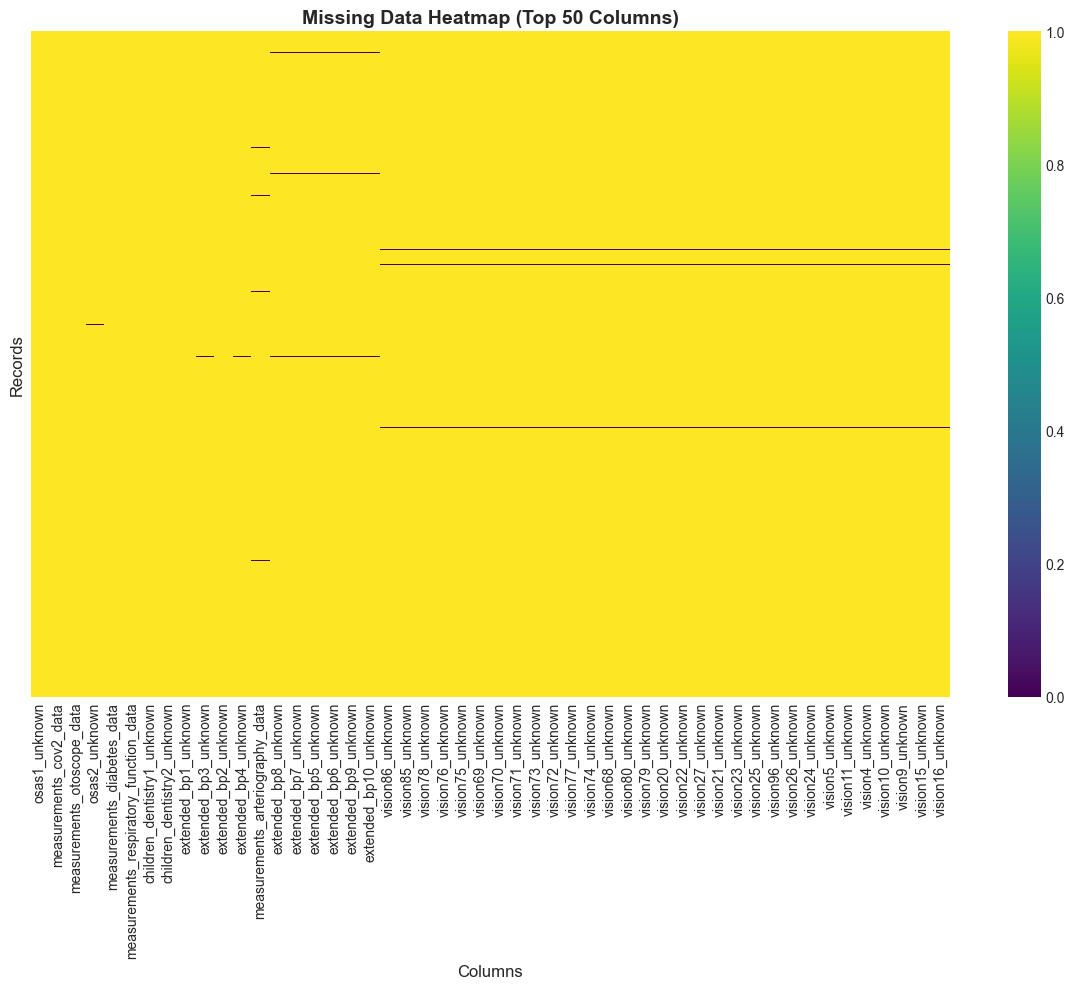

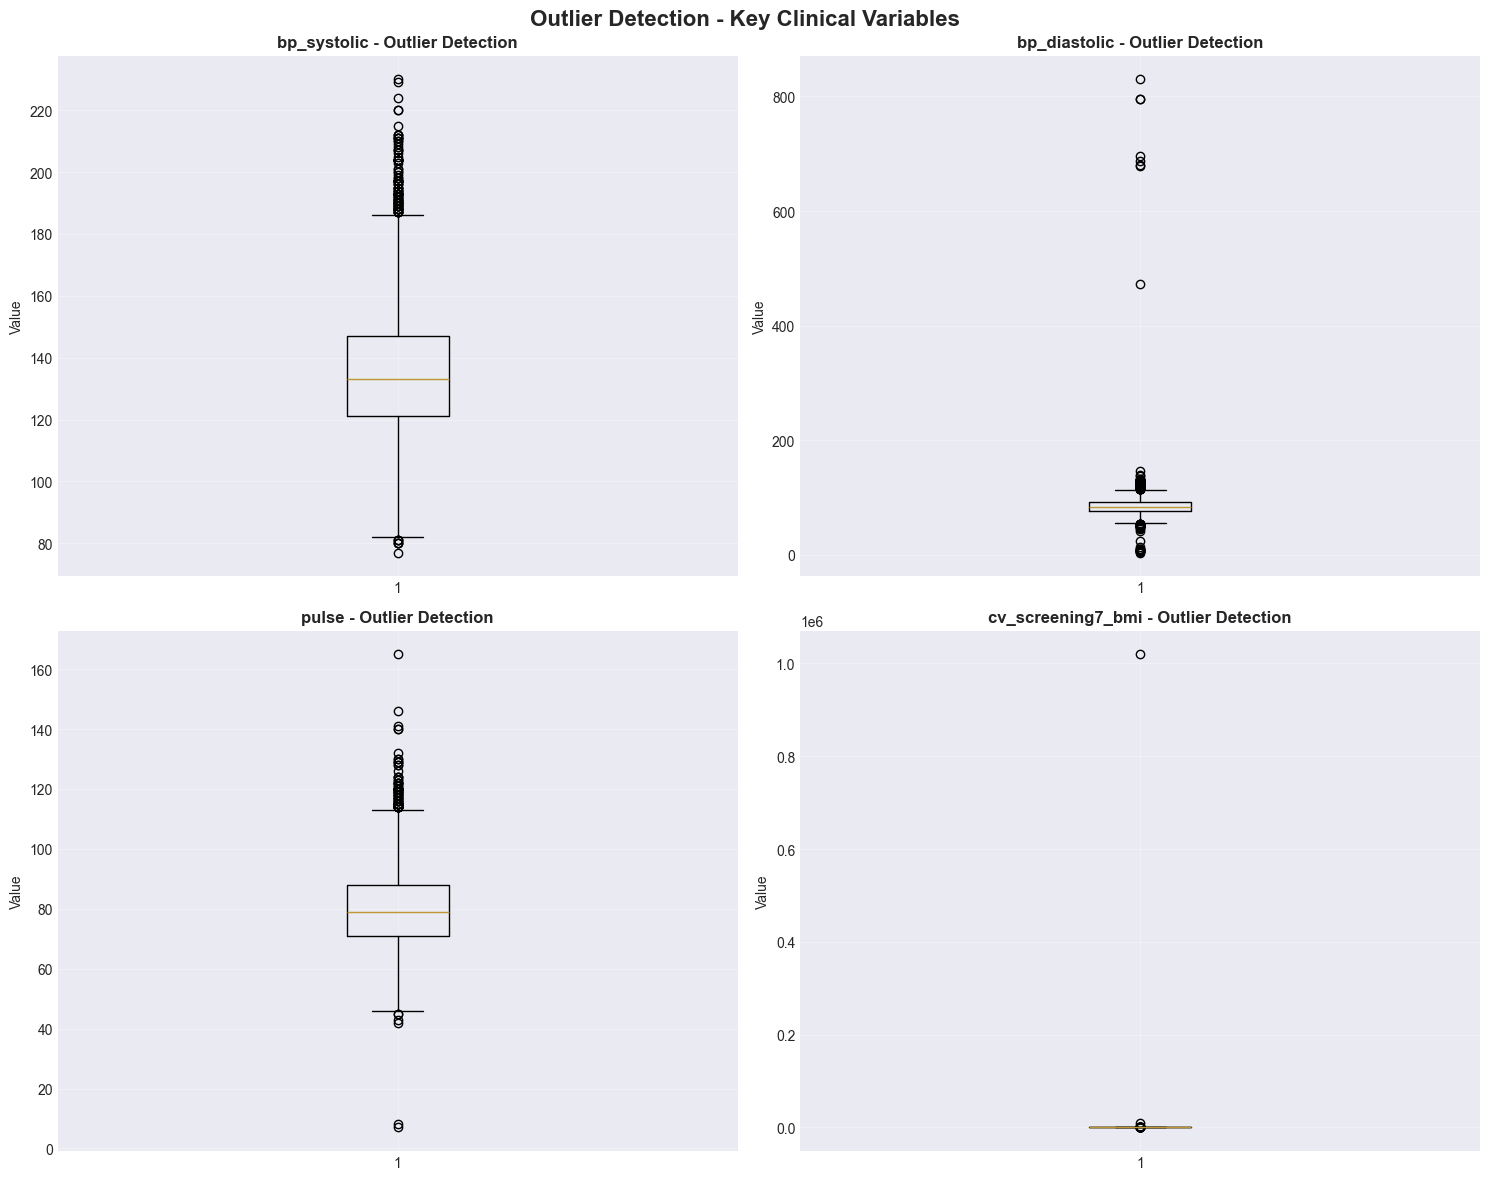

In [10]:
# Missing data heatmap (top 50 columns with most missing data)
top_missing = quality_report['missing_values'].head(50)
if len(top_missing) > 0:
    plt.figure(figsize=(12, 10))
    missing_subset = df[top_missing['Column'].values]
    sns.heatmap(missing_subset.isnull(), yticklabels=False, cbar=True, cmap='viridis')
    plt.title('Missing Data Heatmap (Top 50 Columns)', fontsize=14, fontweight='bold')
    plt.xlabel('Columns', fontsize=12)
    plt.ylabel('Records', fontsize=12)
    plt.tight_layout()
    plt.savefig(VIZ_DIR / 'data_quality' / 'missing_data_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()

# Outlier detection plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
clinical_vars = ['bp_systolic', 'bp_diastolic', 'pulse', 'cv_screening7_bmi']
for idx, var in enumerate(clinical_vars):
    if var in df.columns:
        ax = axes[idx // 2, idx % 2]
        data = df[var].dropna()
        if len(data) > 0:
            ax.boxplot(data, vert=True)
            ax.set_title(f'{var} - Outlier Detection', fontweight='bold')
            ax.set_ylabel('Value')
            ax.grid(True, alpha=0.3)
plt.suptitle('Outlier Detection - Key Clinical Variables', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(VIZ_DIR / 'data_quality' / 'outlier_detection.png', dpi=300, bbox_inches='tight')
plt.show()


In [11]:
### BMI, HEIGHT, WEIGHT, AND AGE QUALITY ASSESSMENT


In [12]:
def assess_anthropometric_data_quality(df):
    """
    Comprehensive quality assessment for BMI, height, weight, and age
    Analyzes missing patterns and relationships with age
    """
    assessment = {}
    
    # Define anthropometric columns
    anthropometric_cols = {
        'height': ['cv_screening5_height', 'physical1_height'],
        'weight': ['cv_screening6_weight', 'physical2_weight'],
        'bmi': ['cv_screening7_bmi', 'physical3_bmi'],
        'age': ['age']
    }
    
    # 1. Missing value analysis by column
    missing_analysis = {}
    for category, cols in anthropometric_cols.items():
        for col in cols:
            if col in df.columns:
                missing_count = df[col].isna().sum()
                missing_pct = (missing_count / len(df)) * 100
                non_missing_count = df[col].notna().sum()
                missing_analysis[col] = {
                    'category': category,
                    'missing_count': missing_count,
                    'missing_pct': missing_pct,
                    'non_missing_count': non_missing_count,
                    'non_missing_pct': 100 - missing_pct
                }
    
    assessment['missing_by_column'] = pd.DataFrame.from_dict(missing_analysis, orient='index')
    assessment['missing_by_column'] = assessment['missing_by_column'].sort_values('missing_pct', ascending=False)
    
    # 2. Missing value analysis by age groups
    if 'age' in df.columns:
        # Create age groups
        df_with_age = df[df['age'].notna()].copy()
        df_with_age['age_group'] = pd.cut(
            df_with_age['age'], 
            bins=[0, 18, 30, 45, 60, 75, 100],
            labels=['0-18', '19-30', '31-45', '46-60', '61-75', '75+']
        )
        
        age_group_analysis = {}
        anthropometric_vars = ['cv_screening5_height', 'cv_screening6_weight', 'cv_screening7_bmi',
                              'physical1_height', 'physical2_weight', 'physical3_bmi']
        
        for var in anthropometric_vars:
            if var in df_with_age.columns:
                age_group_analysis[var] = {}
                for age_group in df_with_age['age_group'].cat.categories:
                    group_data = df_with_age[df_with_age['age_group'] == age_group]
                    if len(group_data) > 0:
                        missing_count = group_data[var].isna().sum()
                        missing_pct = (missing_count / len(group_data)) * 100
                        age_group_analysis[var][age_group] = {
                            'total_records': len(group_data),
                            'missing_count': missing_count,
                            'missing_pct': missing_pct,
                            'non_missing_count': len(group_data) - missing_count,
                            'non_missing_pct': 100 - missing_pct
                        }
        
        assessment['missing_by_age_group'] = age_group_analysis
        
        # 3. Correlation between age and missing values
        age_missing_correlation = {}
        for var in anthropometric_vars:
            if var in df_with_age.columns:
                # Create binary indicator for missing (1 = missing, 0 = not missing)
                missing_indicator = df_with_age[var].isna().astype(int)
                if missing_indicator.sum() > 0 and missing_indicator.sum() < len(missing_indicator):
                    # Calculate correlation with age
                    correlation = df_with_age['age'].corr(missing_indicator)
                    age_missing_correlation[var] = {
                        'correlation_with_age': correlation,
                        'interpretation': 'Positive = older patients more likely to have missing values'
                    }
        
        assessment['age_missing_correlation'] = age_missing_correlation
    
    # 4. Data completeness patterns
    # Check how many records have complete anthropometric data
    anthropometric_vars_all = ['cv_screening5_height', 'cv_screening6_weight', 'cv_screening7_bmi',
                               'physical1_height', 'physical2_weight', 'physical3_bmi']
    available_vars = [v for v in anthropometric_vars_all if v in df.columns]
    
    if available_vars:
        completeness_patterns = {}
        
        # Records with at least one measurement
        has_any = df[available_vars].notna().any(axis=1).sum()
        completeness_patterns['has_any_measurement'] = {
            'count': has_any,
            'pct': (has_any / len(df)) * 100
        }
        
        # Records with all cv_screening measurements
        cv_vars = [v for v in available_vars if 'cv_screening' in v]
        if cv_vars:
            has_all_cv = df[cv_vars].notna().all(axis=1).sum()
            completeness_patterns['has_all_cv_screening'] = {
                'count': has_all_cv,
                'pct': (has_all_cv / len(df)) * 100,
                'variables': cv_vars
            }
        
        # Records with all physical measurements
        physical_vars = [v for v in available_vars if 'physical' in v]
        if physical_vars:
            has_all_physical = df[physical_vars].notna().all(axis=1).sum()
            completeness_patterns['has_all_physical'] = {
                'count': has_all_physical,
                'pct': (has_all_physical / len(df)) * 100,
                'variables': physical_vars
            }
        
        # Records with both height and weight (for BMI calculation)
        height_vars = [v for v in available_vars if 'height' in v]
        weight_vars = [v for v in available_vars if 'weight' in v]
        if height_vars and weight_vars:
            has_height_weight = (df[height_vars].notna().any(axis=1) & 
                                df[weight_vars].notna().any(axis=1)).sum()
            completeness_patterns['has_height_and_weight'] = {
                'count': has_height_weight,
                'pct': (has_height_weight / len(df)) * 100
            }
        
        assessment['completeness_patterns'] = completeness_patterns
    
    # 5. Statistical summary for available data
    stats_summary = {}
    for var in anthropometric_vars_all:
        if var in df.columns:
            data = df[var].dropna()
            if len(data) > 0 and pd.api.types.is_numeric_dtype(data):
                stats_summary[var] = {
                    'count': len(data),
                    'mean': data.mean(),
                    'median': data.median(),
                    'std': data.std(),
                    'min': data.min(),
                    'max': data.max(),
                    'q25': data.quantile(0.25),
                    'q75': data.quantile(0.75)
                }
    
    assessment['statistical_summary'] = pd.DataFrame.from_dict(stats_summary, orient='index')
    
    return assessment


In [13]:
# Run anthropometric data quality assessment
anthro_assessment = assess_anthropometric_data_quality(df)

print("=" * 80)
print("ANTHROPOMETRIC DATA QUALITY ASSESSMENT")
print("=" * 80)

print("\n1. MISSING VALUES BY COLUMN:")
print("-" * 80)
display(anthro_assessment['missing_by_column'])

print("\n2. STATISTICAL SUMMARY (for available data):")
print("-" * 80)
display(anthro_assessment['statistical_summary'])

print("\n3. DATA COMPLETENESS PATTERNS:")
print("-" * 80)
for pattern, info in anthro_assessment['completeness_patterns'].items():
    print(f"\n{pattern.replace('_', ' ').title()}:")
    print(f"  Count: {info['count']:,} ({info['pct']:.2f}%)")
    if 'variables' in info:
        print(f"  Variables: {', '.join(info['variables'])}")

if 'age_missing_correlation' in anthro_assessment:
    print("\n4. CORRELATION BETWEEN AGE AND MISSING VALUES:")
    print("-" * 80)
    for var, info in anthro_assessment['age_missing_correlation'].items():
        print(f"{var}:")
        print(f"  Correlation: {info['correlation_with_age']:.4f}")
        print(f"  {info['interpretation']}")


ANTHROPOMETRIC DATA QUALITY ASSESSMENT

1. MISSING VALUES BY COLUMN:
--------------------------------------------------------------------------------


,category,missing_count,missing_pct,non_missing_count,non_missing_pct
cv_screening6_weight,weight,23319,87.827200,3232,12.172800
cv_screening5_height,height,23310,87.793303,3241,12.206697
cv_screening7_bmi,bmi,23309,87.789537,3242,12.210463
physical2_weight,weight,20746,78.136417,5805,21.863583
physical3_bmi,bmi,20233,76.204286,6318,23.795714
physical1_height,height,20228,76.185454,6323,23.814546
age,age,0,0.000000,26551,100.000000



2. STATISTICAL SUMMARY (for available data):
--------------------------------------------------------------------------------


,count,mean,median,std,min,max,q25,q75
cv_screening7_bmi,3242,347.227008,28.84,17914.330029,11.46,1020000.0,24.6100,33.6700
physical3_bmi,6318,30.801559,28.46,126.128932,1.46,10000.0,24.1225,33.3075



3. DATA COMPLETENESS PATTERNS:
--------------------------------------------------------------------------------

Has Any Measurement:
  Count: 6,576 (24.77%)

Has All Cv Screening:
  Count: 3,225 (12.15%)
  Variables: cv_screening5_height, cv_screening6_weight, cv_screening7_bmi

Has All Physical:
  Count: 5,580 (21.02%)
  Variables: physical1_height, physical2_weight, physical3_bmi

Has Height And Weight:
  Count: 6,333 (23.85%)

4. CORRELATION BETWEEN AGE AND MISSING VALUES:
--------------------------------------------------------------------------------
cv_screening5_height:
  Correlation: -0.0741
  Positive = older patients more likely to have missing values
cv_screening6_weight:
  Correlation: -0.0743
  Positive = older patients more likely to have missing values
cv_screening7_bmi:
  Correlation: -0.0741
  Positive = older patients more likely to have missing values
physical1_height:
  Correlation: -0.0548
  Positive = older patients more likely to have missing values
physical2_w

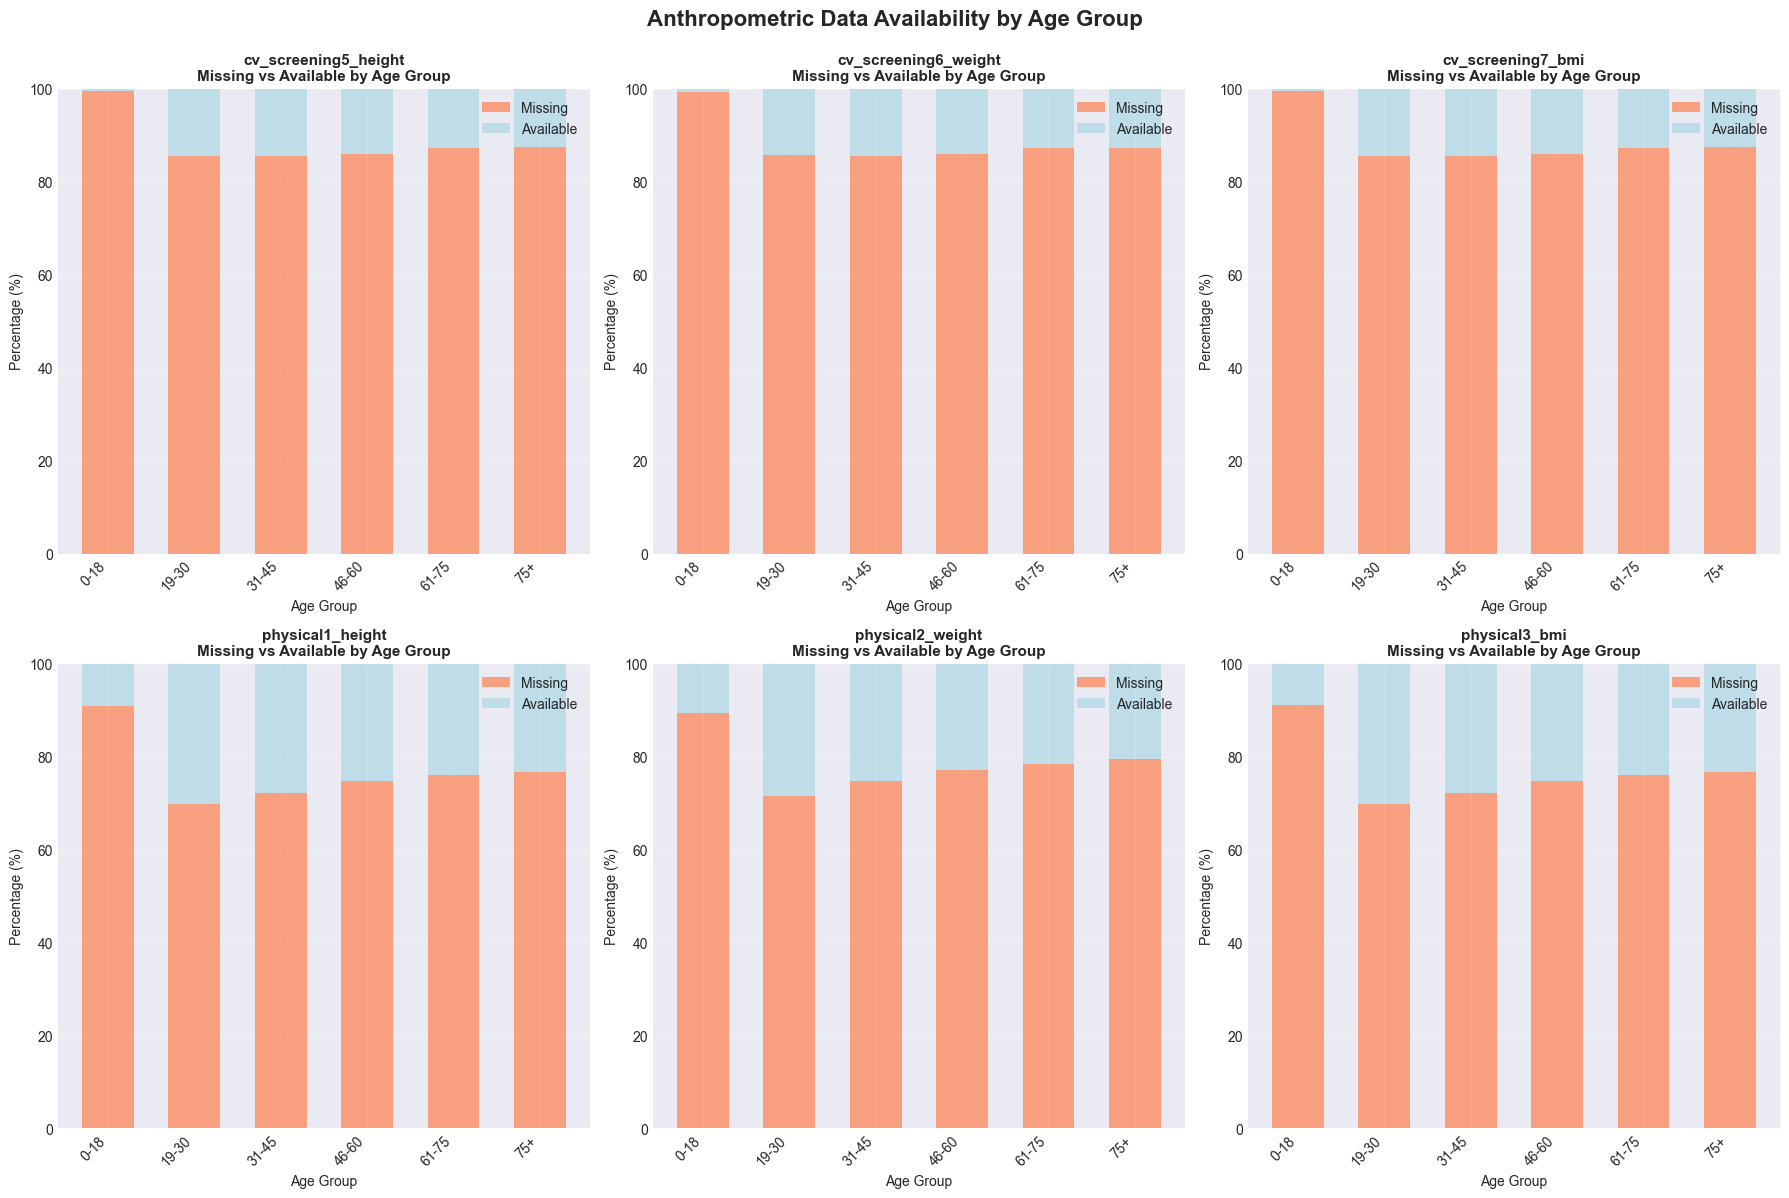

In [14]:
# Visualizations: Missing values by age group
if 'age' in df.columns and 'missing_by_age_group' in anthro_assessment:
    df_with_age = df[df['age'].notna()].copy()
    df_with_age['age_group'] = pd.cut(
        df_with_age['age'], 
        bins=[0, 18, 30, 45, 60, 75, 100],
        labels=['0-18', '19-30', '31-45', '46-60', '61-75', '75+']
    )
    
    # Create visualization for missing values by age group
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    anthropometric_vars = ['cv_screening5_height', 'cv_screening6_weight', 'cv_screening7_bmi',
                          'physical1_height', 'physical2_weight', 'physical3_bmi']
    
    for idx, var in enumerate(anthropometric_vars):
        if idx < len(axes) and var in anthro_assessment['missing_by_age_group']:
            ax = axes[idx]
            var_data = anthro_assessment['missing_by_age_group'][var]
            
            age_groups = []
            missing_pcts = []
            non_missing_pcts = []
            
            for age_group in ['0-18', '19-30', '31-45', '46-60', '61-75', '75+']:
                if age_group in var_data:
                    age_groups.append(age_group)
                    missing_pcts.append(var_data[age_group]['missing_pct'])
                    non_missing_pcts.append(var_data[age_group]['non_missing_pct'])
            
            if age_groups:
                x = np.arange(len(age_groups))
                width = 0.6
                
                ax.bar(x, missing_pcts, width, label='Missing', color='coral', alpha=0.7)
                ax.bar(x, non_missing_pcts, width, bottom=missing_pcts, label='Available', color='lightblue', alpha=0.7)
                
                ax.set_xlabel('Age Group', fontsize=10)
                ax.set_ylabel('Percentage (%)', fontsize=10)
                ax.set_title(f'{var}\nMissing vs Available by Age Group', fontsize=11, fontweight='bold')
                ax.set_xticks(x)
                ax.set_xticklabels(age_groups, rotation=45, ha='right')
                ax.legend()
                ax.grid(True, alpha=0.3, axis='y')
                ax.set_ylim(0, 100)
    
    plt.suptitle('Anthropometric Data Availability by Age Group', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig(VIZ_DIR / 'data_quality' / 'anthropometric_missing_by_age.png', dpi=300, bbox_inches='tight')
    plt.show()


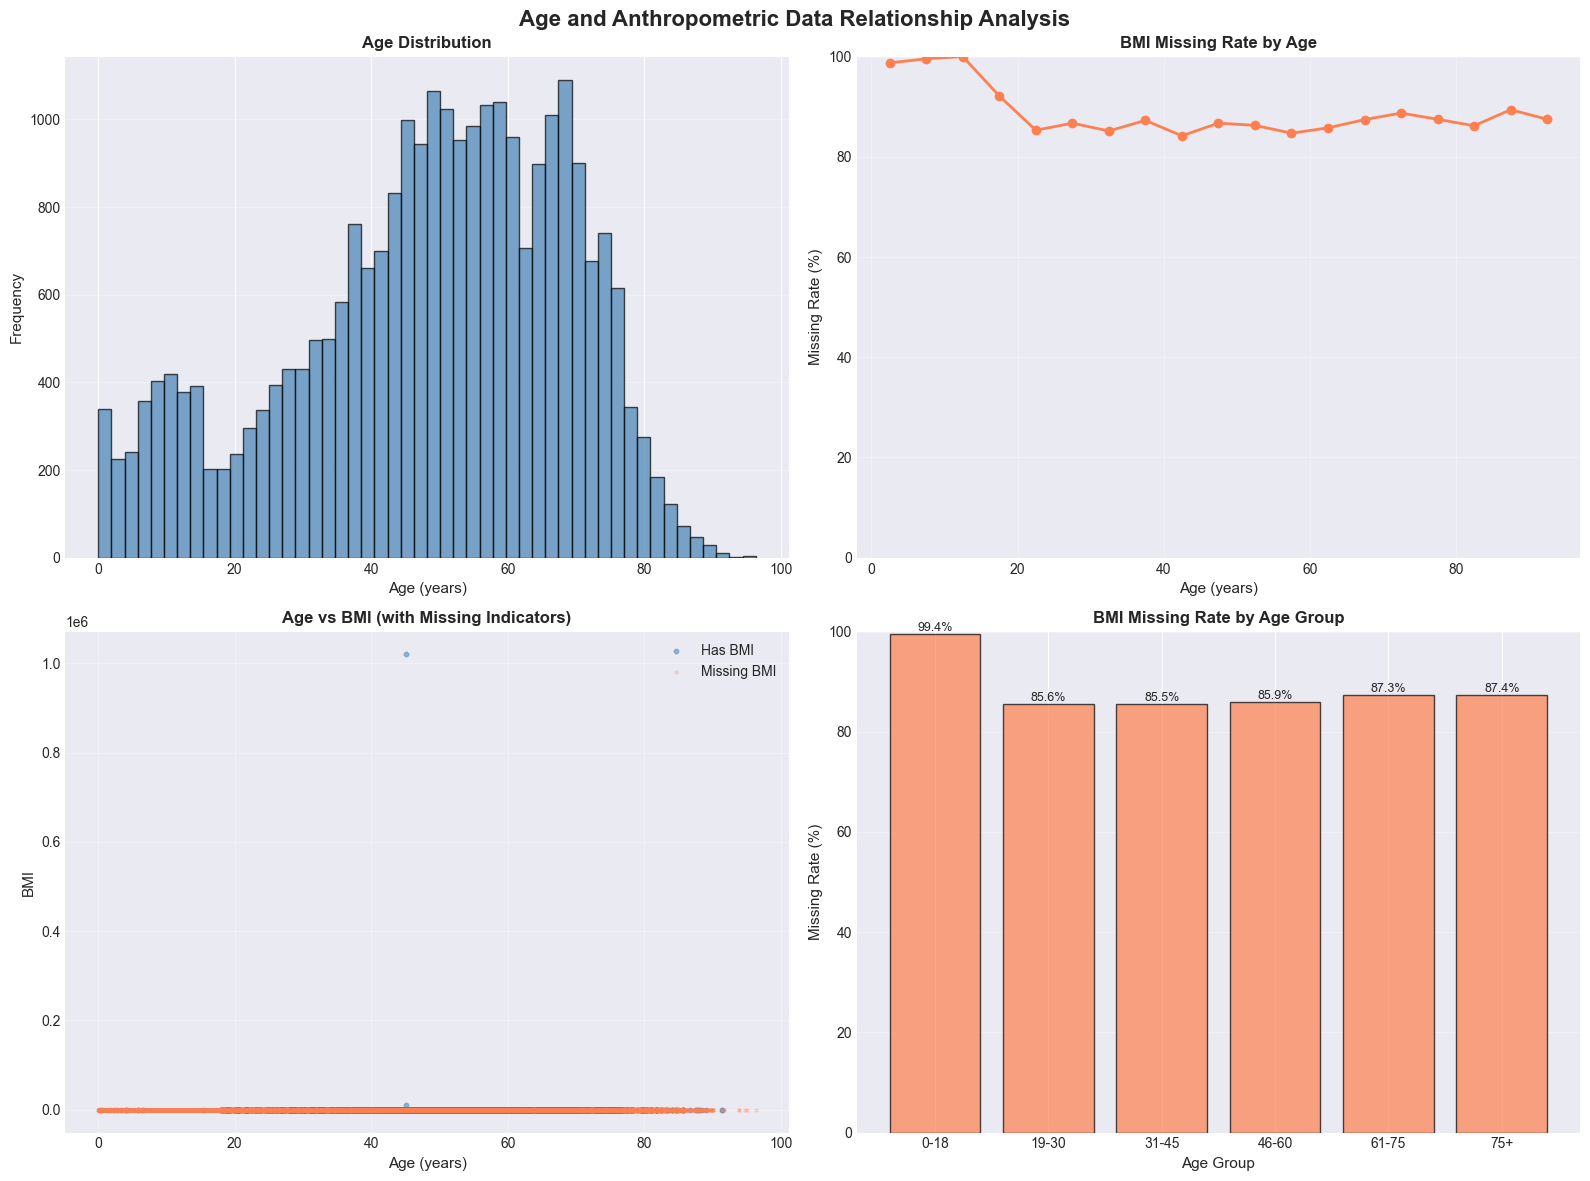

In [15]:
# Visualization: Age distribution and missing value relationship
if 'age' in df.columns:
    df_with_age = df[df['age'].notna()].copy()
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Age distribution
    ax1 = axes[0, 0]
    ax1.hist(df_with_age['age'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
    ax1.set_xlabel('Age (years)', fontsize=11)
    ax1.set_ylabel('Frequency', fontsize=11)
    ax1.set_title('Age Distribution', fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='y')
    
    # 2. Missing value rate by age (binned)
    ax2 = axes[0, 1]
    age_bins = np.arange(0, 100, 5)
    age_centers = age_bins[:-1] + 2.5
    
    # Calculate missing rate for BMI (cv_screening7_bmi) by age bin
    if 'cv_screening7_bmi' in df_with_age.columns:
        missing_rates = []
        for i in range(len(age_bins) - 1):
            bin_data = df_with_age[(df_with_age['age'] >= age_bins[i]) & 
                                   (df_with_age['age'] < age_bins[i+1])]
            if len(bin_data) > 0:
                missing_rate = bin_data['cv_screening7_bmi'].isna().sum() / len(bin_data) * 100
                missing_rates.append(missing_rate)
            else:
                missing_rates.append(np.nan)
        
        ax2.plot(age_centers, missing_rates, marker='o', linewidth=2, markersize=6, color='coral')
        ax2.set_xlabel('Age (years)', fontsize=11)
        ax2.set_ylabel('Missing Rate (%)', fontsize=11)
        ax2.set_title('BMI Missing Rate by Age', fontsize=12, fontweight='bold')
        ax2.grid(True, alpha=0.3)
        ax2.set_ylim(0, 100)
    
    # 3. Scatter: Age vs BMI (with missing indicator)
    ax3 = axes[1, 0]
    if 'cv_screening7_bmi' in df_with_age.columns:
        has_bmi = df_with_age['cv_screening7_bmi'].notna()
        ax3.scatter(df_with_age[has_bmi]['age'], df_with_age[has_bmi]['cv_screening7_bmi'], 
                   alpha=0.5, s=10, color='steelblue', label='Has BMI')
        ax3.scatter(df_with_age[~has_bmi]['age'], [25] * (~has_bmi).sum(), 
                   alpha=0.3, s=5, color='coral', marker='x', label='Missing BMI')
        ax3.set_xlabel('Age (years)', fontsize=11)
        ax3.set_ylabel('BMI', fontsize=11)
        ax3.set_title('Age vs BMI (with Missing Indicators)', fontsize=12, fontweight='bold')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
    
    # 4. Box plot: Missing vs Non-missing by age groups
    ax4 = axes[1, 1]
    if 'cv_screening7_bmi' in df_with_age.columns:
        df_with_age['age_group'] = pd.cut(
            df_with_age['age'], 
            bins=[0, 18, 30, 45, 60, 75, 100],
            labels=['0-18', '19-30', '31-45', '46-60', '61-75', '75+']
        )
        
        # Calculate missing percentage by age group
        age_groups = df_with_age['age_group'].cat.categories
        missing_pcts = []
        for ag in age_groups:
            group_data = df_with_age[df_with_age['age_group'] == ag]
            if len(group_data) > 0:
                missing_pct = group_data['cv_screening7_bmi'].isna().sum() / len(group_data) * 100
                missing_pcts.append(missing_pct)
            else:
                missing_pcts.append(0)
        
        bars = ax4.bar(age_groups, missing_pcts, color='coral', alpha=0.7, edgecolor='black')
        ax4.set_xlabel('Age Group', fontsize=11)
        ax4.set_ylabel('Missing Rate (%)', fontsize=11)
        ax4.set_title('BMI Missing Rate by Age Group', fontsize=12, fontweight='bold')
        ax4.set_ylim(0, 100)
        ax4.grid(True, alpha=0.3, axis='y')
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}%', ha='center', va='bottom', fontsize=9)
    
    plt.suptitle('Age and Anthropometric Data Relationship Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(VIZ_DIR / 'data_quality' / 'age_anthropometric_relationship.png', dpi=300, bbox_inches='tight')
    plt.show()


In [16]:
# Detailed analysis: Missing value patterns by age
if 'age' in df.columns and 'missing_by_age_group' in anthro_assessment:
    print("\n5. DETAILED MISSING VALUE ANALYSIS BY AGE GROUP:")
    print("=" * 80)
    
    anthropometric_vars = ['cv_screening5_height', 'cv_screening6_weight', 'cv_screening7_bmi',
                          'physical1_height', 'physical2_weight', 'physical3_bmi']
    
    # Create a comprehensive summary table
    summary_data = []
    for var in anthropometric_vars:
        if var in anthro_assessment['missing_by_age_group']:
            var_data = anthro_assessment['missing_by_age_group'][var]
            for age_group in ['0-18', '19-30', '31-45', '46-60', '61-75', '75+']:
                if age_group in var_data:
                    summary_data.append({
                        'Variable': var,
                        'Age_Group': age_group,
                        'Total_Records': var_data[age_group]['total_records'],
                        'Missing_Count': var_data[age_group]['missing_count'],
                        'Missing_Pct': var_data[age_group]['missing_pct'],
                        'Available_Count': var_data[age_group]['non_missing_count'],
                        'Available_Pct': var_data[age_group]['non_missing_pct']
                    })
    
    if summary_data:
        summary_df = pd.DataFrame(summary_data)
        print("\nSummary Table:")
        display(summary_df.pivot_table(
            index='Variable', 
            columns='Age_Group', 
            values='Missing_Pct',
            aggfunc='mean'
        ).round(2))
        
        # Find age groups with highest missing rates
        print("\nAge Groups with Highest Missing Rates:")
        print("-" * 80)
        for var in anthropometric_vars:
            if var in anthro_assessment['missing_by_age_group']:
                var_data = anthro_assessment['missing_by_age_group'][var]
                max_missing = max([v['missing_pct'] for v in var_data.values()])
                max_age_group = [k for k, v in var_data.items() if v['missing_pct'] == max_missing][0]
                print(f"{var}:")
                print(f"  Highest missing rate: {max_missing:.2f}% in age group {max_age_group}")
                print(f"  Records in this group: {var_data[max_age_group]['total_records']:,}")
                print()



5. DETAILED MISSING VALUE ANALYSIS BY AGE GROUP:

Summary Table:


Age_Group,0-18,19-30,31-45,46-60,61-75,75+
Variable,,,,,,
cv_screening5_height,99.41,85.60,85.49,85.88,87.27,87.36
cv_screening6_weight,99.38,85.69,85.55,85.96,87.27,87.30
cv_screening7_bmi,99.41,85.60,85.47,85.90,87.25,87.36
physical1_height,90.92,69.74,72.22,74.73,76.01,76.77
physical2_weight,89.45,71.58,74.65,77.17,78.39,79.58
physical3_bmi,90.99,69.79,72.22,74.75,76.01,76.77



Age Groups with Highest Missing Rates:
--------------------------------------------------------------------------------
cv_screening5_height:
  Highest missing rate: 99.41% in age group 0-18
  Records in this group: 3,052

cv_screening6_weight:
  Highest missing rate: 99.38% in age group 0-18
  Records in this group: 3,052

cv_screening7_bmi:
  Highest missing rate: 99.41% in age group 0-18
  Records in this group: 3,052

physical1_height:
  Highest missing rate: 90.92% in age group 0-18
  Records in this group: 3,052

physical2_weight:
  Highest missing rate: 89.45% in age group 0-18
  Records in this group: 3,052

physical3_bmi:
  Highest missing rate: 90.99% in age group 0-18
  Records in this group: 3,052




6. COMPARISON: CV SCREENING vs PHYSICAL MEASUREMENTS:


,Measurement_Type,CV_Screening_Missing,CV_Screening_Missing_Pct,Physical_Missing,Physical_Missing_Pct,Difference_Pct
0,5 Height,23310,87.793303,20228,76.185454,-11.607849
1,6 Weight,23319,87.827200,20746,78.136417,-9.690784
2,7 Bmi,23309,87.789537,20233,76.204286,-11.585251


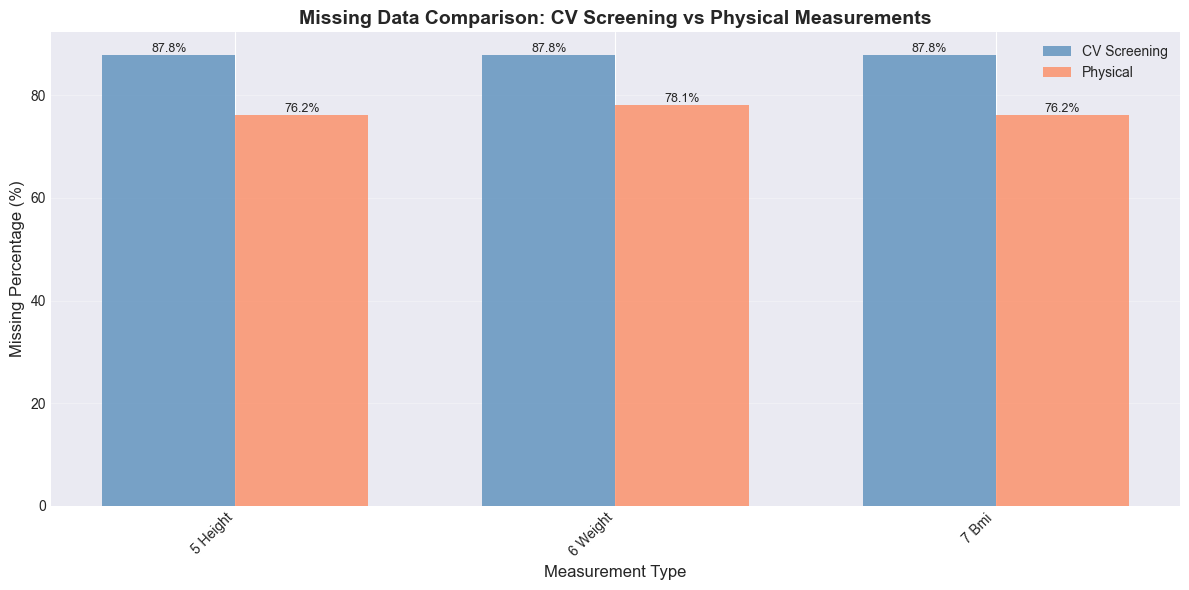

In [17]:
# Comparison: CV Screening vs Physical measurements
print("\n6. COMPARISON: CV SCREENING vs PHYSICAL MEASUREMENTS:")
print("=" * 80)

cv_vars = ['cv_screening5_height', 'cv_screening6_weight', 'cv_screening7_bmi']
physical_vars = ['physical1_height', 'physical2_weight', 'physical3_bmi']

comparison_data = []
for cv_var, phys_var in zip(cv_vars, physical_vars):
    if cv_var in df.columns and phys_var in df.columns:
        cv_missing = df[cv_var].isna().sum()
        phys_missing = df[phys_var].isna().sum()
        cv_pct = (cv_missing / len(df)) * 100
        phys_pct = (phys_missing / len(df)) * 100
        
        comparison_data.append({
            'Measurement_Type': cv_var.replace('cv_screening', '').replace('_', ' ').title(),
            'CV_Screening_Missing': cv_missing,
            'CV_Screening_Missing_Pct': cv_pct,
            'Physical_Missing': phys_missing,
            'Physical_Missing_Pct': phys_pct,
            'Difference_Pct': phys_pct - cv_pct
        })

if comparison_data:
    comparison_df = pd.DataFrame(comparison_data)
    display(comparison_df)
    
    # Visualization
    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.arange(len(comparison_df))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, comparison_df['CV_Screening_Missing_Pct'], width, 
                   label='CV Screening', color='steelblue', alpha=0.7)
    bars2 = ax.bar(x + width/2, comparison_df['Physical_Missing_Pct'], width,
                   label='Physical', color='coral', alpha=0.7)
    
    ax.set_xlabel('Measurement Type', fontsize=12)
    ax.set_ylabel('Missing Percentage (%)', fontsize=12)
    ax.set_title('Missing Data Comparison: CV Screening vs Physical Measurements', 
                fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(comparison_df['Measurement_Type'], rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.1f}%', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.savefig(VIZ_DIR / 'data_quality' / 'cv_vs_physical_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()


## 4. EDA

### Demographics Analysis


Gender distribution:
patient_gender
nő       18451
férfi     8100
Name: count, dtype: int64
Gender distribution (%):
patient_gender
nő       69.49
férfi    30.51
Name: count, dtype: float64


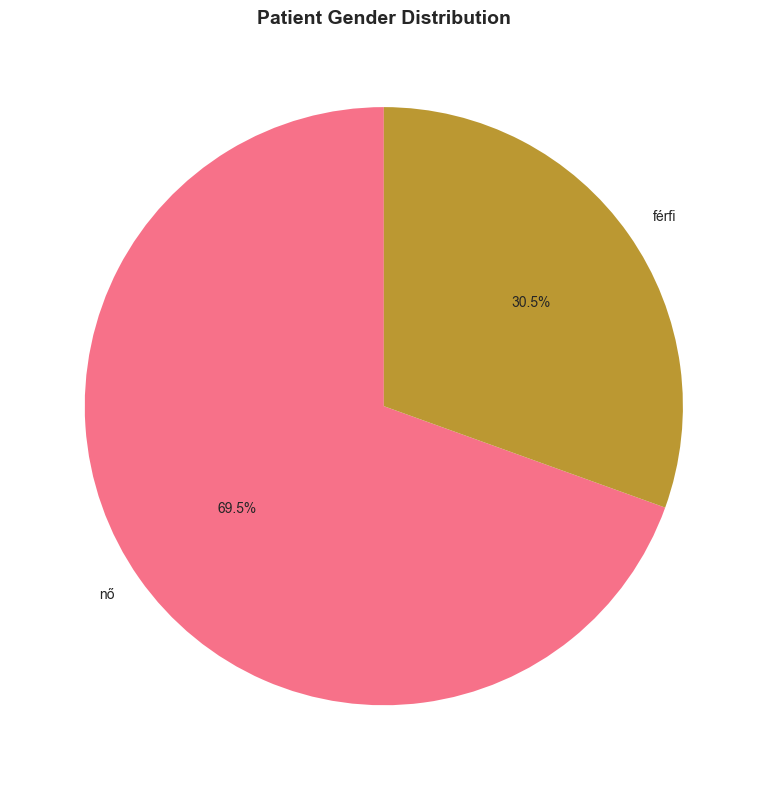

In [18]:
# Gender distribution
if 'patient_gender' in df.columns:
    gender_dist = df['patient_gender'].value_counts()
    print(f"Gender distribution:\n{gender_dist}")
    print(f"Gender distribution (%):\n{(gender_dist / len(df) * 100).round(2)}")
    
    # Gender pie chart
    plt.figure(figsize=(8, 8))
    gender_dist.plot(kind='pie', autopct='%1.1f%%', startangle=90)
    plt.title('Patient Gender Distribution', fontsize=14, fontweight='bold')
    plt.ylabel('')
    plt.tight_layout()
    plt.savefig(VIZ_DIR / 'eda' / 'gender_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()


In [19]:
### PATIENT-LEVEL GENDER ANALYSIS

In [20]:
def calculate_unique_patient_gender(df):
    """
    Calculate unique gender per patient (pid)
    Handles inconsistencies by using mode (most frequent) gender value per patient
    """
    if 'pid' not in df.columns or 'patient_gender' not in df.columns:
        print("Error: 'pid' or 'patient_gender' column not found")
        return None
    
    print("=" * 80)
    print("PATIENT-LEVEL GENDER ANALYSIS")
    print("=" * 80)
    
    # 1. Check gender values distribution
    print("\n1. GENDER VALUE DISTRIBUTION (all records):")
    print("-" * 80)
    gender_dist = df['patient_gender'].value_counts(dropna=False)
    print(gender_dist)
    print(f"\nMissing values: {df['patient_gender'].isna().sum():,} ({df['patient_gender'].isna().sum() / len(df) * 100:.2f}%)")
    
    # 2. Analyze gender consistency per patient
    print("\n2. GENDER CONSISTENCY PER PATIENT:")
    print("-" * 80)
    
    # Group by pid and analyze gender values
    gender_by_pid = df.groupby('pid')['patient_gender'].agg([
        ('count', 'count'),
        ('nunique', 'nunique'),
        ('values', lambda x: list(x.dropna()) if x.dropna().any() else []),
        ('unique_values', lambda x: list(x.dropna().unique()) if x.dropna().any() else []),
        ('mode', lambda x: x.mode()[0] if len(x.mode()) > 0 else None),
        ('first', 'first'),
        ('last', 'last')
    ]).reset_index()
    
    # Calculate consistency metrics
    total_patients = len(gender_by_pid)
    patients_with_gender = gender_by_pid['count'].gt(0).sum()
    patients_consistent = gender_by_pid['nunique'].eq(1).sum()
    patients_inconsistent = gender_by_pid['nunique'].gt(1).sum()
    patients_missing_all = gender_by_pid['count'].eq(0).sum()
    
    print(f"Total unique patients (pid): {total_patients:,}")
    print(f"Patients with at least one gender value: {patients_with_gender:,} ({patients_with_gender/total_patients*100:.2f}%)")
    print(f"Patients with consistent gender across all records: {patients_consistent:,} ({patients_consistent/total_patients*100:.2f}%)")
    print(f"Patients with inconsistent gender values: {patients_inconsistent:,} ({patients_inconsistent/total_patients*100:.2f}%)")
    print(f"Patients with no gender data: {patients_missing_all:,} ({patients_missing_all/total_patients*100:.2f}%)")
    
    # 3. Handle inconsistent patients
    print("\n3. RESOLVING GENDER INCONSISTENCIES:")
    print("-" * 80)
    
    # Strategy: Use mode (most frequent) gender per patient
    # If tie, use the most recent value
    def resolve_gender(row):
        if row['count'] == 0:
            return None  # No gender data
        elif row['nunique'] == 1:
            return row['unique_values'][0] if len(row['unique_values']) > 0 else None
        else:
            # Multiple values - use mode
            values = row['values']
            if len(values) == 0:
                return None
            # Count frequency of each value
            value_counts = pd.Series(values).value_counts()
            # If tie, use most recent (last value)
            if len(value_counts) > 0 and value_counts.iloc[0] == value_counts.iloc[-1] if len(value_counts) > 1 else True:
                return row['last'] if pd.notna(row['last']) else row['first']
            else:
                return value_counts.index[0]  # Most frequent
    
    gender_by_pid['resolved_gender'] = gender_by_pid.apply(resolve_gender, axis=1)
    
    # Report on inconsistent cases
    if patients_inconsistent > 0:
        inconsistent_patients = gender_by_pid[gender_by_pid['nunique'] > 1].copy()
        print(f"\nInconsistent patients (showing first 10):")
        print("-" * 80)
        for idx, row in inconsistent_patients.head(10).iterrows():
            print(f"  PID: {row['pid'][:20]}...")
            print(f"    Records: {row['count']}")
            print(f"    Unique values: {row['unique_values']}")
            print(f"    Resolved to: {row['resolved_gender']}")
            print()
    
    # 4. Create patient-level gender table
    patient_gender_table = gender_by_pid[['pid', 'resolved_gender']].copy()
    patient_gender_table.columns = ['pid', 'gender']
    
    # 5. Final distribution
    print("\n4. FINAL PATIENT-LEVEL GENDER DISTRIBUTION:")
    print("-" * 80)
    final_gender_dist = patient_gender_table['gender'].value_counts(dropna=False)
    print(final_gender_dist)
    print(f"\nMissing values: {patient_gender_table['gender'].isna().sum():,} ({patient_gender_table['gender'].isna().sum() / len(patient_gender_table) * 100:.2f}%)")
    
    # 6. Summary statistics
    print("\n5. SUMMARY STATISTICS:")
    print("-" * 80)
    print(f"Total patients: {len(patient_gender_table):,}")
    print(f"Patients with gender: {patient_gender_table['gender'].notna().sum():,}")
    print(f"Patients without gender: {patient_gender_table['gender'].isna().sum():,}")
    
    return {
        'patient_gender_table': patient_gender_table,
        'gender_by_pid': gender_by_pid,
        'inconsistent_patients': inconsistent_patients if patients_inconsistent > 0 else pd.DataFrame(),
        'consistency_stats': {
            'total_patients': total_patients,
            'consistent': patients_consistent,
            'inconsistent': patients_inconsistent,
            'missing_all': patients_missing_all
        }
    }


In [21]:
# Run patient-level gender analysis
gender_analysis = calculate_unique_patient_gender(df)

# Store the patient-level gender table for later use
if gender_analysis:
    patient_gender_df = gender_analysis['patient_gender_table']
    print(f"\n6. PATIENT-LEVEL GENDER TABLE CREATED:")
    print("-" * 80)
    print(f"Shape: {patient_gender_df.shape}")
    print(f"\nFirst 10 rows:")
    display(patient_gender_df.head(10))
    
    # Save to data directory
    patient_gender_df.to_csv(DATA_DIR / 'patient_gender_unique.csv', index=False)
    print(f"\n✓ Saved to: {DATA_DIR / 'patient_gender_unique.csv'}")


PATIENT-LEVEL GENDER ANALYSIS

1. GENDER VALUE DISTRIBUTION (all records):
--------------------------------------------------------------------------------
patient_gender
nő       18451
férfi     8100
Name: count, dtype: int64

Missing values: 0 (0.00%)

2. GENDER CONSISTENCY PER PATIENT:
--------------------------------------------------------------------------------
Total unique patients (pid): 6,357
Patients with at least one gender value: 6,357 (100.00%)
Patients with consistent gender across all records: 6,353 (99.94%)
Patients with inconsistent gender values: 4 (0.06%)
Patients with no gender data: 0 (0.00%)

3. RESOLVING GENDER INCONSISTENCIES:
--------------------------------------------------------------------------------

Inconsistent patients (showing first 10):
--------------------------------------------------------------------------------
  PID: 1e4f289be70de45f059d...
    Records: 8
    Unique values: ['férfi', 'nő']
    Resolved to: férfi

  PID: 4f55bf00d926f4d2acf2...

,pid,gender
0,0022a311df715e9740427755bbc194533776e03242c47bd76daf047d2970dda0,nő
1,00343c575db967dc335a85dab4ede661c58786aa3180df90faaacd7500567418,férfi
2,003d1426b37bb9341ba25c89156fee5ff70b6e0d402b36439d39384d1e61f4d0,nő
3,0045f4e1273379f7d0161bc42ce8f9028bdc7e7fa46581a2d2551013053f1e99,nő
4,0048df6b40355e471b46ee1232b2d01c10c764a2be52fd3c5ff8979722a1e146,férfi
5,0058b9390bd0694a07b6dc73f267d1d402c6daeb83b06459dce735b05fa41be4,nő
6,0069928fcbb31138c5212d0a07c35bab578956a6b4efea7915b0fba25bb4de24,nő
7,006b0615cee80aa596bf7f976cc3a914cff58172d0bd253df001d16bcff7f5e3,nő
8,006fdd9489a45fdffb15ee34cad65085487d0a6c96a71d742679f3b552ae23a9,férfi
9,009aeb41866e11357a272b388ca823f45a6c247503b29ab73efef365489fa0e4,férfi



✓ Saved to: outputs\data\patient_gender_unique.csv


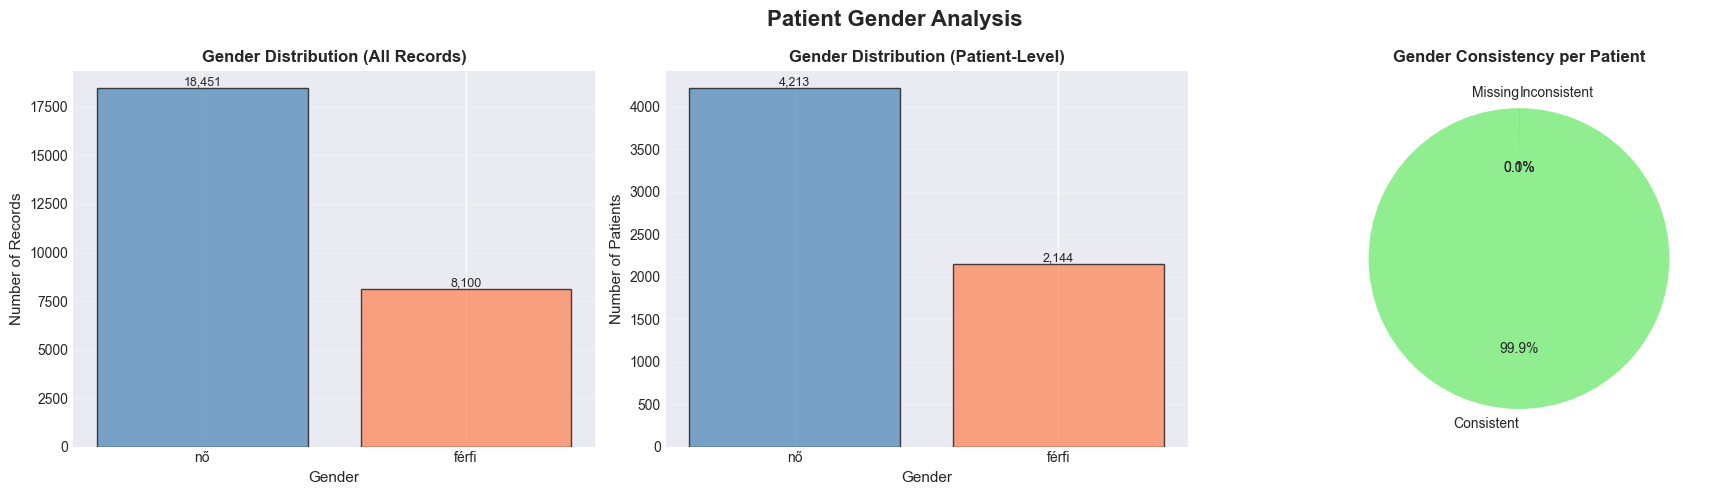

In [22]:
# Visualization: Gender consistency analysis
if gender_analysis:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # 1. Gender distribution (all records)
    ax1 = axes[0]
    gender_dist_all = df['patient_gender'].value_counts(dropna=False)
    colors = ['steelblue', 'coral', 'lightgray']
    ax1.bar(gender_dist_all.index.astype(str), gender_dist_all.values, color=colors[:len(gender_dist_all)], alpha=0.7, edgecolor='black')
    ax1.set_xlabel('Gender', fontsize=11)
    ax1.set_ylabel('Number of Records', fontsize=11)
    ax1.set_title('Gender Distribution (All Records)', fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='y')
    for i, (idx, val) in enumerate(gender_dist_all.items()):
        ax1.text(i, val, f'{val:,}', ha='center', va='bottom', fontsize=9)
    
    # 2. Gender distribution (patient-level)
    ax2 = axes[1]
    gender_dist_patients = patient_gender_df['gender'].value_counts(dropna=False)
    ax2.bar(gender_dist_patients.index.astype(str), gender_dist_patients.values, color=colors[:len(gender_dist_patients)], alpha=0.7, edgecolor='black')
    ax2.set_xlabel('Gender', fontsize=11)
    ax2.set_ylabel('Number of Patients', fontsize=11)
    ax2.set_title('Gender Distribution (Patient-Level)', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    for i, (idx, val) in enumerate(gender_dist_patients.items()):
        ax2.text(i, val, f'{val:,}', ha='center', va='bottom', fontsize=9)
    
    # 3. Consistency pie chart
    ax3 = axes[2]
    if gender_analysis['consistency_stats']['inconsistent'] > 0:
        consistency_data = {
            'Consistent': gender_analysis['consistency_stats']['consistent'],
            'Inconsistent': gender_analysis['consistency_stats']['inconsistent'],
            'Missing': gender_analysis['consistency_stats']['missing_all']
        }
        ax3.pie(consistency_data.values(), labels=consistency_data.keys(), autopct='%1.1f%%', 
               startangle=90, colors=['lightgreen', 'coral', 'lightgray'], 
               textprops={'fontsize': 10})
        ax3.set_title('Gender Consistency per Patient', fontsize=12, fontweight='bold')
    else:
        ax3.text(0.5, 0.5, 'All patients have\nconsistent gender', 
                ha='center', va='center', fontsize=12, fontweight='bold')
        ax3.set_title('Gender Consistency per Patient', fontsize=12, fontweight='bold')
    
    plt.suptitle('Patient Gender Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(VIZ_DIR / 'data_quality' / 'patient_gender_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()


### PATIENT ENCOUNTERS ANALYSIS BY AGE GROUP


In [23]:
def analyze_encounters_by_age_group(df):
    """
    Analyze patient encounters (visits) by age group
    Provides insights into healthcare utilization patterns across different age groups
    """
    if 'pid' not in df.columns or 'age' not in df.columns or 'created' not in df.columns:
        print("Error: Required columns ('pid', 'age', 'created') not found")
        return None
    
    print("=" * 80)
    print("PATIENT ENCOUNTERS ANALYSIS BY AGE GROUP")
    print("=" * 80)
    
    # Create a copy with age data
    df_with_age = df[df['age'].notna()].copy()
    
    # Create age groups
    df_with_age['age_group'] = pd.cut(
        df_with_age['age'], 
        bins=[0, 18, 30, 45, 60, 75, 100],
        labels=['0-18', '19-30', '31-45', '46-60', '61-75', '75+']
    )
    
    print(f"\nTotal records with age data: {len(df_with_age):,}")
    print(f"Total unique patients: {df_with_age['pid'].nunique():,}")
    
    # 1. Encounters per patient by age group
    print("\n1. ENCOUNTERS PER PATIENT BY AGE GROUP:")
    print("-" * 80)
    
    # Count encounters per patient per age group
    encounters_by_pid_age = df_with_age.groupby(['pid', 'age_group']).size().reset_index(name='encounters')
    
    # Get patient-level age group (most common age group for each patient)
    patient_age_group = df_with_age.groupby('pid')['age_group'].agg(lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0]).reset_index()
    patient_age_group.columns = ['pid', 'primary_age_group']
    
    # Merge to get primary age group for each patient
    encounters_by_pid_age = encounters_by_pid_age.merge(patient_age_group, on='pid', how='left')
    
    # Total encounters per patient
    total_encounters_per_patient = df_with_age.groupby('pid').size().reset_index(name='total_encounters')
    
    # Merge with patient age group
    patient_encounters = patient_age_group.merge(total_encounters_per_patient, on='pid', how='left')
    
    # 2. Statistics by age group
    print("\n2. ENCOUNTER STATISTICS BY AGE GROUP:")
    print("-" * 80)
    
    age_group_stats = []
    for age_group in patient_encounters['primary_age_group'].cat.categories:
        group_data = patient_encounters[patient_encounters['primary_age_group'] == age_group]
        if len(group_data) > 0:
            stats_dict = {
                'age_group': age_group,
                'n_patients': len(group_data),
                'total_encounters': group_data['total_encounters'].sum(),
                'mean_encounters': group_data['total_encounters'].mean(),
                'median_encounters': group_data['total_encounters'].median(),
                'std_encounters': group_data['total_encounters'].std(),
                'min_encounters': group_data['total_encounters'].min(),
                'max_encounters': group_data['total_encounters'].max(),
                'q25_encounters': group_data['total_encounters'].quantile(0.25),
                'q75_encounters': group_data['total_encounters'].quantile(0.75),
                'pct_patients_1_visit': (group_data['total_encounters'] == 1).sum() / len(group_data) * 100,
                'pct_patients_5plus_visits': (group_data['total_encounters'] >= 5).sum() / len(group_data) * 100,
                'pct_patients_10plus_visits': (group_data['total_encounters'] >= 10).sum() / len(group_data) * 100
            }
            age_group_stats.append(stats_dict)
    
    stats_df = pd.DataFrame(age_group_stats)
    display(stats_df.round(2))
    
    # 3. Distribution of encounters
    print("\n3. ENCOUNTER DISTRIBUTION BY AGE GROUP:")
    print("-" * 80)
    
    # Create encounter categories
    # 8 bin edges create 7 bins, so we need 7 labels
    patient_encounters['encounter_category'] = pd.cut(
        patient_encounters['total_encounters'],
        bins=[0, 1, 2, 3, 5, 10, 20, 100],
        labels=['1', '2', '3', '4-5', '6-10', '11-20', '20+']
    )
    
    distribution = patient_encounters.groupby(['primary_age_group', 'encounter_category']).size().unstack(fill_value=0)
    distribution_pct = patient_encounters.groupby(['primary_age_group', 'encounter_category']).size().unstack(fill_value=0)
    distribution_pct = distribution_pct.div(distribution_pct.sum(axis=1), axis=0) * 100
    
    print("\nCount of patients by encounter category:")
    display(distribution)
    
    print("\nPercentage of patients by encounter category:")
    display(distribution_pct.round(2))
    
    # 4. Time span analysis (for patients with multiple visits)
    print("\n4. TIME SPAN ANALYSIS (Patients with Multiple Visits):")
    print("-" * 80)
    
    multi_visit_patients = patient_encounters[patient_encounters['total_encounters'] > 1].copy()
    
    if len(multi_visit_patients) > 0:
        # Calculate time span for each patient
        patient_timespan = df_with_age.groupby('pid')['created'].agg(['min', 'max']).reset_index()
        patient_timespan['days_span'] = (patient_timespan['max'] - patient_timespan['min']).dt.days
        patient_timespan['years_span'] = patient_timespan['days_span'] / 365.25
        
        multi_visit_patients = multi_visit_patients.merge(patient_timespan[['pid', 'days_span', 'years_span']], on='pid', how='left')
        
        timespan_stats = []
        for age_group in multi_visit_patients['primary_age_group'].cat.categories:
            group_data = multi_visit_patients[multi_visit_patients['primary_age_group'] == age_group]
            if len(group_data) > 0:
                timespan_stats.append({
                    'age_group': age_group,
                    'n_patients': len(group_data),
                    'mean_days_span': group_data['days_span'].mean(),
                    'median_days_span': group_data['days_span'].median(),
                    'mean_years_span': group_data['years_span'].mean(),
                    'median_years_span': group_data['years_span'].median(),
                    'mean_visits_per_year': (group_data['total_encounters'] / group_data['years_span']).mean()
                })
        
        timespan_df = pd.DataFrame(timespan_stats)
        display(timespan_df.round(2))
    
    return {
        'patient_encounters': patient_encounters,
        'encounters_by_pid_age': encounters_by_pid_age,
        'stats_by_age_group': stats_df,
        'distribution': distribution,
        'distribution_pct': distribution_pct,
        'multi_visit_patients': multi_visit_patients if len(multi_visit_patients) > 0 else pd.DataFrame()
    }


In [24]:
# Run encounters by age group analysis
encounters_analysis = analyze_encounters_by_age_group(df)

# Save patient encounters data
if encounters_analysis:
    patient_encounters_df = encounters_analysis['patient_encounters']
    print(f"\n5. PATIENT ENCOUNTERS TABLE CREATED:")
    print("-" * 80)
    print(f"Shape: {patient_encounters_df.shape}")
    print(f"\nFirst 10 rows:")
    display(patient_encounters_df.head(10))
    
    # Save to data directory
    patient_encounters_df.to_csv(DATA_DIR / 'patient_encounters_by_age_group.csv', index=False)
    print(f"\n✓ Saved to: {DATA_DIR / 'patient_encounters_by_age_group.csv'}")


PATIENT ENCOUNTERS ANALYSIS BY AGE GROUP

Total records with age data: 26,551
Total unique patients: 6,357

1. ENCOUNTERS PER PATIENT BY AGE GROUP:
--------------------------------------------------------------------------------


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_25340\3393277427.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  encounters_by_pid_age = df_with_age.groupby(['pid', 'age_group']).size().reset_index(name='encounters')



2. ENCOUNTER STATISTICS BY AGE GROUP:
--------------------------------------------------------------------------------


,age_group,n_patients,total_encounters,mean_encounters,median_encounters,std_encounters,min_encounters,max_encounters,q25_encounters,q75_encounters,pct_patients_1_visit,pct_patients_5plus_visits,pct_patients_10plus_visits
0,0-18,1245,3033,2.44,2.0,1.83,1,26,1.0,3.0,30.76,9.48,0.56
1,19-30,594,2073,3.49,2.0,3.43,1,32,1.0,4.0,29.97,22.56,6.06
2,31-45,1237,5089,4.11,3.0,4.07,1,39,1.0,5.0,25.22,29.43,9.38
3,46-60,1616,7815,4.84,3.0,4.88,1,40,2.0,6.0,24.01,36.63,12.81
4,61-75,1277,6792,5.32,3.0,5.82,1,93,1.0,7.0,25.14,41.43,16.60
5,75+,387,1710,4.42,3.0,4.77,1,39,1.0,6.0,34.11,34.37,11.37



3. ENCOUNTER DISTRIBUTION BY AGE GROUP:
--------------------------------------------------------------------------------

Count of patients by encounter category:


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_25340\3393277427.py:87: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  distribution = patient_encounters.groupby(['primary_age_group', 'encounter_category']).size().unstack(fill_value=0)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_25340\3393277427.py:88: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  distribution_pct = patient_encounters.groupby(['primary_age_group', 'encounter_category']).size().unstack(fill_value=0)


encounter_category,1,2,3,4-5,6-10,11-20,20+
primary_age_group,,,,,,,
0-18,383,474,155,163,64,5,1
19-30,178,126,92,96,80,17,5
31-45,312,258,154,238,182,79,14
46-60,388,271,182,297,320,131,27
61-75,321,178,142,211,254,145,26
75+,132,54,34,60,74,27,6



Percentage of patients by encounter category:


encounter_category,1,2,3,4-5,6-10,11-20,20+
primary_age_group,,,,,,,
0-18,30.76,38.07,12.45,13.09,5.14,0.40,0.08
19-30,29.97,21.21,15.49,16.16,13.47,2.86,0.84
31-45,25.22,20.86,12.45,19.24,14.71,6.39,1.13
46-60,24.01,16.77,11.26,18.38,19.80,8.11,1.67
61-75,25.14,13.94,11.12,16.52,19.89,11.35,2.04
75+,34.11,13.95,8.79,15.50,19.12,6.98,1.55



4. TIME SPAN ANALYSIS (Patients with Multiple Visits):
--------------------------------------------------------------------------------


,age_group,n_patients,mean_days_span,median_days_span,mean_years_span,median_years_span,mean_visits_per_year
0,0-18,862,150.33,97.0,0.41,0.27,inf
1,19-30,416,184.29,87.0,0.50,0.24,inf
2,31-45,925,236.41,112.0,0.65,0.31,inf
3,46-60,1228,246.48,140.0,0.67,0.38,inf
4,61-75,956,256.97,156.5,0.70,0.43,inf
5,75+,255,233.64,133.0,0.64,0.36,31.54



5. PATIENT ENCOUNTERS TABLE CREATED:
--------------------------------------------------------------------------------
Shape: (6357, 4)

First 10 rows:


,pid,primary_age_group,total_encounters,encounter_category
0,0022a311df715e9740427755bbc194533776e03242c47bd76daf047d2970dda0,19-30,1,1
1,00343c575db967dc335a85dab4ede661c58786aa3180df90faaacd7500567418,46-60,3,3
2,003d1426b37bb9341ba25c89156fee5ff70b6e0d402b36439d39384d1e61f4d0,19-30,10,6-10
3,0045f4e1273379f7d0161bc42ce8f9028bdc7e7fa46581a2d2551013053f1e99,46-60,14,11-20
4,0048df6b40355e471b46ee1232b2d01c10c764a2be52fd3c5ff8979722a1e146,46-60,10,6-10
5,0058b9390bd0694a07b6dc73f267d1d402c6daeb83b06459dce735b05fa41be4,46-60,8,6-10
6,0069928fcbb31138c5212d0a07c35bab578956a6b4efea7915b0fba25bb4de24,19-30,9,6-10
7,006b0615cee80aa596bf7f976cc3a914cff58172d0bd253df001d16bcff7f5e3,31-45,6,6-10
8,006fdd9489a45fdffb15ee34cad65085487d0a6c96a71d742679f3b552ae23a9,61-75,5,4-5
9,009aeb41866e11357a272b388ca823f45a6c247503b29ab73efef365489fa0e4,46-60,1,1



✓ Saved to: outputs\data\patient_encounters_by_age_group.csv


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_25340\2888880633.py:40: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax3.boxplot(data_for_box, labels=age_groups, patch_artist=True)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_25340\2888880633.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


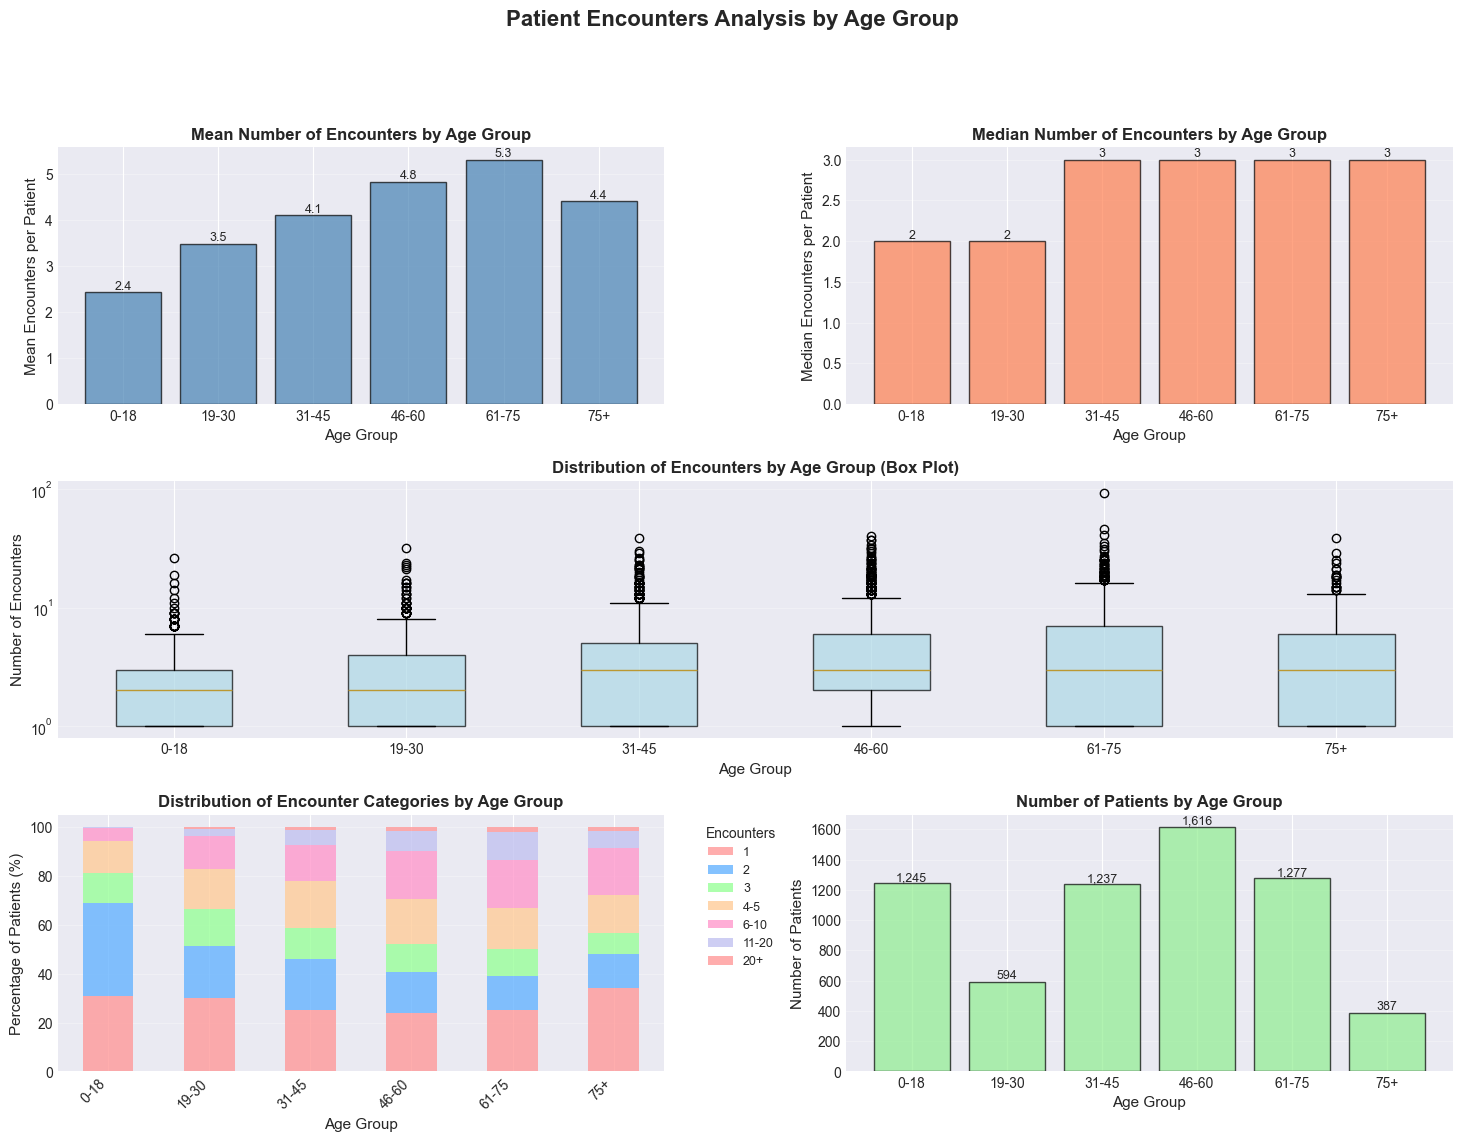

In [25]:
# Visualizations: Encounters by age group
if encounters_analysis:
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)
    
    patient_encounters_df = encounters_analysis['patient_encounters']
    stats_df = encounters_analysis['stats_by_age_group']
    
    # 1. Mean encounters by age group
    ax1 = fig.add_subplot(gs[0, 0])
    bars1 = ax1.bar(stats_df['age_group'], stats_df['mean_encounters'], 
                    color='steelblue', alpha=0.7, edgecolor='black')
    ax1.set_xlabel('Age Group', fontsize=11)
    ax1.set_ylabel('Mean Encounters per Patient', fontsize=11)
    ax1.set_title('Mean Number of Encounters by Age Group', fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='y')
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}', ha='center', va='bottom', fontsize=9)
    
    # 2. Median encounters by age group
    ax2 = fig.add_subplot(gs[0, 1])
    bars2 = ax2.bar(stats_df['age_group'], stats_df['median_encounters'], 
                    color='coral', alpha=0.7, edgecolor='black')
    ax2.set_xlabel('Age Group', fontsize=11)
    ax2.set_ylabel('Median Encounters per Patient', fontsize=11)
    ax2.set_title('Median Number of Encounters by Age Group', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.0f}', ha='center', va='bottom', fontsize=9)
    
    # 3. Box plot of encounters by age group
    ax3 = fig.add_subplot(gs[1, :])
    age_groups = patient_encounters_df['primary_age_group'].cat.categories
    data_for_box = [patient_encounters_df[patient_encounters_df['primary_age_group'] == ag]['total_encounters'].values 
                    for ag in age_groups]
    bp = ax3.boxplot(data_for_box, labels=age_groups, patch_artist=True)
    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')
        patch.set_alpha(0.7)
    ax3.set_xlabel('Age Group', fontsize=11)
    ax3.set_ylabel('Number of Encounters', fontsize=11)
    ax3.set_title('Distribution of Encounters by Age Group (Box Plot)', fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='y')
    ax3.set_yscale('log')  # Use log scale for better visualization
    
    # 4. Distribution of encounter categories
    ax4 = fig.add_subplot(gs[2, 0])
    distribution_pct = encounters_analysis['distribution_pct']
    distribution_pct.plot(kind='bar', ax=ax4, stacked=True, 
                         color=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#ff99cc', '#c2c2f0'],
                         alpha=0.8)
    ax4.set_xlabel('Age Group', fontsize=11)
    ax4.set_ylabel('Percentage of Patients (%)', fontsize=11)
    ax4.set_title('Distribution of Encounter Categories by Age Group', fontsize=12, fontweight='bold')
    ax4.legend(title='Encounters', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45, ha='right')
    ax4.grid(True, alpha=0.3, axis='y')
    
    # 5. Number of patients by age group
    ax5 = fig.add_subplot(gs[2, 1])
    bars5 = ax5.bar(stats_df['age_group'], stats_df['n_patients'], 
                    color='lightgreen', alpha=0.7, edgecolor='black')
    ax5.set_xlabel('Age Group', fontsize=11)
    ax5.set_ylabel('Number of Patients', fontsize=11)
    ax5.set_title('Number of Patients by Age Group', fontsize=12, fontweight='bold')
    ax5.grid(True, alpha=0.3, axis='y')
    for bar in bars5:
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}', ha='center', va='bottom', fontsize=9)
    
    plt.suptitle('Patient Encounters Analysis by Age Group', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig(VIZ_DIR / 'eda' / 'encounters_by_age_group.png', dpi=300, bbox_inches='tight')
    plt.show()



6. ENCOUNTER FREQUENCY PATTERNS:

Visits per year by age group:


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_25340\1465458284.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  frequency_by_age = multi_visit.groupby(['primary_age_group', 'frequency_category']).size().unstack(fill_value=0)


frequency_category,<0.5/year,0.5-1/year,1-2/year,2-4/year,4-10/year,10+/year
primary_age_group,,,,,,
0-18,0.0,0.00,1.51,9.79,50.69,38.02
19-30,0.0,0.00,1.53,7.16,28.39,62.92
31-45,0.0,0.12,2.23,8.81,33.73,55.11
46-60,0.0,0.09,2.33,7.59,30.63,59.36
61-75,0.0,0.00,1.77,6.98,29.90,61.35
75+,0.0,0.00,2.07,7.05,27.80,63.07


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_25340\1465458284.py:51: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(box_data, labels=age_groups, patch_artist=True,
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_25340\1465458284.py:91: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  visits_per_year_stats = multi_visit_clean.groupby('primary_age_group')['visits_per_year'].agg(['mean', 'median']).reset_index()


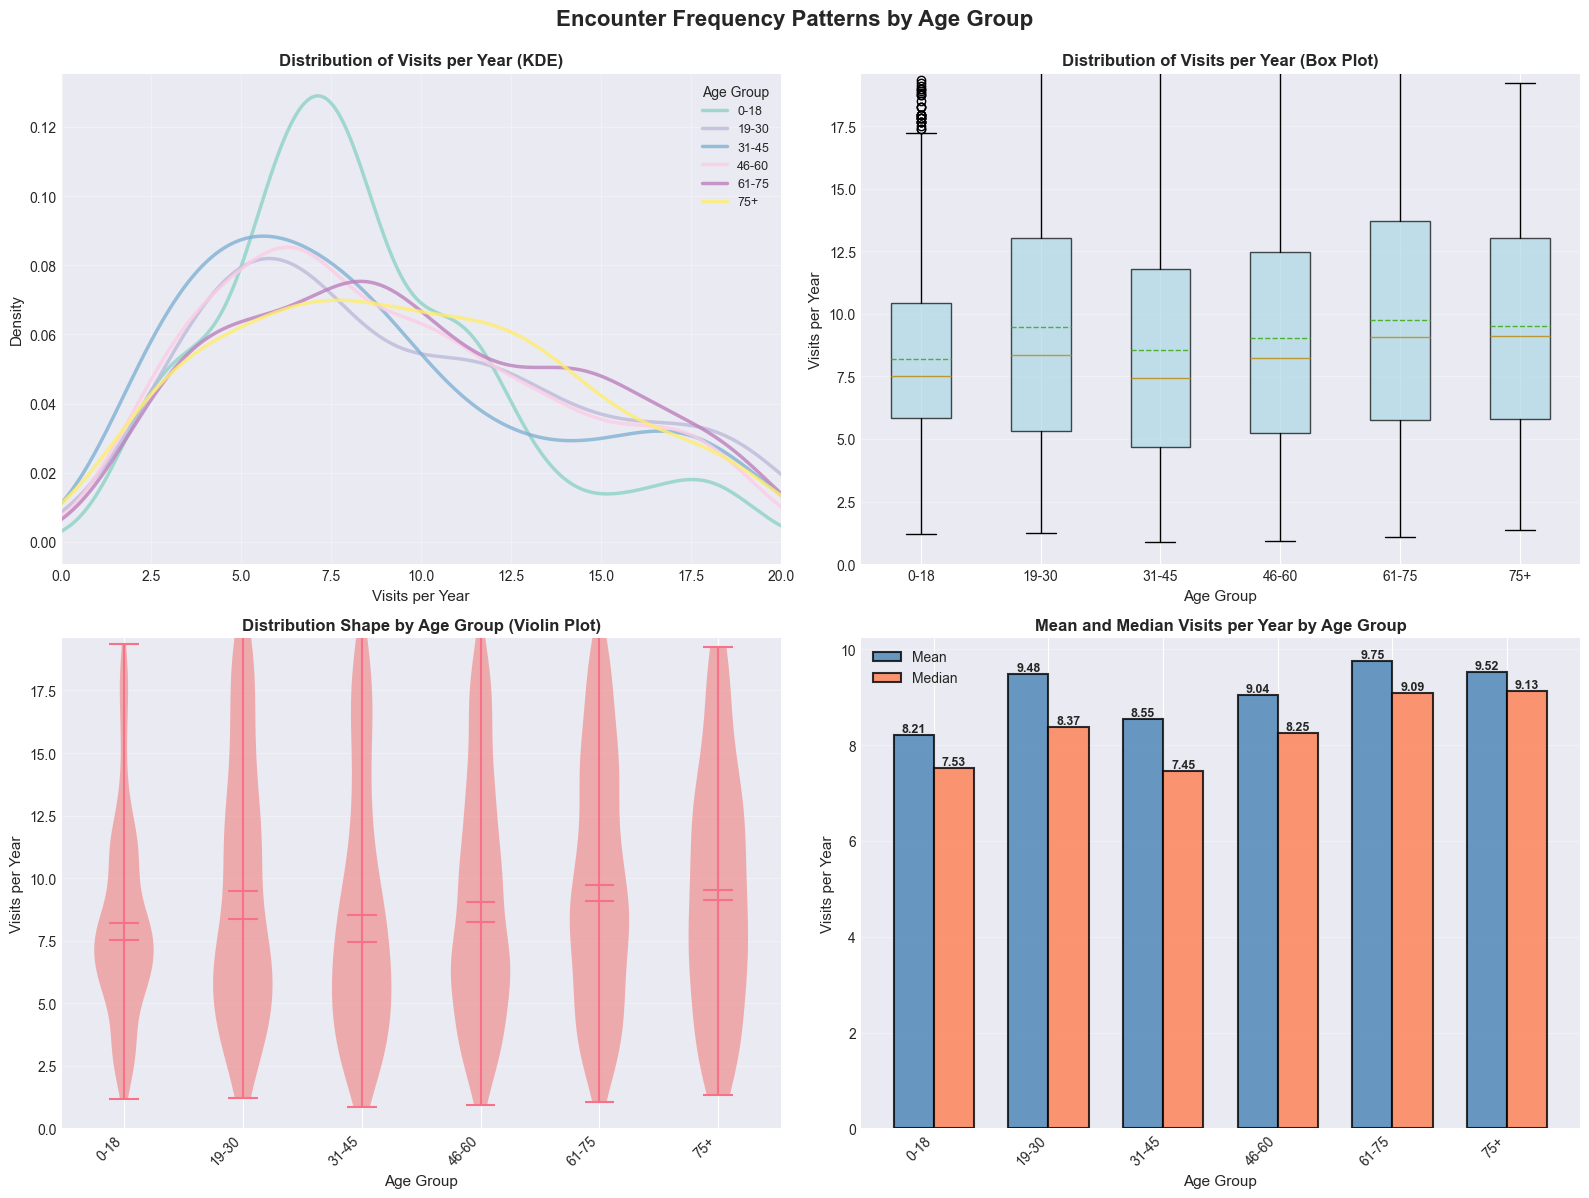

In [26]:
# Additional analysis: Encounter frequency patterns
if encounters_analysis and len(encounters_analysis['multi_visit_patients']) > 0:
    print("\n6. ENCOUNTER FREQUENCY PATTERNS:")
    print("=" * 80)
    
    multi_visit = encounters_analysis['multi_visit_patients'].copy()
    
    # Calculate visits per year for each patient
    multi_visit['visits_per_year'] = multi_visit['total_encounters'] / multi_visit['years_span']
    
    # Frequency categories
    multi_visit['frequency_category'] = pd.cut(
        multi_visit['visits_per_year'],
        bins=[0, 0.5, 1, 2, 4, 10, 100],
        labels=['<0.5/year', '0.5-1/year', '1-2/year', '2-4/year', '4-10/year', '10+/year']
    )
    
    print("\nVisits per year by age group:")
    frequency_by_age = multi_visit.groupby(['primary_age_group', 'frequency_category']).size().unstack(fill_value=0)
    frequency_by_age_pct = frequency_by_age.div(frequency_by_age.sum(axis=1), axis=0) * 100
    display(frequency_by_age_pct.round(2))
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Clean data first
    multi_visit_viz = multi_visit.copy()
    multi_visit_viz['visits_per_year'] = multi_visit_viz['visits_per_year'].replace([np.inf, -np.inf], np.nan)
    multi_visit_viz = multi_visit_viz[multi_visit_viz['visits_per_year'].notna()]
    multi_visit_viz = multi_visit_viz[multi_visit_viz['visits_per_year'] <= 20]  # Limit to 20 for better visualization
    
    # 1. KDE Plot (Kernel Density Estimation) - smoother distribution
    ax1 = axes[0, 0]
    colors = plt.cm.Set3(np.linspace(0, 1, len(multi_visit_viz['primary_age_group'].cat.categories)))
    for idx, age_group in enumerate(multi_visit_viz['primary_age_group'].cat.categories):
        group_data = multi_visit_viz[multi_visit_viz['primary_age_group'] == age_group]['visits_per_year']
        if len(group_data) > 0:
            group_data.plot.kde(ax=ax1, label=age_group, color=colors[idx], linewidth=2.5, alpha=0.8)
    ax1.set_xlabel('Visits per Year', fontsize=11)
    ax1.set_ylabel('Density', fontsize=11)
    ax1.set_title('Distribution of Visits per Year (KDE)', fontsize=12, fontweight='bold')
    ax1.legend(title='Age Group', fontsize=9, loc='upper right')
    ax1.set_xlim(0, 20)
    ax1.grid(True, alpha=0.3)
    
    # 2. Box Plot - shows quartiles and outliers
    ax2 = axes[0, 1]
    age_groups = multi_visit_viz['primary_age_group'].cat.categories
    box_data = [multi_visit_viz[multi_visit_viz['primary_age_group'] == ag]['visits_per_year'].values 
                for ag in age_groups]
    bp = ax2.boxplot(box_data, labels=age_groups, patch_artist=True, 
                    showmeans=True, meanline=True)
    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')
        patch.set_alpha(0.7)
    ax2.set_xlabel('Age Group', fontsize=11)
    ax2.set_ylabel('Visits per Year', fontsize=11)
    ax2.set_title('Distribution of Visits per Year (Box Plot)', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.set_ylim(0, min(20, multi_visit_viz['visits_per_year'].quantile(0.95) * 1.1))
    
    # 3. Violin Plot - shows full distribution shape
    ax3 = axes[1, 0]
    violin_data = []
    violin_labels = []
    for age_group in age_groups:
        group_data = multi_visit_viz[multi_visit_viz['primary_age_group'] == age_group]['visits_per_year']
        if len(group_data) > 0:
            violin_data.append(group_data.values)
            violin_labels.append(age_group)
    
    parts = ax3.violinplot(violin_data, positions=range(len(violin_labels)), 
                           showmeans=True, showmedians=True)
    ax3.set_xticks(range(len(violin_labels)))
    ax3.set_xticklabels(violin_labels, rotation=45, ha='right')
    ax3.set_xlabel('Age Group', fontsize=11)
    ax3.set_ylabel('Visits per Year', fontsize=11)
    ax3.set_title('Distribution Shape by Age Group (Violin Plot)', fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='y')
    ax3.set_ylim(0, min(20, multi_visit_viz['visits_per_year'].quantile(0.95) * 1.1))
    
    # Color the violins
    for pc in parts['bodies']:
        pc.set_facecolor('lightcoral')
        pc.set_alpha(0.6)
    
    # 4. Mean and Median Bar Chart
    ax4 = axes[1, 1]
    # Clean data before calculating stats
    multi_visit_clean = multi_visit_viz.copy()
    visits_per_year_stats = multi_visit_clean.groupby('primary_age_group')['visits_per_year'].agg(['mean', 'median']).reset_index()
    x = np.arange(len(visits_per_year_stats))
    width = 0.35
    bars1 = ax4.bar(x - width/2, visits_per_year_stats['mean'], width, 
                   label='Mean', color='steelblue', alpha=0.8, edgecolor='black', linewidth=1.5)
    bars2 = ax4.bar(x + width/2, visits_per_year_stats['median'], width,
                   label='Median', color='coral', alpha=0.8, edgecolor='black', linewidth=1.5)
    ax4.set_xlabel('Age Group', fontsize=11)
    ax4.set_ylabel('Visits per Year', fontsize=11)
    ax4.set_title('Mean and Median Visits per Year by Age Group', fontsize=12, fontweight='bold')
    ax4.set_xticks(x)
    ax4.set_xticklabels(visits_per_year_stats['primary_age_group'], rotation=45, ha='right')
    ax4.legend(fontsize=10, framealpha=0.9)
    ax4.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    plt.suptitle('Encounter Frequency Patterns by Age Group', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig(VIZ_DIR / 'eda' / 'encounter_frequency_patterns.png', dpi=300, bbox_inches='tight')
    plt.show()


### Age distribution


Age statistics:
  Mean: 48.2 years
  Median: 50.9 years
  Std: 20.4 years
  Min: 0.0 years
  Max: 96.3 years

Age group distribution:
age_group
0-18     3052
19-30    2062
31-45    5065
46-60    7842
61-75    6779
76+      1748
Name: count, dtype: int64


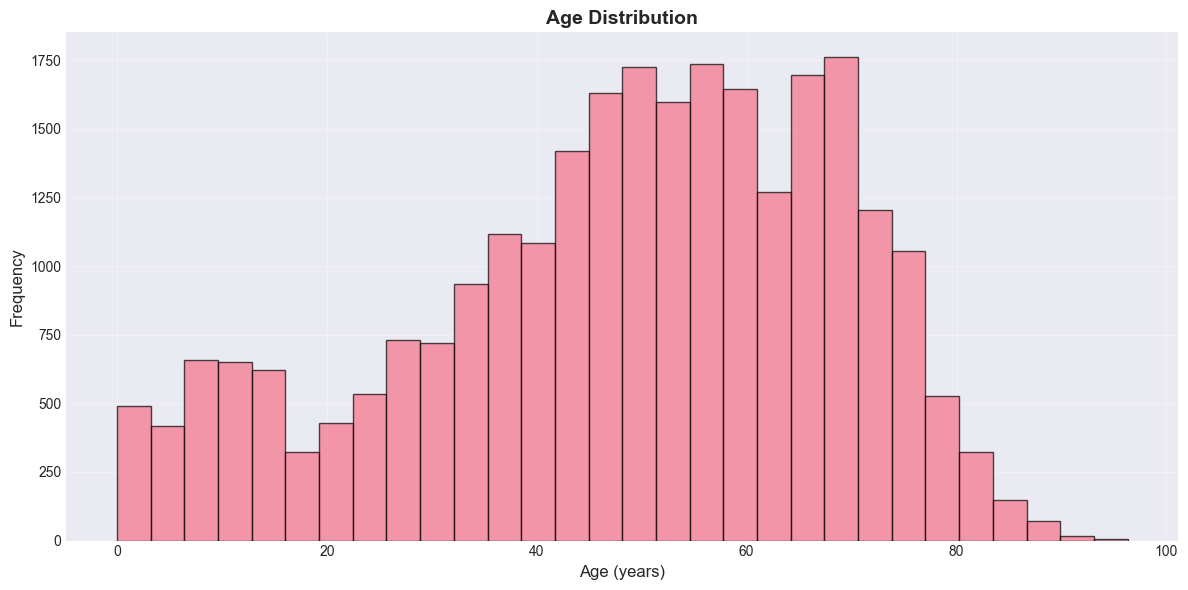

In [27]:
# Age distribution
if 'age' in df.columns:
    age_data = df['age'].dropna()
    print(f"\nAge statistics:")
    print(f"  Mean: {age_data.mean():.1f} years")
    print(f"  Median: {age_data.median():.1f} years")
    print(f"  Std: {age_data.std():.1f} years")
    print(f"  Min: {age_data.min():.1f} years")
    print(f"  Max: {age_data.max():.1f} years")
    
    # Age groups
    df['age_group'] = pd.cut(age_data, 
                              bins=[0, 18, 30, 45, 60, 75, 100],
                              labels=['0-18', '19-30', '31-45', '46-60', '61-75', '76+'])
    age_group_dist = df['age_group'].value_counts().sort_index()
    print(f"\nAge group distribution:\n{age_group_dist}")
    
    # Age distribution histogram
    plt.figure(figsize=(12, 6))
    plt.hist(age_data, bins=30, edgecolor='black', alpha=0.7)
    plt.title('Age Distribution', fontsize=14, fontweight='bold')
    plt.xlabel('Age (years)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(VIZ_DIR / 'eda' / 'age_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()


### Geographic and Temporal Analysis


Top 10 MEP Regions:
mep_region
Nyírkáta MEP régió     7054
Litke MEP régió        5326
Zalakomár MEP régió    4756
Szalonna MEP régió     4269
Hirics MEP régió       2838
Egyéb                  1752
Heves praxis            285
Máltai Iskolák          146
Ápolási intézmények     125
Name: count, dtype: int64


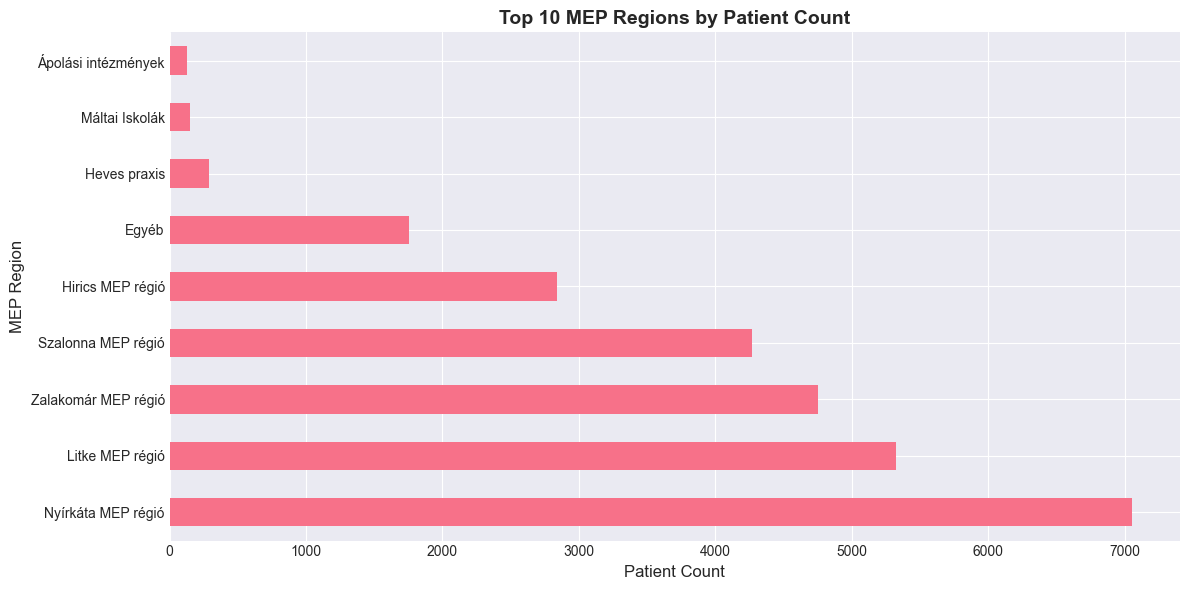


Top 15 Clinics:
clinic_name
Zalakomár rendelő       1904
Nyírkáta rendelő        1570
Szalonna rendelő        1559
Nyírpilis rendelő       1503
Hodász rendelő          1184
Nógrádmegyer rendelő    1180
Sóshartyán rendelő      1172
Hirics rendelő          1094
Litke rendelő            951
Központ rendelő          950
Porcsalma rendelő        926
Gacsály rendelő          868
Szentpéterúr rendelő     730
Martonyi rendelő         566
Gadna rendelő            559
Name: count, dtype: int64


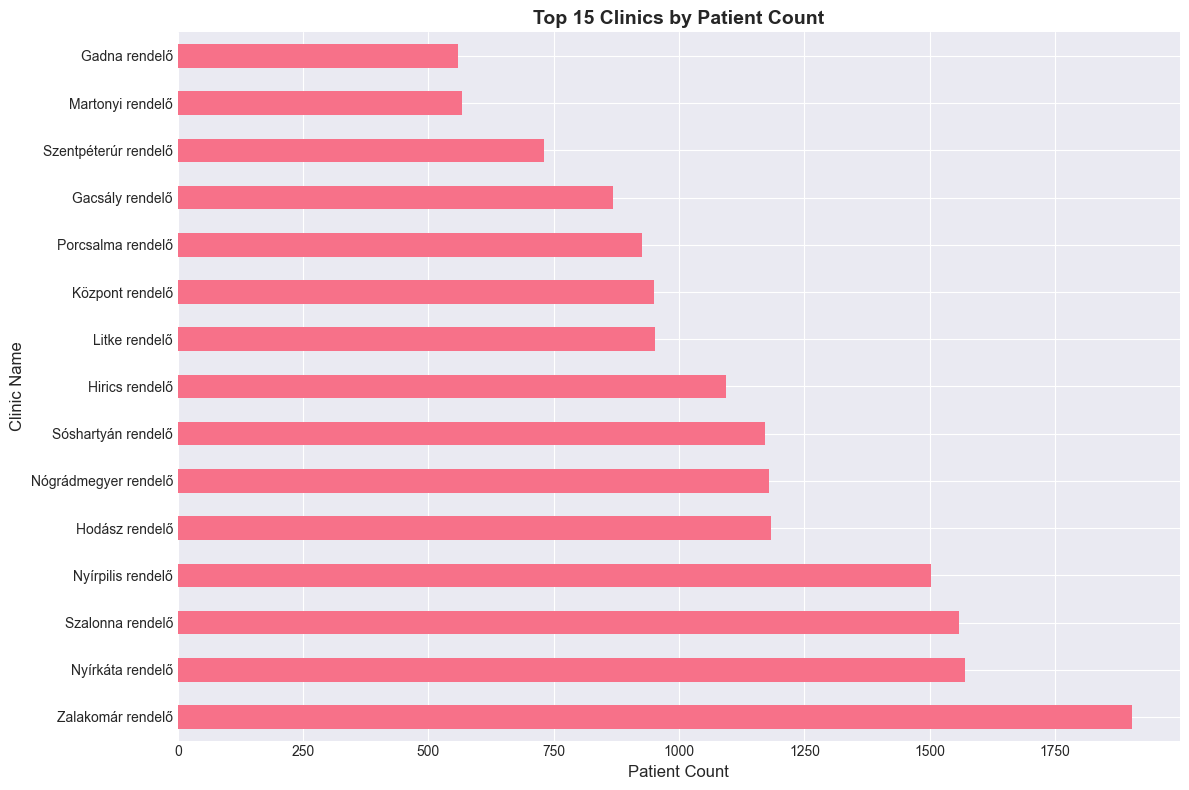

In [28]:
# Geographic distribution
if 'mep_region' in df.columns:
    region_dist = df['mep_region'].value_counts().head(10)
    print(f"Top 10 MEP Regions:\n{region_dist}")
    
    plt.figure(figsize=(12, 6))
    region_dist.plot(kind='barh')
    plt.title('Top 10 MEP Regions by Patient Count', fontsize=14, fontweight='bold')
    plt.xlabel('Patient Count', fontsize=12)
    plt.ylabel('MEP Region', fontsize=12)
    plt.tight_layout()
    plt.savefig(VIZ_DIR / 'eda' / 'mep_regions.png', dpi=300, bbox_inches='tight')
    plt.show()

if 'clinic_name' in df.columns:
    clinic_dist = df['clinic_name'].value_counts().head(15)
    print(f"\nTop 15 Clinics:\n{clinic_dist}")
    
    plt.figure(figsize=(12, 8))
    clinic_dist.plot(kind='barh')
    plt.title('Top 15 Clinics by Patient Count', fontsize=14, fontweight='bold')
    plt.xlabel('Patient Count', fontsize=12)
    plt.ylabel('Clinic Name', fontsize=12)
    plt.tight_layout()
    plt.savefig(VIZ_DIR / 'eda' / 'clinic_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()


Visits by year:
visit_year
2023     6563
2024    10220
2025     9768
Name: count, dtype: int64


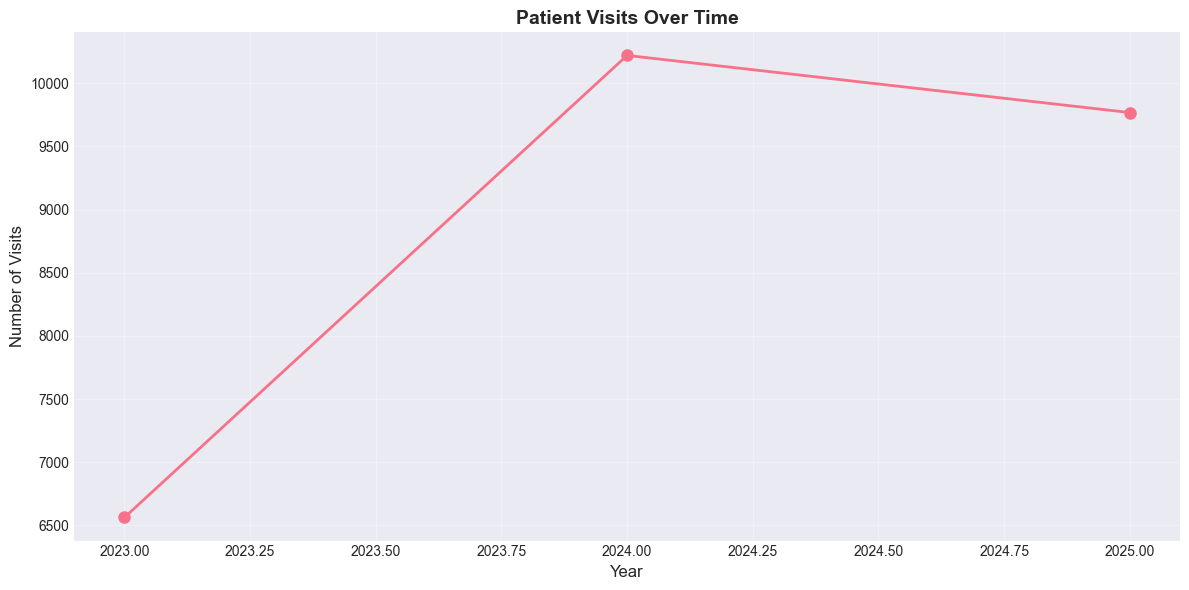

In [29]:
# Temporal patterns
if 'created' in df.columns:
    df['visit_year'] = df['created'].dt.year
    df['visit_month'] = df['created'].dt.month
    df['visit_year_month'] = df['created'].dt.to_period('M')
    
    yearly_visits = df['visit_year'].value_counts().sort_index()
    print(f"Visits by year:\n{yearly_visits}")
    
    plt.figure(figsize=(12, 6))
    yearly_visits.plot(kind='line', marker='o', linewidth=2, markersize=8)
    plt.title('Patient Visits Over Time', fontsize=14, fontweight='bold')
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Number of Visits', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(VIZ_DIR / 'eda' / 'visits_over_time.png', dpi=300, bbox_inches='tight')
    plt.show()


### Clinical Variables Analysis

In [30]:
# Blood pressure analysis
bp_vars = ['bp_systolic', 'bp_diastolic']
for var in bp_vars:
    if var in df.columns:
        data = df[var].dropna()
        if len(data) > 0:
            print(f"\n{var}:")
            print(f"  Mean: {data.mean():.1f}")
            print(f"  Median: {data.median():.1f}")
            print(f"  Std: {data.std():.1f}")
            print(f"  Range: {data.min():.1f} - {data.max():.1f}")

# BMI analysis
bmi_cols = ['cv_screening7_bmi', 'physical3_bmi']
for col in bmi_cols:
    if col in df.columns:
        data = df[col].dropna()
        if len(data) > 0:
            print(f"\n{col}:")
            print(f"  Mean: {data.mean():.2f}")
            print(f"  Median: {data.median():.2f}")
            print(f"  Range: {data.min():.2f} - {data.max():.2f}")

# Create combined BMI column (prefer cv_screening, fallback to physical)
if 'cv_screening7_bmi' in df.columns:
    df['bmi'] = df['cv_screening7_bmi']
elif 'physical3_bmi' in df.columns:
    df['bmi'] = df['physical3_bmi']


bp_systolic:
  Mean: 134.6
  Median: 133.0
  Std: 20.0
  Range: 77.0 - 230.0

bp_diastolic:
  Mean: 85.0
  Median: 84.0
  Std: 23.0
  Range: 4.0 - 830.0

cv_screening7_bmi:
  Mean: 347.23
  Median: 28.84
  Range: 11.46 - 1020000.00

physical3_bmi:
  Mean: 30.80
  Median: 28.46
  Range: 1.46 - 10000.00


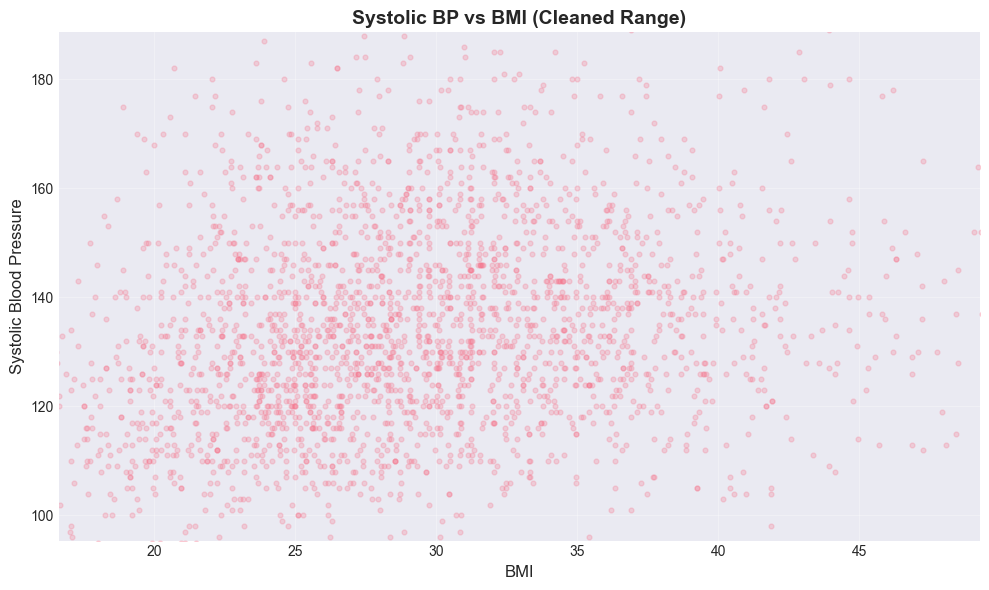

In [31]:
# Simple scatter BP vs BMI (cleaned ranges, like original style)
if 'bp_systolic' in df.columns:
    # Ensure BMI column exists
    if 'bmi' not in df.columns:
        if 'cv_screening7_bmi' in df.columns and df['cv_screening7_bmi'].notna().any():
            df['bmi'] = df['cv_screening7_bmi']
        elif 'physical3_bmi' in df.columns and df['physical3_bmi'].notna().any():
            df['bmi'] = df['physical3_bmi']

if {'bp_systolic','bmi'}.issubset(df.columns):
    temp = df[['bp_systolic','bmi']].apply(pd.to_numeric, errors='coerce')
    temp = temp.replace([np.inf, -np.inf], np.nan).dropna()
    # Clip to plausible ranges
    temp = temp[(temp['bmi'].between(10, 80)) & (temp['bp_systolic'].between(70, 250))]
    if len(temp) > 0:
        # Dynamic limits from data, bounded to reasonable ranges
        xq = temp['bmi'].quantile([0.01, 0.99]).values
        yq = temp['bp_systolic'].quantile([0.01, 0.99]).values
        xmin, xmax = max(10, xq[0]), min(60, xq[1])
        ymin, ymax = max(70, yq[0]), min(200, yq[1])

        plt.figure(figsize=(10,6))
        plt.scatter(temp['bmi'], temp['bp_systolic'], alpha=0.25, s=12)
        plt.xlabel('BMI', fontsize=12)
        plt.ylabel('Systolic Blood Pressure', fontsize=12)
        plt.title('Systolic BP vs BMI (Cleaned Range)', fontsize=14, fontweight='bold')
        plt.xlim(xmin, xmax)
        plt.ylim(ymin, ymax)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(VIZ_DIR / 'eda' / 'bp_vs_bmi_clean.png', dpi=300, bbox_inches='tight')
        plt.show()
    else:
        print('No sufficient valid data in plausible ranges to plot.')


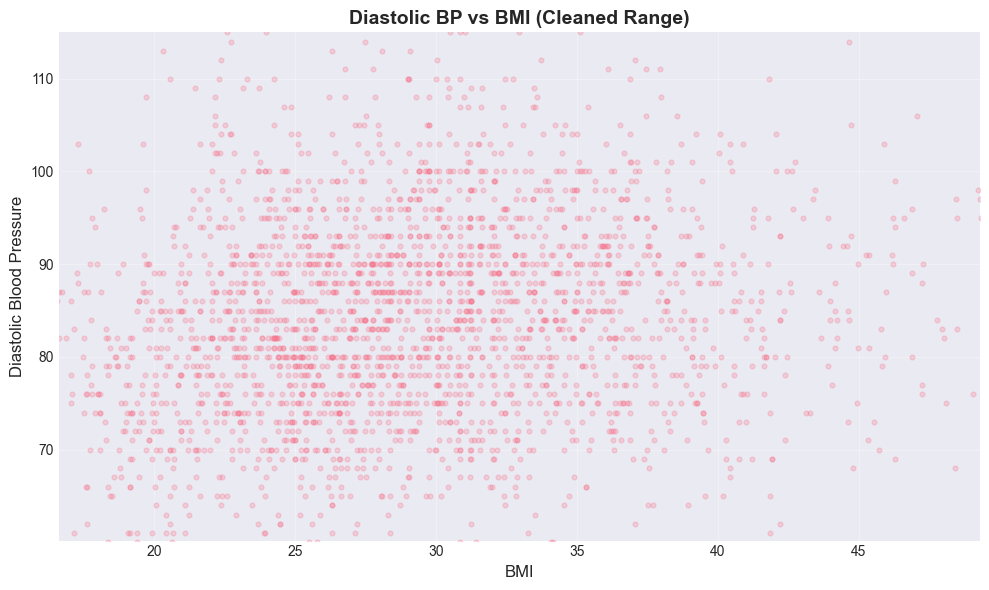

In [32]:
# Scatter: Diastolic BP vs BMI (cleaned ranges)
# Ensure BMI column exists
if 'bmi' not in df.columns:
    if 'cv_screening7_bmi' in df.columns and df['cv_screening7_bmi'].notna().any():
        df['bmi'] = df['cv_screening7_bmi']
    elif 'physical3_bmi' in df.columns and df['physical3_bmi'].notna().any():
        df['bmi'] = df['physical3_bmi']

if {'bp_diastolic','bmi'}.issubset(df.columns):
    temp = df[['bp_diastolic','bmi']].apply(pd.to_numeric, errors='coerce')
    temp = temp.replace([np.inf, -np.inf], np.nan).dropna()
    # Plausible ranges
    temp = temp[(temp['bmi'].between(10, 80)) & (temp['bp_diastolic'].between(40, 150))]
    if len(temp) > 0:
        xq = temp['bmi'].quantile([0.01, 0.99]).values
        yq = temp['bp_diastolic'].quantile([0.01, 0.99]).values
        xmin, xmax = max(10, xq[0]), min(60, xq[1])
        ymin, ymax = max(40, yq[0]), min(120, yq[1])

        plt.figure(figsize=(10,6))
        plt.scatter(temp['bmi'], temp['bp_diastolic'], alpha=0.25, s=12)
        plt.xlabel('BMI', fontsize=12)
        plt.ylabel('Diastolic Blood Pressure', fontsize=12)
        plt.title('Diastolic BP vs BMI (Cleaned Range)', fontsize=14, fontweight='bold')
        plt.xlim(xmin, xmax)
        plt.ylim(ymin, ymax)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(VIZ_DIR / 'eda' / 'bp_diastolic_vs_bmi_clean.png', dpi=300, bbox_inches='tight')
        plt.show()
    else:
        print('No sufficient valid data in plausible ranges to plot (DBP vs BMI).')


            



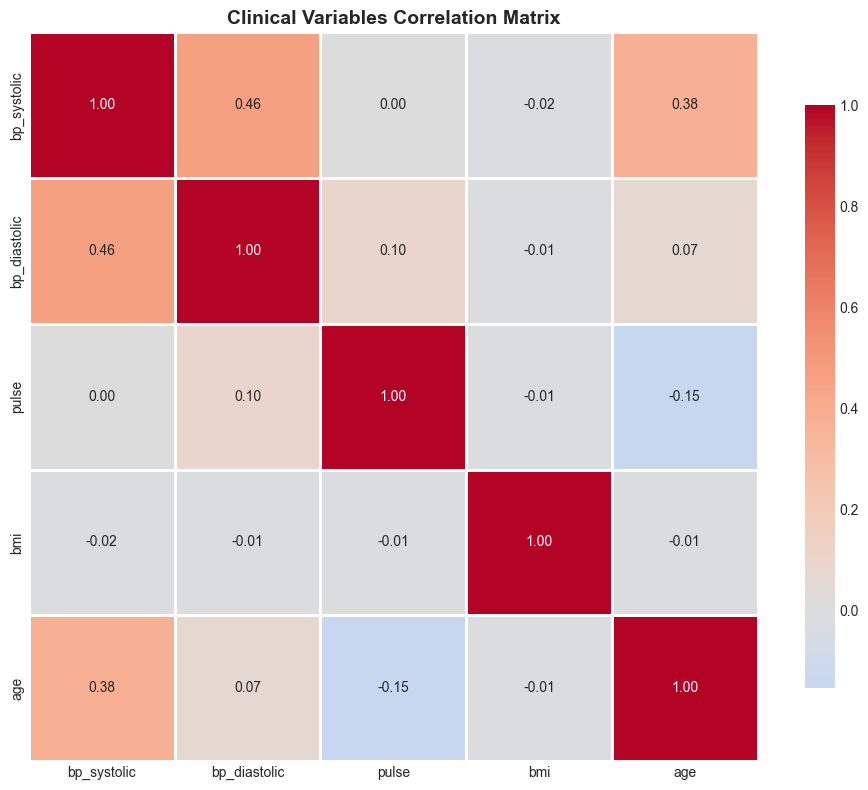

In [33]:
# Correlation heatmap for clinical variables
clinical_vars_for_corr = ['bp_systolic', 'bp_diastolic', 'pulse', 'bmi', 'age']
available_vars = [v for v in clinical_vars_for_corr if v in df.columns]
if len(available_vars) > 1:
    corr_data = df[available_vars].dropna()
    if len(corr_data) > 0:
        corr_matrix = corr_data.corr()
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                    square=True, linewidths=1, cbar_kws={"shrink": 0.8})
        plt.title('Clinical Variables Correlation Matrix', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig(VIZ_DIR / 'eda' / 'clinical_correlation.png', dpi=300, bbox_inches='tight')
        plt.show()


### I10 (Essential/Primary Hypertension) - Clinical Variables Analysis


In [34]:
# Analyze I10 (Essential/Primary Hypertension) - Clinical variables availability
if 'icd3_code' in df.columns:
    i10_df = df[df['icd3_code'] == 'I10'].copy()
    all_df = df.copy()
    
    print("=" * 80)
    print("I10 (Essential/Primary Hypertension) - Clinical Variables Analysis")
    print("=" * 80)
    print(f"\nTotal I10 records: {len(i10_df):,}")
    print(f"Total records in dataset: {len(all_df):,}")
    
    # Define potentially relevant clinical variables for hypertension
    hypertension_relevant_vars = [
        # Blood pressure - most relevant for hypertension
        'bp_systolic',
        'bp_diastolic',
        'bp_systolic2',
        'bp_diastolic2',
        'bp_systolic_temp',
        # Cardiovascular measurements
        'pulse',
        'cv_screening2_bp',
        'cv_screening5_height',
        'cv_screening6_weight',
        'cv_screening7_bmi',
        'cv_screening8_waist_circumference',
        # Physical measurements
        'physical1_height',
        'physical2_weight',
        'physical3_bmi',
        'physical4_waist_circumference',
        # EKG - hypertension affects heart
        'ekg1_description',
        'ekg2_unknown',
        'ekg3_unknown',
        # Specialty - cardiology/internal medicine
        'specialty_name',
        # Medications - antihypertensive medications
        'prescribed_medication',
        'prescribed_medication_atc',
        'prescribed_medication_active_ingredient',
        # Cardiovascular screening
        'cv_screening1_unknown',
        'cv_screening3_unknown',
        'cv_screening4_unknown',
        # Other cardiovascular measurements
        'measurements_diabetes_data',
        'measurements_arteriography_data',
        'extended_bp1_unknown',
        'extended_bp2_unknown'
    ]
    
    # Filter to only variables that exist in the dataset
    available_vars = [v for v in hypertension_relevant_vars if v in df.columns]
    
    print(f"\nRelevant clinical variables for hypertension: {len(available_vars)}")
    print(f"Variables checked: {', '.join(available_vars)}")
    
    # Calculate non-empty percentages
    results = []
    for var in available_vars:
        i10_non_empty = i10_df[var].notna().sum()
        i10_total = len(i10_df)
        i10_pct = (i10_non_empty / i10_total * 100) if i10_total > 0 else 0
        
        all_non_empty = all_df[var].notna().sum()
        all_total = len(all_df)
        all_pct = (all_non_empty / all_total * 100) if all_total > 0 else 0
        
        # For string columns, also check if empty strings
        if i10_df[var].dtype == 'object':
            i10_non_empty = ((i10_df[var].notna()) & (i10_df[var] != '')).sum()
            i10_pct = (i10_non_empty / i10_total * 100) if i10_total > 0 else 0
            all_non_empty = ((all_df[var].notna()) & (all_df[var] != '')).sum()
            all_pct = (all_non_empty / all_total * 100) if all_total > 0 else 0
        
        results.append({
            'Variable': var,
            'I10_Non_Empty_Count': i10_non_empty,
            'I10_Total': i10_total,
            'I10_Percentage': i10_pct,
            'All_Non_Empty_Count': all_non_empty,
            'All_Total': all_total,
            'All_Percentage': all_pct,
            'Difference': i10_pct - all_pct
        })
    
    results_df_i10 = pd.DataFrame(results)
    results_df_i10 = results_df_i10.sort_values('I10_Percentage', ascending=False)
    
    print("\n" + "=" * 80)
    print("NON-EMPTY ROW PERCENTAGES: I10 vs All Patients")
    print("=" * 80)
    display(results_df_i10.round(2))
    
    # Highlight blood pressure variables (most relevant for hypertension)
    print("\n" + "-" * 80)
    print("BLOOD PRESSURE VARIABLES (Most relevant for hypertension):")
    print("-" * 80)
    bp_vars = [v for v in available_vars if 'bp' in v.lower()]
    if bp_vars:
        display(results_df_i10[results_df_i10['Variable'].isin(bp_vars)].round(2))
    
    # Highlight cardiovascular screening variables
    print("\n" + "-" * 80)
    print("CARDIOVASCULAR SCREENING VARIABLES:")
    print("-" * 80)
    cv_vars = [v for v in available_vars if 'cv_screening' in v.lower()]
    if cv_vars:
        display(results_df_i10[results_df_i10['Variable'].isin(cv_vars)].round(2))
    
    # Save results
    results_df_i10.to_csv(DATA_DIR / 'i10_clinical_variables_analysis.csv', index=False)
    print(f"\n✓ Saved detailed results to: {DATA_DIR / 'i10_clinical_variables_analysis.csv'}")


I10 (Essential/Primary Hypertension) - Clinical Variables Analysis

Total I10 records: 2,260
Total records in dataset: 26,551

Relevant clinical variables for hypertension: 29
Variables checked: bp_systolic, bp_diastolic, bp_systolic2, bp_diastolic2, bp_systolic_temp, pulse, cv_screening2_bp, cv_screening5_height, cv_screening6_weight, cv_screening7_bmi, cv_screening8_waist_circumference, physical1_height, physical2_weight, physical3_bmi, physical4_waist_circumference, ekg1_description, ekg2_unknown, ekg3_unknown, specialty_name, prescribed_medication, prescribed_medication_atc, prescribed_medication_active_ingredient, cv_screening1_unknown, cv_screening3_unknown, cv_screening4_unknown, measurements_diabetes_data, measurements_arteriography_data, extended_bp1_unknown, extended_bp2_unknown

NON-EMPTY ROW PERCENTAGES: I10 vs All Patients


,Variable,I10_Non_Empty_Count,I10_Total,I10_Percentage,All_Non_Empty_Count,All_Total,All_Percentage,Difference
18,specialty_name,2260,2260,100.00,26551,26551,100.00,0.00
19,prescribed_medication,879,2260,38.89,6696,26551,25.22,13.67
20,prescribed_medication_atc,877,2260,38.81,6684,26551,25.17,13.63
21,prescribed_medication_active_ingredient,875,2260,38.72,6653,26551,25.06,13.66
5,pulse,853,2260,37.74,8515,26551,32.07,5.67
4,bp_systolic_temp,810,2260,35.84,8309,26551,31.29,4.55
0,bp_systolic,810,2260,35.84,8309,26551,31.29,4.55
1,bp_diastolic,804,2260,35.58,8244,26551,31.05,4.53
2,bp_systolic2,461,2260,20.40,4991,26551,18.80,1.60
11,physical1_height,459,2260,20.31,6323,26551,23.81,-3.50



--------------------------------------------------------------------------------
BLOOD PRESSURE VARIABLES (Most relevant for hypertension):
--------------------------------------------------------------------------------


,Variable,I10_Non_Empty_Count,I10_Total,I10_Percentage,All_Non_Empty_Count,All_Total,All_Percentage,Difference
4,bp_systolic_temp,810,2260,35.84,8309,26551,31.29,4.55
0,bp_systolic,810,2260,35.84,8309,26551,31.29,4.55
1,bp_diastolic,804,2260,35.58,8244,26551,31.05,4.53
2,bp_systolic2,461,2260,20.40,4991,26551,18.80,1.60
3,bp_diastolic2,453,2260,20.04,4886,26551,18.40,1.64
6,cv_screening2_bp,226,2260,10.00,3017,26551,11.36,-1.36
27,extended_bp1_unknown,1,2260,0.04,16,26551,0.06,-0.02
28,extended_bp2_unknown,1,2260,0.04,20,26551,0.08,-0.03



--------------------------------------------------------------------------------
CARDIOVASCULAR SCREENING VARIABLES:
--------------------------------------------------------------------------------


,Variable,I10_Non_Empty_Count,I10_Total,I10_Percentage,All_Non_Empty_Count,All_Total,All_Percentage,Difference
24,cv_screening4_unknown,249,2260,11.02,3399,26551,12.80,-1.78
23,cv_screening3_unknown,249,2260,11.02,3400,26551,12.81,-1.79
7,cv_screening5_height,233,2260,10.31,3241,26551,12.21,-1.90
8,cv_screening6_weight,233,2260,10.31,3232,26551,12.17,-1.86
9,cv_screening7_bmi,233,2260,10.31,3242,26551,12.21,-1.90
6,cv_screening2_bp,226,2260,10.00,3017,26551,11.36,-1.36
10,cv_screening8_waist_circumference,222,2260,9.82,3028,26551,11.40,-1.58
22,cv_screening1_unknown,209,2260,9.25,2863,26551,10.78,-1.54



✓ Saved detailed results to: outputs\data\i10_clinical_variables_analysis.csv


In [35]:
# Check BP values distribution for I10 patients
if 'bp_systolic' in df.columns and 'bp_diastolic' in df.columns and 'icd3_code' in df.columns:
    i10_bp = df[(df['icd3_code'] == 'I10')].copy()
    i10_bp['bp_systolic'] = pd.to_numeric(i10_bp['bp_systolic'], errors='coerce')
    i10_bp['bp_diastolic'] = pd.to_numeric(i10_bp['bp_diastolic'], errors='coerce')
    i10_bp = i10_bp[i10_bp['bp_systolic'].between(70, 250) & i10_bp['bp_diastolic'].between(40, 150)]
    
    print("\n" + "=" * 80)
    print("BLOOD PRESSURE STATISTICS FOR I10 PATIENTS")
    print("=" * 80)
    
    if len(i10_bp) > 0:
        print(f"\nI10 records with valid BP data: {len(i10_bp):,}")
        
        # BP statistics
        bp_stats = {
            'Systolic BP': {
                'Mean': i10_bp['bp_systolic'].mean(),
                'Median': i10_bp['bp_systolic'].median(),
                'Std': i10_bp['bp_systolic'].std(),
                'Min': i10_bp['bp_systolic'].min(),
                'Max': i10_bp['bp_systolic'].max(),
                'Q25': i10_bp['bp_systolic'].quantile(0.25),
                'Q75': i10_bp['bp_systolic'].quantile(0.75)
            },
            'Diastolic BP': {
                'Mean': i10_bp['bp_diastolic'].mean(),
                'Median': i10_bp['bp_diastolic'].median(),
                'Std': i10_bp['bp_diastolic'].std(),
                'Min': i10_bp['bp_diastolic'].min(),
                'Max': i10_bp['bp_diastolic'].max(),
                'Q25': i10_bp['bp_diastolic'].quantile(0.25),
                'Q75': i10_bp['bp_diastolic'].quantile(0.75)
            }
        }
        
        bp_stats_df = pd.DataFrame(bp_stats).T
        display(bp_stats_df.round(2))
        
        # Hypertension staging
        i10_bp['htn_stage'] = 'Normal'
        i10_bp.loc[(i10_bp['bp_systolic'] >= 140) | (i10_bp['bp_diastolic'] >= 90), 'htn_stage'] = 'Stage 1 (≥140/90)'
        i10_bp.loc[(i10_bp['bp_systolic'] >= 160) | (i10_bp['bp_diastolic'] >= 100), 'htn_stage'] = 'Stage 2 (≥160/100)'
        
        htn_staging = i10_bp['htn_stage'].value_counts()
        print("\nHypertension Staging in I10 patients:")
        print("-" * 80)
        for stage, count in htn_staging.items():
            pct = (count / len(i10_bp) * 100) if len(i10_bp) > 0 else 0
            print(f"  {stage}: {count:,} ({pct:.1f}%)")
    else:
        print("No valid BP data found for I10 patients")



BLOOD PRESSURE STATISTICS FOR I10 PATIENTS

I10 records with valid BP data: 802


,Mean,Median,Std,Min,Max,Q25,Q75
Systolic BP,143.46,142.5,21.03,77.0,224.0,130.0,156.0
Diastolic BP,88.19,87.0,12.51,57.0,137.0,80.0,95.0



Hypertension Staging in I10 patients:
--------------------------------------------------------------------------------
  Normal: 307 (38.3%)
  Stage 1 (≥140/90): 278 (34.7%)
  Stage 2 (≥160/100): 217 (27.1%)


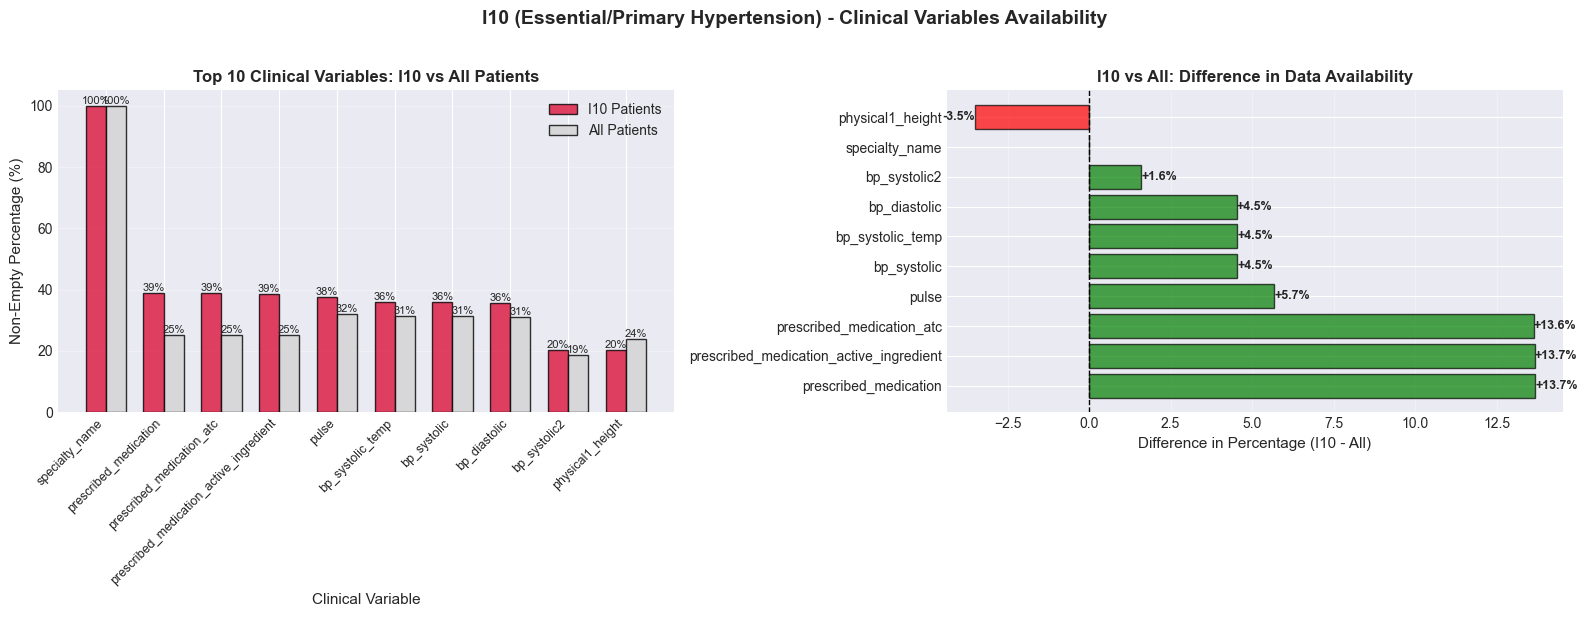

In [36]:
# Visualization: I10 vs All Patients - Clinical Variables Availability
if 'results_df_i10' in locals() and len(results_df_i10) > 0:
    # Top 10 variables by I10 percentage
    top10_i10 = results_df_i10.head(10)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # 1. Comparison bar chart
    ax1 = axes[0]
    x = np.arange(len(top10_i10))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, top10_i10['I10_Percentage'], width, 
                   label='I10 Patients', color='crimson', alpha=0.8, edgecolor='black')
    bars2 = ax1.bar(x + width/2, top10_i10['All_Percentage'], width,
                   label='All Patients', color='lightgray', alpha=0.8, edgecolor='black')
    
    ax1.set_xlabel('Clinical Variable', fontsize=11)
    ax1.set_ylabel('Non-Empty Percentage (%)', fontsize=11)
    ax1.set_title('Top 10 Clinical Variables: I10 vs All Patients', fontsize=12, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(top10_i10['Variable'], rotation=45, ha='right', fontsize=9)
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.set_ylim(0, 105)
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            if height > 5:  # Only label if significant
                ax1.text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:.0f}%', ha='center', va='bottom', fontsize=8)
    
    # 2. Difference chart (I10 - All)
    ax2 = axes[1]
    top10_diff = top10_i10.sort_values('Difference', ascending=False)
    colors_diff = ['green' if x > 0 else 'red' for x in top10_diff['Difference']]
    bars3 = ax2.barh(top10_diff['Variable'], top10_diff['Difference'], 
                    color=colors_diff, alpha=0.7, edgecolor='black')
    ax2.set_xlabel('Difference in Percentage (I10 - All)', fontsize=11)
    ax2.set_title('I10 vs All: Difference in Data Availability', fontsize=12, fontweight='bold')
    ax2.axvline(x=0, color='black', linestyle='--', linewidth=1)
    ax2.grid(True, alpha=0.3, axis='x')
    
    # Add value labels
    for bar in bars3:
        width_bar = bar.get_width()
        if abs(width_bar) > 1:  # Only label if significant difference
            ax2.text(width_bar, bar.get_y() + bar.get_height()/2.,
                    f'{width_bar:+.1f}%', ha='left' if width_bar > 0 else 'right', 
                    va='center', fontsize=9, fontweight='bold')
    
    plt.suptitle('I10 (Essential/Primary Hypertension) - Clinical Variables Availability', 
                fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(VIZ_DIR / 'eda' / 'i10_clinical_variables_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()


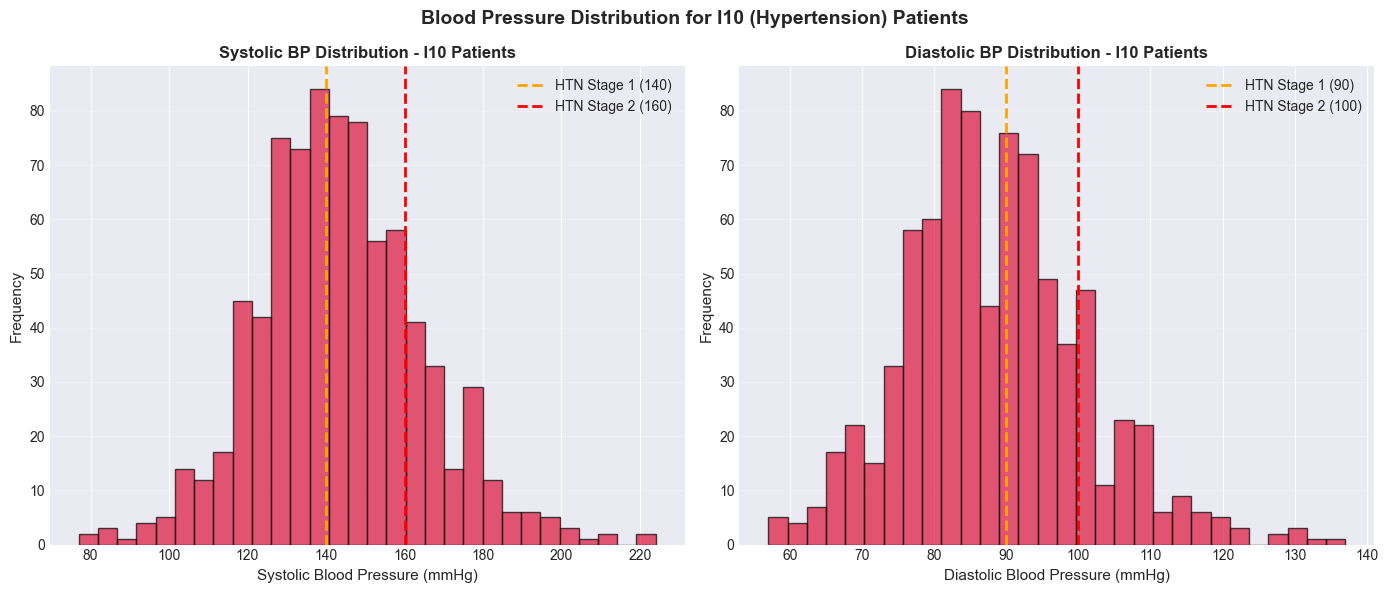

In [37]:
# Additional visualization: BP distribution for I10 patients
if 'bp_systolic' in df.columns and 'bp_diastolic' in df.columns and 'icd3_code' in df.columns:
    i10_bp_clean = df[(df['icd3_code'] == 'I10')].copy()
    i10_bp_clean['bp_systolic'] = pd.to_numeric(i10_bp_clean['bp_systolic'], errors='coerce')
    i10_bp_clean['bp_diastolic'] = pd.to_numeric(i10_bp_clean['bp_diastolic'], errors='coerce')
    i10_bp_clean = i10_bp_clean[i10_bp_clean['bp_systolic'].between(70, 250) & 
                                 i10_bp_clean['bp_diastolic'].between(40, 150)]
    
    if len(i10_bp_clean) > 0:
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        # 1. Histogram of systolic BP
        ax1 = axes[0]
        ax1.hist(i10_bp_clean['bp_systolic'].dropna(), bins=30, color='crimson', alpha=0.7, edgecolor='black')
        ax1.axvline(140, color='orange', linestyle='--', linewidth=2, label='HTN Stage 1 (140)')
        ax1.axvline(160, color='red', linestyle='--', linewidth=2, label='HTN Stage 2 (160)')
        ax1.set_xlabel('Systolic Blood Pressure (mmHg)', fontsize=11)
        ax1.set_ylabel('Frequency', fontsize=11)
        ax1.set_title('Systolic BP Distribution - I10 Patients', fontsize=12, fontweight='bold')
        ax1.legend()
        ax1.grid(True, alpha=0.3, axis='y')
        
        # 2. Histogram of diastolic BP
        ax2 = axes[1]
        ax2.hist(i10_bp_clean['bp_diastolic'].dropna(), bins=30, color='crimson', alpha=0.7, edgecolor='black')
        ax2.axvline(90, color='orange', linestyle='--', linewidth=2, label='HTN Stage 1 (90)')
        ax2.axvline(100, color='red', linestyle='--', linewidth=2, label='HTN Stage 2 (100)')
        ax2.set_xlabel('Diastolic Blood Pressure (mmHg)', fontsize=11)
        ax2.set_ylabel('Frequency', fontsize=11)
        ax2.set_title('Diastolic BP Distribution - I10 Patients', fontsize=12, fontweight='bold')
        ax2.legend()
        ax2.grid(True, alpha=0.3, axis='y')
        
        plt.suptitle('Blood Pressure Distribution for I10 (Hypertension) Patients', 
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig(VIZ_DIR / 'eda' / 'i10_bp_distribution.png', dpi=300, bbox_inches='tight')
        plt.show()


### E11 (Type 2 Diabetes Mellitus) - Clinical Variables Analysis


In [38]:
# Analyze E11 (Type 2 Diabetes Mellitus) - Clinical variables availability
if 'icd3_code' in df.columns:
    e11_df = df[df['icd3_code'] == 'E11'].copy()
    all_df = df.copy()
    
    print("=" * 80)
    print("E11 (Type 2 Diabetes Mellitus) - Clinical Variables Analysis")
    print("=" * 80)
    print(f"\nTotal E11 records: {len(e11_df):,}")
    print(f"Total records in dataset: {len(all_df):,}")
    
    # Define potentially relevant clinical variables for diabetes
    diabetes_relevant_vars = [
        # Blood glucose/diabetes measurements - most relevant
        'measurements_diabetes_data',
        # Anthropometrics - BMI/weight crucial for diabetes
        'cv_screening5_height',
        'cv_screening6_weight',
        'cv_screening7_bmi',
        'cv_screening8_waist_circumference',
        'physical1_height',
        'physical2_weight',
        'physical3_bmi',
        'physical4_waist_circumference',
        # Blood pressure - diabetes increases cardiovascular risk
        'bp_systolic',
        'bp_diastolic',
        'bp_systolic2',
        'bp_diastolic2',
        'bp_systolic_temp',
        # Cardiovascular measurements
        'pulse',
        'cv_screening2_bp',
        'cv_screening1_unknown',
        'cv_screening3_unknown',
        'cv_screening4_unknown',
        # Medications - diabetes medications
        'prescribed_medication',
        'prescribed_medication_atc',
        'prescribed_medication_active_ingredient',
        # Specialty - endocrinology/diabetology
        'specialty_name',
        # Other measurements
        'ekg1_description',
        'measurements_arteriography_data',
        'pulse_oximetry1_saturation',
        'pulse_oximetry2_pulse'
    ]
    
    # Filter to only variables that exist in the dataset
    available_vars = [v for v in diabetes_relevant_vars if v in df.columns]
    
    print(f"\nRelevant clinical variables for diabetes: {len(available_vars)}")
    print(f"Variables checked: {', '.join(available_vars)}")
    
    # Calculate non-empty percentages
    results = []
    for var in available_vars:
        e11_non_empty = e11_df[var].notna().sum()
        e11_total = len(e11_df)
        e11_pct = (e11_non_empty / e11_total * 100) if e11_total > 0 else 0
        
        all_non_empty = all_df[var].notna().sum()
        all_total = len(all_df)
        all_pct = (all_non_empty / all_total * 100) if all_total > 0 else 0
        
        # For string columns, also check if empty strings
        if e11_df[var].dtype == 'object':
            e11_non_empty = ((e11_df[var].notna()) & (e11_df[var] != '')).sum()
            e11_pct = (e11_non_empty / e11_total * 100) if e11_total > 0 else 0
            all_non_empty = ((all_df[var].notna()) & (all_df[var] != '')).sum()
            all_pct = (all_non_empty / all_total * 100) if all_total > 0 else 0
        
        results.append({
            'Variable': var,
            'E11_Non_Empty_Count': e11_non_empty,
            'E11_Total': e11_total,
            'E11_Percentage': e11_pct,
            'All_Non_Empty_Count': all_non_empty,
            'All_Total': all_total,
            'All_Percentage': all_pct,
            'Difference': e11_pct - all_pct
        })
    
    results_df_e11 = pd.DataFrame(results)
    results_df_e11 = results_df_e11.sort_values('E11_Percentage', ascending=False)
    
    print("\n" + "=" * 80)
    print("NON-EMPTY ROW PERCENTAGES: E11 vs All Patients")
    print("=" * 80)
    display(results_df_e11.round(2))
    
    # Highlight diabetes-specific variables
    print("\n" + "-" * 80)
    print("DIABETES-SPECIFIC VARIABLES (Most relevant for diabetes):")
    print("-" * 80)
    diabetes_vars = [v for v in available_vars if 'diabetes' in v.lower()]
    if diabetes_vars:
        display(results_df_e11[results_df_e11['Variable'].isin(diabetes_vars)].round(2))
    
    # Highlight BMI/weight variables (crucial for diabetes)
    print("\n" + "-" * 80)
    print("BMI/WEIGHT VARIABLES (Important for diabetes management):")
    print("-" * 80)
    bmi_vars = [v for v in available_vars if 'bmi' in v.lower() or 'weight' in v.lower() or 'waist' in v.lower()]
    if bmi_vars:
        display(results_df_e11[results_df_e11['Variable'].isin(bmi_vars)].round(2))
    
    # Highlight blood pressure variables (diabetes increases CV risk)
    print("\n" + "-" * 80)
    print("BLOOD PRESSURE VARIABLES (Diabetes increases cardiovascular risk):")
    print("-" * 80)
    bp_vars = [v for v in available_vars if 'bp' in v.lower()]
    if bp_vars:
        display(results_df_e11[results_df_e11['Variable'].isin(bp_vars)].round(2))
    
    # Save results
    results_df_e11.to_csv(DATA_DIR / 'e11_clinical_variables_analysis.csv', index=False)
    print(f"\n✓ Saved detailed results to: {DATA_DIR / 'e11_clinical_variables_analysis.csv'}")


E11 (Type 2 Diabetes Mellitus) - Clinical Variables Analysis

Total E11 records: 462
Total records in dataset: 26,551

Relevant clinical variables for diabetes: 27
Variables checked: measurements_diabetes_data, cv_screening5_height, cv_screening6_weight, cv_screening7_bmi, cv_screening8_waist_circumference, physical1_height, physical2_weight, physical3_bmi, physical4_waist_circumference, bp_systolic, bp_diastolic, bp_systolic2, bp_diastolic2, bp_systolic_temp, pulse, cv_screening2_bp, cv_screening1_unknown, cv_screening3_unknown, cv_screening4_unknown, prescribed_medication, prescribed_medication_atc, prescribed_medication_active_ingredient, specialty_name, ekg1_description, measurements_arteriography_data, pulse_oximetry1_saturation, pulse_oximetry2_pulse

NON-EMPTY ROW PERCENTAGES: E11 vs All Patients


,Variable,E11_Non_Empty_Count,E11_Total,E11_Percentage,All_Non_Empty_Count,All_Total,All_Percentage,Difference
22,specialty_name,462,462,100.00,26551,26551,100.00,0.00
19,prescribed_medication,148,462,32.03,6696,26551,25.22,6.82
21,prescribed_medication_active_ingredient,148,462,32.03,6653,26551,25.06,6.98
20,prescribed_medication_atc,147,462,31.82,6684,26551,25.17,6.64
9,bp_systolic,100,462,21.65,8309,26551,31.29,-9.65
13,bp_systolic_temp,100,462,21.65,8309,26551,31.29,-9.65
14,pulse,100,462,21.65,8515,26551,32.07,-10.43
10,bp_diastolic,100,462,21.65,8244,26551,31.05,-9.40
5,physical1_height,66,462,14.29,6323,26551,23.81,-9.53
7,physical3_bmi,66,462,14.29,6318,26551,23.80,-9.51



--------------------------------------------------------------------------------
DIABETES-SPECIFIC VARIABLES (Most relevant for diabetes):
--------------------------------------------------------------------------------


,Variable,E11_Non_Empty_Count,E11_Total,E11_Percentage,All_Non_Empty_Count,All_Total,All_Percentage,Difference
0,measurements_diabetes_data,0,462,0.0,4,26551,0.02,-0.02



--------------------------------------------------------------------------------
BMI/WEIGHT VARIABLES (Important for diabetes management):
--------------------------------------------------------------------------------


,Variable,E11_Non_Empty_Count,E11_Total,E11_Percentage,All_Non_Empty_Count,All_Total,All_Percentage,Difference
7,physical3_bmi,66,462,14.29,6318,26551,23.80,-9.51
6,physical2_weight,59,462,12.77,5805,26551,21.86,-9.09
8,physical4_waist_circumference,40,462,8.66,4472,26551,16.84,-8.19
3,cv_screening7_bmi,35,462,7.58,3242,26551,12.21,-4.63
2,cv_screening6_weight,33,462,7.14,3232,26551,12.17,-5.03
4,cv_screening8_waist_circumference,29,462,6.28,3028,26551,11.40,-5.13



--------------------------------------------------------------------------------
BLOOD PRESSURE VARIABLES (Diabetes increases cardiovascular risk):
--------------------------------------------------------------------------------


,Variable,E11_Non_Empty_Count,E11_Total,E11_Percentage,All_Non_Empty_Count,All_Total,All_Percentage,Difference
9,bp_systolic,100,462,21.65,8309,26551,31.29,-9.65
13,bp_systolic_temp,100,462,21.65,8309,26551,31.29,-9.65
10,bp_diastolic,100,462,21.65,8244,26551,31.05,-9.40
12,bp_diastolic2,46,462,9.96,4886,26551,18.40,-8.45
11,bp_systolic2,46,462,9.96,4991,26551,18.80,-8.84
15,cv_screening2_bp,29,462,6.28,3017,26551,11.36,-5.09



✓ Saved detailed results to: outputs\data\e11_clinical_variables_analysis.csv


In [39]:
# Check diabetes-specific measurements and BMI/BP for E11 patients
if 'measurements_diabetes_data' in df.columns and 'icd3_code' in df.columns:
    e11_diabetes = df[(df['icd3_code'] == 'E11') & (df['measurements_diabetes_data'].notna()) & (df['measurements_diabetes_data'] != '')]
    
    print("\n" + "=" * 80)
    print("DIABETES-SPECIFIC MEASUREMENTS FOR E11")
    print("=" * 80)
    print(f"\nE11 records with diabetes measurement data: {len(e11_diabetes):,}")
    
    if len(e11_diabetes) > 0:
        # Sample diabetes data
        print("\nSample diabetes measurement data (first 5 unique values):")
        print("-" * 80)
        unique_values = e11_diabetes['measurements_diabetes_data'].dropna().unique()[:5]
        for idx, val in enumerate(unique_values, 1):
            count = (e11_diabetes['measurements_diabetes_data'] == val).sum()
            print(f"{idx}. Value: {str(val)[:100]}... (appears {count} times)")

# Check BMI and BP statistics for E11
if 'icd3_code' in df.columns:
    e11_clean = df[df['icd3_code'] == 'E11'].copy()
    
    # Prepare BMI
    if 'bmi' not in e11_clean.columns:
        if 'cv_screening7_bmi' in e11_clean.columns:
            e11_clean['bmi'] = pd.to_numeric(e11_clean['cv_screening7_bmi'], errors='coerce')
        elif 'physical3_bmi' in e11_clean.columns:
            e11_clean['bmi'] = pd.to_numeric(e11_clean['physical3_bmi'], errors='coerce')
    
    # Prepare BP
    e11_clean['bp_systolic'] = pd.to_numeric(e11_clean['bp_systolic'], errors='coerce')
    e11_clean['bp_diastolic'] = pd.to_numeric(e11_clean['bp_diastolic'], errors='coerce')
    
    # Filter to plausible ranges
    e11_stats = e11_clean[
        (e11_clean['bmi'].between(10, 80) | e11_clean['bmi'].isna()) &
        (e11_clean['bp_systolic'].between(70, 250) | e11_clean['bp_systolic'].isna()) &
        (e11_clean['bp_diastolic'].between(40, 150) | e11_clean['bp_diastolic'].isna())
    ].copy()
    
    print("\n" + "=" * 80)
    print("BMI AND BP STATISTICS FOR E11 PATIENTS")
    print("=" * 80)
    
    stats_dict = {}
    
    if e11_stats['bmi'].notna().any():
        stats_dict['BMI'] = {
            'Count': e11_stats['bmi'].notna().sum(),
            'Mean': e11_stats['bmi'].mean(),
            'Median': e11_stats['bmi'].median(),
            'Std': e11_stats['bmi'].std(),
            'Min': e11_stats['bmi'].min(),
            'Max': e11_stats['bmi'].max(),
            'Q25': e11_stats['bmi'].quantile(0.25),
            'Q75': e11_stats['bmi'].quantile(0.75)
        }
        
        # BMI categories
        e11_stats['bmi_category'] = pd.cut(
            e11_stats['bmi'],
            bins=[0, 18.5, 25, 30, 100],
            labels=['Underweight', 'Normal', 'Overweight', 'Obese']
        )
        bmi_cats = e11_stats['bmi_category'].value_counts()
        print("\nBMI Categories for E11 patients:")
        for cat, count in bmi_cats.items():
            pct = (count / len(e11_stats[e11_stats['bmi'].notna()]) * 100) if len(e11_stats[e11_stats['bmi'].notna()]) > 0 else 0
            print(f"  {cat}: {count:,} ({pct:.1f}%)")
    
    if e11_stats['bp_systolic'].notna().any():
        stats_dict['Systolic BP'] = {
            'Count': e11_stats['bp_systolic'].notna().sum(),
            'Mean': e11_stats['bp_systolic'].mean(),
            'Median': e11_stats['bp_systolic'].median(),
            'Std': e11_stats['bp_systolic'].std(),
            'Min': e11_stats['bp_systolic'].min(),
            'Max': e11_stats['bp_systolic'].max(),
            'Q25': e11_stats['bp_systolic'].quantile(0.25),
            'Q75': e11_stats['bp_systolic'].quantile(0.75)
        }
    
    if e11_stats['bp_diastolic'].notna().any():
        stats_dict['Diastolic BP'] = {
            'Count': e11_stats['bp_diastolic'].notna().sum(),
            'Mean': e11_stats['bp_diastolic'].mean(),
            'Median': e11_stats['bp_diastolic'].median(),
            'Std': e11_stats['bp_diastolic'].std(),
            'Min': e11_stats['bp_diastolic'].min(),
            'Max': e11_stats['bp_diastolic'].max(),
            'Q25': e11_stats['bp_diastolic'].quantile(0.25),
            'Q75': e11_stats['bp_diastolic'].quantile(0.75)
        }
    
    if stats_dict:
        stats_df_e11 = pd.DataFrame(stats_dict).T
        display(stats_df_e11.round(2))



DIABETES-SPECIFIC MEASUREMENTS FOR E11

E11 records with diabetes measurement data: 0

BMI AND BP STATISTICS FOR E11 PATIENTS

BMI Categories for E11 patients:
  Obese: 20 (57.1%)
  Overweight: 11 (31.4%)
  Normal: 4 (11.4%)
  Underweight: 0 (0.0%)


,Count,Mean,Median,Std,Min,Max,Q25,Q75
BMI,35.0,31.55,30.78,5.61,21.91,49.56,28.16,35.72
Systolic BP,100.0,136.84,133.50,19.50,104.00,197.00,124.00,147.25
Diastolic BP,100.0,82.82,80.00,12.62,55.00,120.00,74.00,90.25


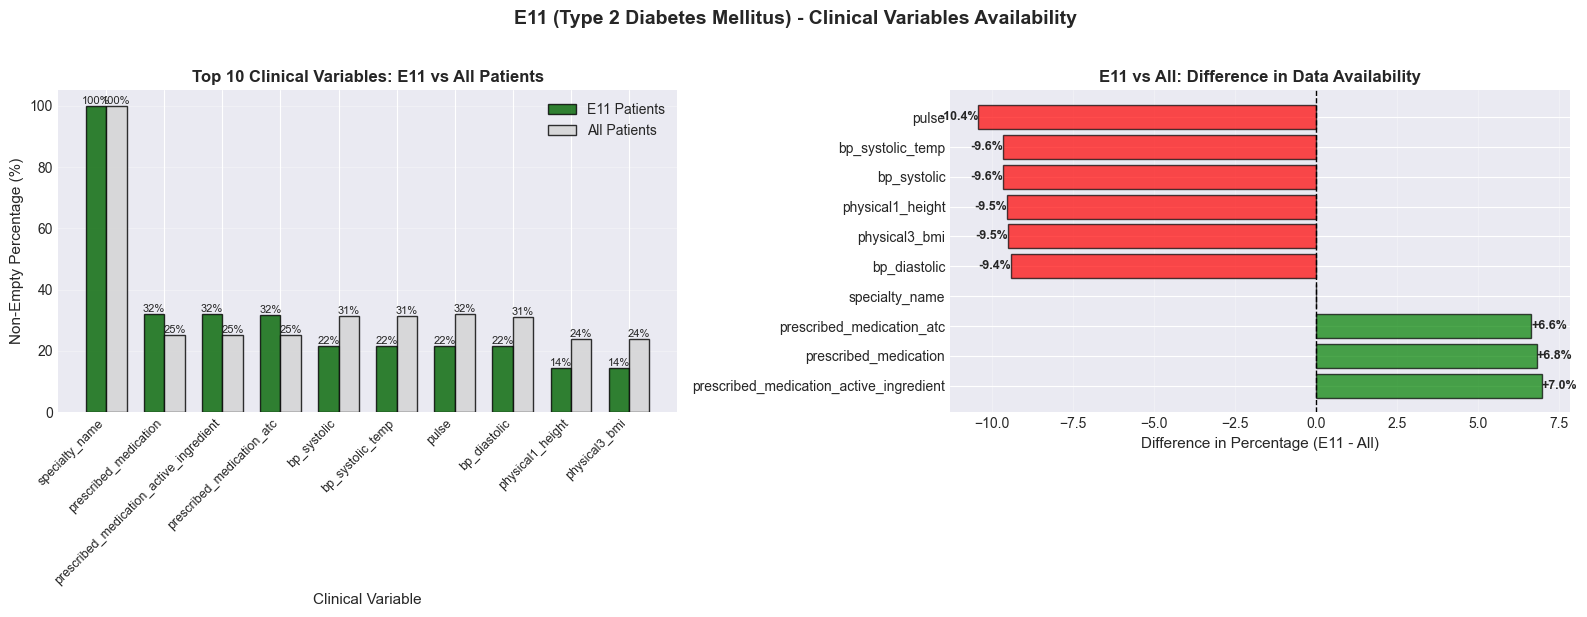

In [40]:
# Visualization: E11 vs All Patients - Clinical Variables Availability
if 'results_df_e11' in locals() and len(results_df_e11) > 0:
    # Top 10 variables by E11 percentage
    top10_e11 = results_df_e11.head(10)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # 1. Comparison bar chart
    ax1 = axes[0]
    x = np.arange(len(top10_e11))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, top10_e11['E11_Percentage'], width, 
                   label='E11 Patients', color='darkgreen', alpha=0.8, edgecolor='black')
    bars2 = ax1.bar(x + width/2, top10_e11['All_Percentage'], width,
                   label='All Patients', color='lightgray', alpha=0.8, edgecolor='black')
    
    ax1.set_xlabel('Clinical Variable', fontsize=11)
    ax1.set_ylabel('Non-Empty Percentage (%)', fontsize=11)
    ax1.set_title('Top 10 Clinical Variables: E11 vs All Patients', fontsize=12, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(top10_e11['Variable'], rotation=45, ha='right', fontsize=9)
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.set_ylim(0, 105)
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            if height > 5:  # Only label if significant
                ax1.text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:.0f}%', ha='center', va='bottom', fontsize=8)
    
    # 2. Difference chart (E11 - All)
    ax2 = axes[1]
    top10_diff = top10_e11.sort_values('Difference', ascending=False)
    colors_diff = ['green' if x > 0 else 'red' for x in top10_diff['Difference']]
    bars3 = ax2.barh(top10_diff['Variable'], top10_diff['Difference'], 
                    color=colors_diff, alpha=0.7, edgecolor='black')
    ax2.set_xlabel('Difference in Percentage (E11 - All)', fontsize=11)
    ax2.set_title('E11 vs All: Difference in Data Availability', fontsize=12, fontweight='bold')
    ax2.axvline(x=0, color='black', linestyle='--', linewidth=1)
    ax2.grid(True, alpha=0.3, axis='x')
    
    # Add value labels
    for bar in bars3:
        width_bar = bar.get_width()
        if abs(width_bar) > 1:  # Only label if significant difference
            ax2.text(width_bar, bar.get_y() + bar.get_height()/2.,
                    f'{width_bar:+.1f}%', ha='left' if width_bar > 0 else 'right', 
                    va='center', fontsize=9, fontweight='bold')
    
    plt.suptitle('E11 (Type 2 Diabetes Mellitus) - Clinical Variables Availability', 
                fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(VIZ_DIR / 'eda' / 'e11_clinical_variables_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()


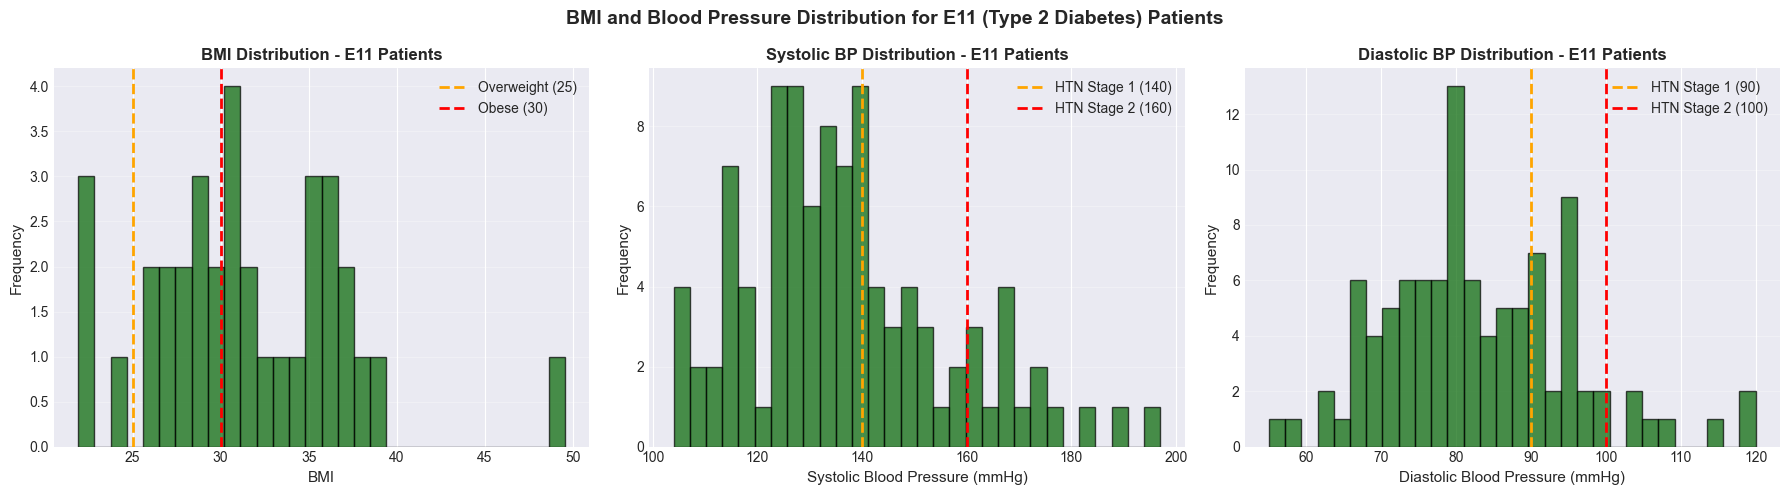

In [41]:
# Additional visualization: BMI and BP distribution for E11 patients
if 'icd3_code' in df.columns:
    e11_viz = df[df['icd3_code'] == 'E11'].copy()
    
    # Prepare BMI
    if 'bmi' not in e11_viz.columns:
        if 'cv_screening7_bmi' in e11_viz.columns:
            e11_viz['bmi'] = pd.to_numeric(e11_viz['cv_screening7_bmi'], errors='coerce')
        elif 'physical3_bmi' in e11_viz.columns:
            e11_viz['bmi'] = pd.to_numeric(e11_viz['physical3_bmi'], errors='coerce')
    
    # Prepare BP
    e11_viz['bp_systolic'] = pd.to_numeric(e11_viz['bp_systolic'], errors='coerce')
    e11_viz['bp_diastolic'] = pd.to_numeric(e11_viz['bp_diastolic'], errors='coerce')
    
    # Filter to plausible ranges
    e11_viz = e11_viz[
        (e11_viz['bmi'].between(10, 80) | e11_viz['bmi'].isna()) &
        (e11_viz['bp_systolic'].between(70, 250) | e11_viz['bp_systolic'].isna()) &
        (e11_viz['bp_diastolic'].between(40, 150) | e11_viz['bp_diastolic'].isna())
    ]
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # 1. BMI distribution
    if e11_viz['bmi'].notna().any():
        ax1 = axes[0]
        ax1.hist(e11_viz['bmi'].dropna(), bins=30, color='darkgreen', alpha=0.7, edgecolor='black')
        ax1.axvline(25, color='orange', linestyle='--', linewidth=2, label='Overweight (25)')
        ax1.axvline(30, color='red', linestyle='--', linewidth=2, label='Obese (30)')
        ax1.set_xlabel('BMI', fontsize=11)
        ax1.set_ylabel('Frequency', fontsize=11)
        ax1.set_title('BMI Distribution - E11 Patients', fontsize=12, fontweight='bold')
        ax1.legend()
        ax1.grid(True, alpha=0.3, axis='y')
    
    # 2. Systolic BP distribution
    if e11_viz['bp_systolic'].notna().any():
        ax2 = axes[1]
        ax2.hist(e11_viz['bp_systolic'].dropna(), bins=30, color='darkgreen', alpha=0.7, edgecolor='black')
        ax2.axvline(140, color='orange', linestyle='--', linewidth=2, label='HTN Stage 1 (140)')
        ax2.axvline(160, color='red', linestyle='--', linewidth=2, label='HTN Stage 2 (160)')
        ax2.set_xlabel('Systolic Blood Pressure (mmHg)', fontsize=11)
        ax2.set_ylabel('Frequency', fontsize=11)
        ax2.set_title('Systolic BP Distribution - E11 Patients', fontsize=12, fontweight='bold')
        ax2.legend()
        ax2.grid(True, alpha=0.3, axis='y')
    
    # 3. Diastolic BP distribution
    if e11_viz['bp_diastolic'].notna().any():
        ax3 = axes[2]
        ax3.hist(e11_viz['bp_diastolic'].dropna(), bins=30, color='darkgreen', alpha=0.7, edgecolor='black')
        ax3.axvline(90, color='orange', linestyle='--', linewidth=2, label='HTN Stage 1 (90)')
        ax3.axvline(100, color='red', linestyle='--', linewidth=2, label='HTN Stage 2 (100)')
        ax3.set_xlabel('Diastolic Blood Pressure (mmHg)', fontsize=11)
        ax3.set_ylabel('Frequency', fontsize=11)
        ax3.set_title('Diastolic BP Distribution - E11 Patients', fontsize=12, fontweight='bold')
        ax3.legend()
        ax3.grid(True, alpha=0.3, axis='y')
    
    plt.suptitle('BMI and Blood Pressure Distribution for E11 (Type 2 Diabetes) Patients', 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(VIZ_DIR / 'eda' / 'e11_bmi_bp_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()


#### Systolic Blood Pressure by Age Group


In [42]:
# Create age groups and analyze systolic BP
required_cols = {'bp_systolic', 'age'}
if required_cols.issubset(df.columns):
    sbp_df = df[['bp_systolic', 'age']].copy()
    sbp_df['bp_systolic'] = pd.to_numeric(sbp_df['bp_systolic'], errors='coerce')
    sbp_df['age'] = pd.to_numeric(sbp_df['age'], errors='coerce')
    sbp_df = sbp_df.replace([np.inf, -np.inf], np.nan).dropna()

    # Plausible range filter
    sbp_df = sbp_df[sbp_df['bp_systolic'].between(70, 250)]
    sbp_df = sbp_df[sbp_df['age'].between(0, 100)]

    # Age groups
    sbp_df['age_group'] = pd.cut(
        sbp_df['age'],
        bins=[0, 18, 30, 45, 60, 75, 100],
        labels=['0-18', '19-30', '31-45', '46-60', '61-75', '75+']
    )

    # Summary statistics by age group
    stats = sbp_df.groupby('age_group')['bp_systolic'].agg(
        n='count', mean='mean', median='median', std='std',
        q25=lambda s: s.quantile(0.25), q75=lambda s: s.quantile(0.75),
        min='min', max='max'
    ).reset_index()
    print('Systolic BP summary by age group:')
    display(stats.round(2))

    # Hypertension thresholds
    sbp_df['htn_stage1_or_higher'] = (sbp_df['bp_systolic'] >= 140).astype(int)
    sbp_df['htn_stage2'] = (sbp_df['bp_systolic'] >= 160).astype(int)

    rates = sbp_df.groupby('age_group')[['htn_stage1_or_higher', 'htn_stage2']].mean() * 100
    rates = rates.reset_index().rename(columns={'htn_stage1_or_higher': 'HTN ≥140 (%)', 'htn_stage2': 'HTN ≥160 (%)'})
    print('\nHypertension rates by age group (%):')
    display(rates.round(2))
else:
    print('Required columns not found for SBP by age group EDA.')


Systolic BP summary by age group:


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_25340\1800880006.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats = sbp_df.groupby('age_group')['bp_systolic'].agg(


,age_group,n,mean,median,std,q25,q75,min,max
0,0-18,189,109.99,110.0,12.67,101.0,118.0,80.0,160.0
1,19-30,721,120.60,120.0,14.25,110.0,129.0,81.0,180.0
2,31-45,1739,127.78,126.0,17.36,116.5,137.0,84.0,224.0
3,46-60,2666,137.39,136.0,19.00,124.0,148.0,81.0,215.0
4,61-75,2401,139.99,138.0,19.92,126.0,153.0,77.0,230.0
5,75+,593,144.94,145.0,19.38,131.0,157.0,82.0,229.0



Hypertension rates by age group (%):


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_25340\1800880006.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rates = sbp_df.groupby('age_group')[['htn_stage1_or_higher', 'htn_stage2']].mean() * 100


,age_group,HTN ≥140 (%),HTN ≥160 (%)
0,0-18,1.59,0.53
1,19-30,10.40,0.42
2,31-45,21.85,4.66
3,46-60,41.64,12.53
4,61-75,47.94,15.66
5,75+,60.20,21.59


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_25340\769859473.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


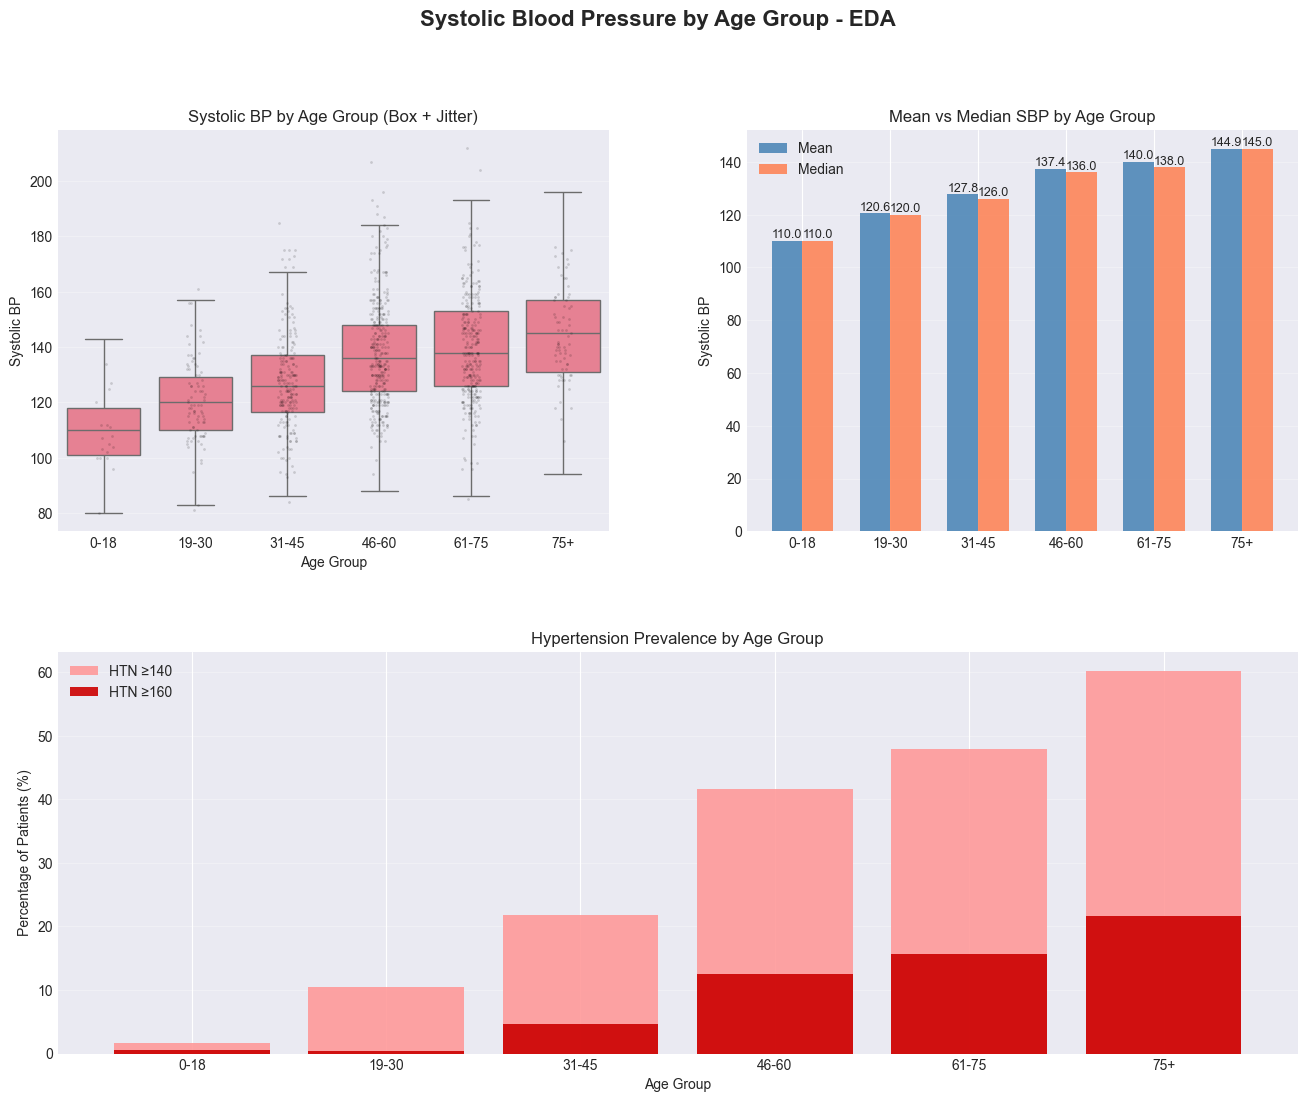

In [43]:
# Visualizations: SBP by age group
if required_cols.issubset(df.columns):
    if 'age_group' not in sbp_df.columns:
        pass
    if sbp_df['age_group'].notna().any():
        fig = plt.figure(figsize=(16, 12))
        gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.25)

        # 1. Box plot by age group
        ax1 = fig.add_subplot(gs[0, 0])
        order = ['0-18', '19-30', '31-45', '46-60', '61-75', '75+']
        sns.boxplot(data=sbp_df, x='age_group', y='bp_systolic', order=order, ax=ax1, showfliers=False)
        sns.stripplot(data=sbp_df.sample(min(1000, len(sbp_df))), x='age_group', y='bp_systolic', order=order,
                      ax=ax1, color='k', alpha=0.15, size=2)
        ax1.set_xlabel('Age Group')
        ax1.set_ylabel('Systolic BP')
        ax1.set_title('Systolic BP by Age Group (Box + Jitter)')
        ax1.grid(True, axis='y', alpha=0.3)

        # 2. Mean and median bars
        ax2 = fig.add_subplot(gs[0, 1])
        mm = stats[['age_group', 'mean', 'median']].copy()
        x = np.arange(len(order))
        width = 0.35
        means = mm.set_index('age_group').reindex(order)['mean'].values
        medians = mm.set_index('age_group').reindex(order)['median'].values
        b1 = ax2.bar(x - width/2, means, width, label='Mean', color='steelblue', alpha=0.85)
        b2 = ax2.bar(x + width/2, medians, width, label='Median', color='coral', alpha=0.85)
        ax2.set_xticks(x)
        ax2.set_xticklabels(order, rotation=0)
        ax2.set_ylabel('Systolic BP')
        ax2.set_title('Mean vs Median SBP by Age Group')
        ax2.legend()
        ax2.grid(True, axis='y', alpha=0.3)
        for bars in [b1, b2]:
            for bar in bars:
                ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height(), f'{bar.get_height():.1f}',
                         ha='center', va='bottom', fontsize=9)

        # 3. Hypertension rates (stacked)
        ax3 = fig.add_subplot(gs[1, :])
        r = rates.set_index('age_group').reindex(order)
        ax3.bar(r.index, r['HTN ≥140 (%)'], label='HTN ≥140', color='#ff9999', alpha=0.9)
        ax3.bar(r.index, r['HTN ≥160 (%)'], label='HTN ≥160', color='#cc0000', alpha=0.9)
        ax3.set_xlabel('Age Group')
        ax3.set_ylabel('Percentage of Patients (%)')
        ax3.set_title('Hypertension Prevalence by Age Group')
        ax3.legend()
        ax3.grid(True, axis='y', alpha=0.3)

        plt.suptitle('Systolic Blood Pressure by Age Group - EDA', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig(VIZ_DIR / 'eda' / 'sbp_by_age_group.png', dpi=300, bbox_inches='tight')
        plt.show()


Total unique ICD3 codes: 648

Top 20 ICD3 codes:


icd3_code
U99    2865
Z13    2661
Z01    2301
I10    2260
E07    1473
E78    1121
Z02    1063
K76     839
I70     496
E11     462
E66     393
N28     311
E03     257
R10     246
E04     244
I25     225
K80     212
E55     209
D50     205
I48     202
Name: count, dtype: int64

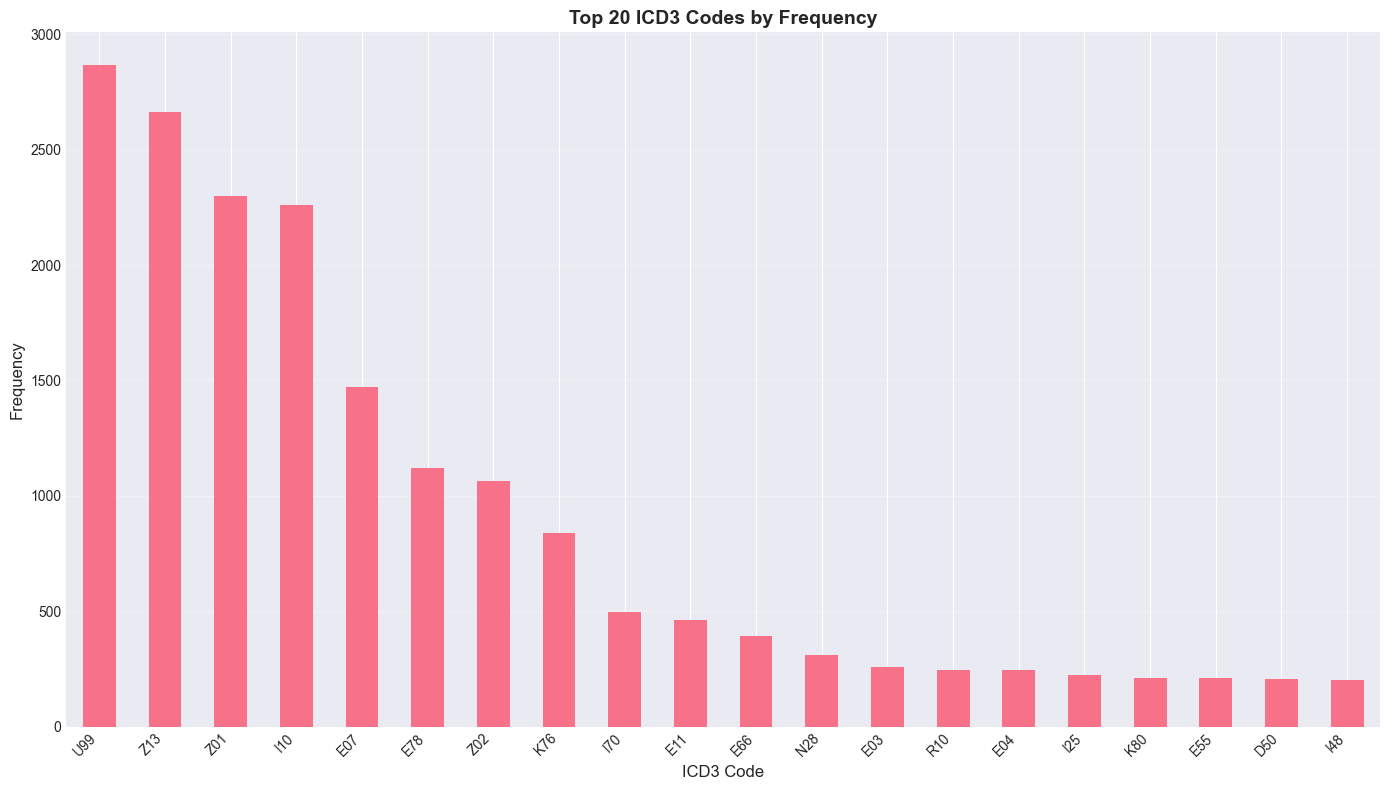

In [44]:
if 'icd3_code' in df.columns:
    icd3_dist = df['icd3_code'].value_counts()
    print(f"Total unique ICD3 codes: {len(icd3_dist)}")
    print(f"\nTop 20 ICD3 codes:")
    display(icd3_dist.head(20))
    
    # ICD3 frequency bar chart
    plt.figure(figsize=(14, 8))
    top_20_icd3 = icd3_dist.head(20)
    top_20_icd3.plot(kind='bar')
    plt.title('Top 20 ICD3 Codes by Frequency', fontsize=14, fontweight='bold')
    plt.xlabel('ICD3 Code', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig(VIZ_DIR / 'eda' / 'icd3_frequency.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Co-morbidity analysis (multiple ICD codes per patient)
    if 'icd_code_name' in df.columns and 'taj_identifier' in df.columns:
        patient_icd_counts = df.groupby('taj_identifier')['icd3_code'].nunique()
        print(f"\nCo-morbidity analysis:")
        print(f"  Patients with single ICD3: {(patient_icd_counts == 1).sum()}")
        print(f"  Patients with multiple ICD3: {(patient_icd_counts > 1).sum()}")
        print(f"  Average ICD3 codes per patient: {patient_icd_counts.mean():.2f}")
        print(f"  Max ICD3 codes for a patient: {patient_icd_counts.max()}")


In [45]:
# Top 10 ICD3 with most BP (systolic/diastolic) data
required_cols = {'icd3_code', 'bp_systolic', 'bp_diastolic'}
if required_cols.issubset(df.columns):
    bp_df = df[['icd3_code', 'bp_systolic', 'bp_diastolic']].copy()
    # Coerce numerics and drop inf
    bp_df['bp_systolic'] = pd.to_numeric(bp_df['bp_systolic'], errors='coerce')
    bp_df['bp_diastolic'] = pd.to_numeric(bp_df['bp_diastolic'], errors='coerce')

    # Aggregate by ICD3
    grp = bp_df.groupby('icd3_code')
    counts = grp.agg(
        n_rows=('icd3_code','size'),
        sbp_count=('bp_systolic', lambda s: s.notna().sum()),
        dbp_count=('bp_diastolic', lambda s: s.notna().sum())
    ).reset_index()
    counts['sbp_pct'] = (counts['sbp_count'] / counts['n_rows'] * 100).round(2)
    counts['dbp_pct'] = (counts['dbp_count'] / counts['n_rows'] * 100).round(2)
    counts['bp_total_count'] = counts['sbp_count'] + counts['dbp_count']

    # Sort by combined availability then by n_rows
    top10 = counts.sort_values(['bp_total_count','n_rows'], ascending=False).head(10)

    # Optional: add simple central tendency for available values
    medians = grp.agg(
        sbp_median=('bp_systolic', 'median'),
        dbp_median=('bp_diastolic', 'median')
    ).reset_index()
    top10 = top10.merge(medians, on='icd3_code', how='left')

    display(top10[['icd3_code','n_rows','sbp_count','sbp_pct','dbp_count','dbp_pct','sbp_median','dbp_median']].reset_index(drop=True))

    # Save
    out_path = VIZ_DIR / 'eda' / 'top10_icd3_bp_availability.csv'
    top10.to_csv(out_path, index=False)
    print(f"\n✓ Saved table to {out_path}")
else:
    print('Required columns not found: expected icd3_code, bp_systolic, bp_diastolic')


,icd3_code,n_rows,sbp_count,sbp_pct,dbp_count,dbp_pct,sbp_median,dbp_median
0,Z01,2301,2019,87.74,2005,87.14,132.0,84.0
1,Z13,2661,1909,71.74,1892,71.10,131.0,84.0
2,I10,2260,810,35.84,804,35.58,143.0,87.0
3,Z02,1063,453,42.62,451,42.43,132.0,84.0
4,E78,1121,333,29.71,330,29.44,135.0,86.0
5,U99,2865,153,5.34,153,5.34,123.0,79.0
6,E07,1473,114,7.74,114,7.74,130.0,84.0
7,E66,393,105,26.72,105,26.72,134.0,86.0
8,E11,462,100,21.65,100,21.65,133.5,80.0
9,I25,225,68,30.22,68,30.22,132.0,83.0



✓ Saved table to outputs\visualizations\eda\top10_icd3_bp_availability.csv


### E07 (Thyroid Disorders) - Clinical Variables Analysis

In [46]:
# Analyze E07 (Thyroid Disorders) - Clinical variables availability
if 'icd3_code' in df.columns:
    e07_df = df[df['icd3_code'] == 'E07'].copy()
    all_df = df.copy()
    
    print("=" * 80)
    print("E07 (Thyroid Disorders) - Clinical Variables Analysis")
    print("=" * 80)
    print(f"\nTotal E07 records: {len(e07_df):,}")
    print(f"Total records in dataset: {len(all_df):,}")
    
    # Define potentially relevant clinical variables for thyroid disorders
    thyroid_relevant_vars = [
        # Ultrasound - very relevant for thyroid
        'measurements_ultrasound_category',
        'ultrasound_description',
        'ultrasound1_area_code_id',
        'ultrasound2_machine_code_id',
        'ultrasound3_date',
        # Anthropometrics - thyroid affects metabolism
        'cv_screening5_height',
        'cv_screening6_weight',
        'cv_screening7_bmi',
        'physical1_height',
        'physical2_weight',
        'physical3_bmi',
        # Cardiovascular - thyroid affects heart
        'bp_systolic',
        'bp_diastolic',
        'bp_systolic2',
        'bp_diastolic2',
        'pulse',
        # Specialty - endocrinology might be relevant
        'specialty_name',
        # Medications - might include thyroid medications
        'prescribed_medication',
        'prescribed_medication_atc',
        'prescribed_medication_active_ingredient',
        # Other measurements
        'measurements_diabetes_data',
        'ekg1_description'
    ]
    
    # Filter to only variables that exist in the dataset
    available_vars = [v for v in thyroid_relevant_vars if v in df.columns]
    
    print(f"\nRelevant clinical variables for thyroid disorders: {len(available_vars)}")
    print(f"Variables checked: {', '.join(available_vars)}")
    
    # Calculate non-empty percentages
    results = []
    for var in available_vars:
        e07_non_empty = e07_df[var].notna().sum()
        e07_total = len(e07_df)
        e07_pct = (e07_non_empty / e07_total * 100) if e07_total > 0 else 0
        
        all_non_empty = all_df[var].notna().sum()
        all_total = len(all_df)
        all_pct = (all_non_empty / all_total * 100) if all_total > 0 else 0
        
        # For string columns, also check if empty strings
        if e07_df[var].dtype == 'object':
            e07_non_empty = ((e07_df[var].notna()) & (e07_df[var] != '')).sum()
            e07_pct = (e07_non_empty / e07_total * 100) if e07_total > 0 else 0
            all_non_empty = ((all_df[var].notna()) & (all_df[var] != '')).sum()
            all_pct = (all_non_empty / all_total * 100) if all_total > 0 else 0
        
        results.append({
            'Variable': var,
            'E07_Non_Empty_Count': e07_non_empty,
            'E07_Total': e07_total,
            'E07_Percentage': e07_pct,
            'All_Non_Empty_Count': all_non_empty,
            'All_Total': all_total,
            'All_Percentage': all_pct,
            'Difference': e07_pct - all_pct
        })
    
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('E07_Percentage', ascending=False)
    
    print("\n" + "=" * 80)
    print("NON-EMPTY ROW PERCENTAGES: E07 vs All Patients")
    print("=" * 80)
    display(results_df.round(2))
    
    # Highlight ultrasound-related variables (most relevant for thyroid)
    print("\n" + "-" * 80)
    print("ULTRASOUND VARIABLES (Most relevant for thyroid disorders):")
    print("-" * 80)
    ultrasound_vars = [v for v in available_vars if 'ultrasound' in v.lower()]
    if ultrasound_vars:
        display(results_df[results_df['Variable'].isin(ultrasound_vars)].round(2))
    
    # Save results
    results_df.to_csv(DATA_DIR / 'e07_clinical_variables_analysis.csv', index=False)
    print(f"\n✓ Saved detailed results to: {DATA_DIR / 'e07_clinical_variables_analysis.csv'}")


E07 (Thyroid Disorders) - Clinical Variables Analysis

Total E07 records: 1,473
Total records in dataset: 26,551

Relevant clinical variables for thyroid disorders: 22
Variables checked: measurements_ultrasound_category, ultrasound_description, ultrasound1_area_code_id, ultrasound2_machine_code_id, ultrasound3_date, cv_screening5_height, cv_screening6_weight, cv_screening7_bmi, physical1_height, physical2_weight, physical3_bmi, bp_systolic, bp_diastolic, bp_systolic2, bp_diastolic2, pulse, specialty_name, prescribed_medication, prescribed_medication_atc, prescribed_medication_active_ingredient, measurements_diabetes_data, ekg1_description

NON-EMPTY ROW PERCENTAGES: E07 vs All Patients


,Variable,E07_Non_Empty_Count,E07_Total,E07_Percentage,All_Non_Empty_Count,All_Total,All_Percentage,Difference
16,specialty_name,1473,1473,100.00,26551,26551,100.00,0.00
0,measurements_ultrasound_category,723,1473,49.08,4077,26551,15.36,33.73
2,ultrasound1_area_code_id,722,1473,49.02,4062,26551,15.30,33.72
1,ultrasound_description,719,1473,48.81,4011,26551,15.11,33.71
4,ultrasound3_date,679,1473,46.10,3795,26551,14.29,31.80
3,ultrasound2_machine_code_id,646,1473,43.86,3468,26551,13.06,30.79
15,pulse,136,1473,9.23,8515,26551,32.07,-22.84
12,bp_diastolic,114,1473,7.74,8244,26551,31.05,-23.31
11,bp_systolic,114,1473,7.74,8309,26551,31.29,-23.56
18,prescribed_medication_atc,105,1473,7.13,6684,26551,25.17,-18.05



--------------------------------------------------------------------------------
ULTRASOUND VARIABLES (Most relevant for thyroid disorders):
--------------------------------------------------------------------------------


,Variable,E07_Non_Empty_Count,E07_Total,E07_Percentage,All_Non_Empty_Count,All_Total,All_Percentage,Difference
0,measurements_ultrasound_category,723,1473,49.08,4077,26551,15.36,33.73
2,ultrasound1_area_code_id,722,1473,49.02,4062,26551,15.30,33.72
1,ultrasound_description,719,1473,48.81,4011,26551,15.11,33.71
4,ultrasound3_date,679,1473,46.10,3795,26551,14.29,31.80
3,ultrasound2_machine_code_id,646,1473,43.86,3468,26551,13.06,30.79



✓ Saved detailed results to: outputs\data\e07_clinical_variables_analysis.csv


In [47]:
# Check thyroid-specific content in ultrasound descriptions for E07
if 'ultrasound_description' in df.columns and 'icd3_code' in df.columns:
    e07_ultrasound = df[(df['icd3_code'] == 'E07') & (df['ultrasound_description'].notna()) & (df['ultrasound_description'] != '')]
    
    print("\n" + "=" * 80)
    print("THYROID-SPECIFIC ULTRASOUND DATA FOR E07")
    print("=" * 80)
    print(f"\nE07 records with ultrasound description: {len(e07_ultrasound):,}")
    
    # Check if ultrasound descriptions contain thyroid-related terms
    if len(e07_ultrasound) > 0:
        thyroid_keywords = ['pajzsmirigy', 'thyroid', 'isthmus', 'lebeny', 'göb', 'nodule']
        keyword_counts = {}
        
        for keyword in thyroid_keywords:
            count = e07_ultrasound['ultrasound_description'].str.contains(keyword, case=False, na=False).sum()
            keyword_counts[keyword] = count
        
        print("\nThyroid-related keywords found in E07 ultrasound descriptions:")
        for keyword, count in keyword_counts.items():
            pct = (count / len(e07_ultrasound) * 100) if len(e07_ultrasound) > 0 else 0
            print(f"  '{keyword}': {count:,} records ({pct:.1f}%)")
        
        # Sample ultrasound descriptions
        print("\n\nSample E07 ultrasound descriptions (first 3):")
        print("-" * 80)
        for idx, desc in enumerate(e07_ultrasound['ultrasound_description'].head(3), 1):
            print(f"\n{idx}. {desc[:500]}...")  # First 500 chars



THYROID-SPECIFIC ULTRASOUND DATA FOR E07

E07 records with ultrasound description: 719

Thyroid-related keywords found in E07 ultrasound descriptions:
  'pajzsmirigy': 515 records (71.6%)
  'thyroid': 0 records (0.0%)
  'isthmus': 657 records (91.4%)
  'lebeny': 702 records (97.6%)
  'göb': 633 records (88.0%)
  'nodule': 0 records (0.0%)


Sample E07 ultrasound descriptions (first 3):
--------------------------------------------------------------------------------

1. A pajzsmirigy nem nagyobb, a jobb lebeny 16x15x14 mm, térfogata 5,6 cm3 , a bal lebeny 15x14x38 mm, térfogata 4 cm3 . Az isthmus nem szélesebb, 2,4 mm. A lebenyekben körülírt eltérés nem látható, szerkezetük mérs. inhomogén. A vascularisatio diffúzan kp. fokban fokozott.  A trachea nem comprimalt, nem dislocalt. A nyakon kórosan megnagyobbodott nyirokcsomó nem ábrázolódik. A nyálmirigyek megjelenése szabályos....

2. A trachea légsávja kp. vonalban van.Az isthmus norm. szélességű, mérs. inhomogén szerkezetű. Az isthmus 

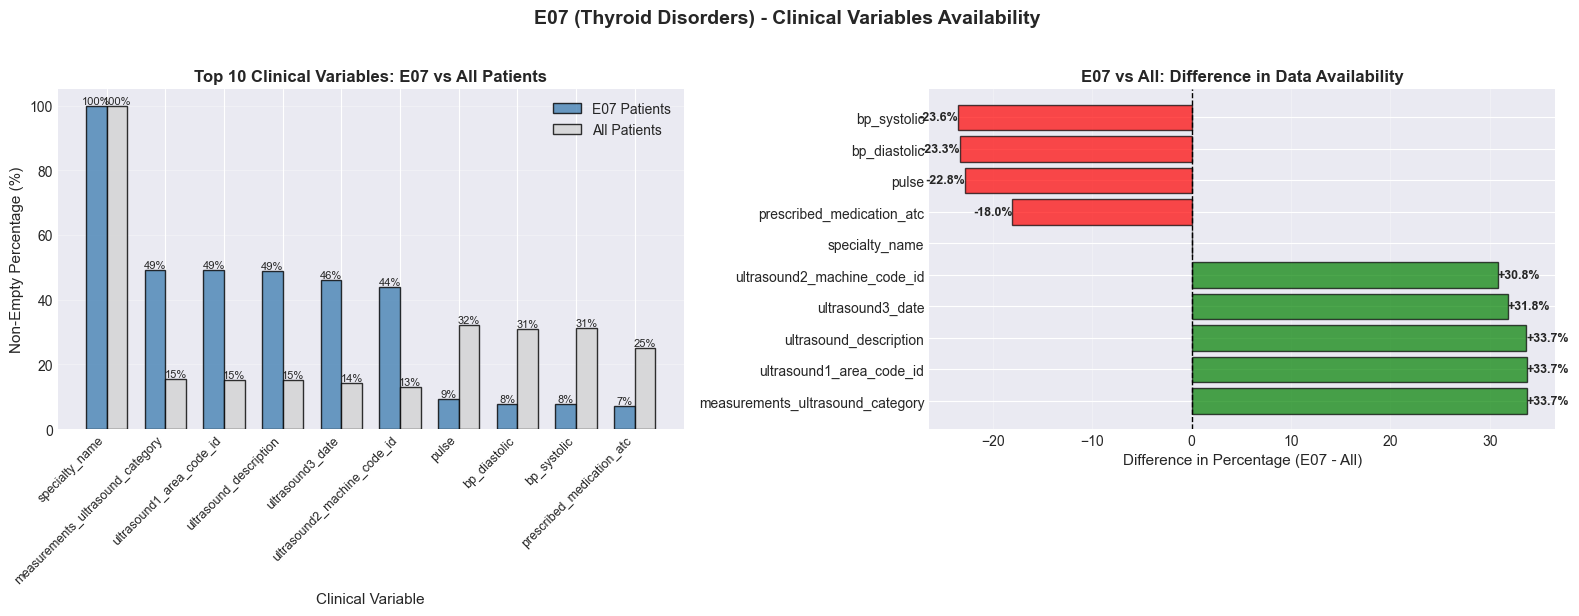

In [48]:
# Visualization: E07 vs All Patients - Clinical Variables Availability
if 'results_df' in locals() and len(results_df) > 0:
    # Top 10 variables by E07 percentage
    top10_e07 = results_df.head(10)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # 1. Comparison bar chart
    ax1 = axes[0]
    x = np.arange(len(top10_e07))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, top10_e07['E07_Percentage'], width, 
                   label='E07 Patients', color='steelblue', alpha=0.8, edgecolor='black')
    bars2 = ax1.bar(x + width/2, top10_e07['All_Percentage'], width,
                   label='All Patients', color='lightgray', alpha=0.8, edgecolor='black')
    
    ax1.set_xlabel('Clinical Variable', fontsize=11)
    ax1.set_ylabel('Non-Empty Percentage (%)', fontsize=11)
    ax1.set_title('Top 10 Clinical Variables: E07 vs All Patients', fontsize=12, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(top10_e07['Variable'], rotation=45, ha='right', fontsize=9)
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.set_ylim(0, 105)
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            if height > 5:  # Only label if significant
                ax1.text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:.0f}%', ha='center', va='bottom', fontsize=8)
    
    # 2. Difference chart (E07 - All)
    ax2 = axes[1]
    top10_diff = top10_e07.sort_values('Difference', ascending=False)
    colors_diff = ['green' if x > 0 else 'red' for x in top10_diff['Difference']]
    bars3 = ax2.barh(top10_diff['Variable'], top10_diff['Difference'], 
                    color=colors_diff, alpha=0.7, edgecolor='black')
    ax2.set_xlabel('Difference in Percentage (E07 - All)', fontsize=11)
    ax2.set_title('E07 vs All: Difference in Data Availability', fontsize=12, fontweight='bold')
    ax2.axvline(x=0, color='black', linestyle='--', linewidth=1)
    ax2.grid(True, alpha=0.3, axis='x')
    
    # Add value labels
    for bar in bars3:
        width_bar = bar.get_width()
        if abs(width_bar) > 1:  # Only label if significant difference
            ax2.text(width_bar, bar.get_y() + bar.get_height()/2.,
                    f'{width_bar:+.1f}%', ha='left' if width_bar > 0 else 'right', 
                    va='center', fontsize=9, fontweight='bold')
    
    plt.suptitle('E07 (Thyroid Disorders) - Clinical Variables Availability', 
                fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(VIZ_DIR / 'eda' / 'e07_clinical_variables_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()


In [49]:
## number of unique records in E07

print(f"Number of unique records in E07: {len(e07_df['pid'].unique())}")

Number of unique records in E07: 865
